# Projet de Machine Learning

Notebook <b>R</b> avec les codes utilisés pour le rapport final.<br>
Auteurs : Juan AYALA, Jeong Hwan KO, Alice LALOUE, Aldo MELLADO AGUILAR.<br>
4A MA - Groupes A et B<br>
2020 - 2021

## Importation des librairies

In [1]:
library(corrplot)
library(dplyr)
library(factoextra)
library(FactoMineR)
library(ggplot2)
library(glmnet)
library(RColorBrewer)
library(vcd)

corrplot 0.84 loaded


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: Matrix

Loaded glmnet 4.1-1

Loading required package: grid



In [2]:
# Cette cellule permet de centrer les figures automatiquement
IRdisplay::display_html('
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
')

# Obtenir les données

In [3]:
spotify_data <- read.table(file = "data/spotify-extr.txt", header = T, sep = " ")

# Description de l'ensemble du jeu de données

In [4]:
head(spotify_data)

,valence,year,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,pop.class
,<dbl>,<int>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<chr>
161704,0.647,1975,0.4490,0.376,298840,0.827,7.88e-03,B,0.466,-7.604,1,25,0.3990,170.475,C
168077,0.150,2008,0.8990,0.508,236800,0.169,1.12e-05,Ab,0.136,-11.332,1,42,0.0553,107.477,B
35922,0.423,2007,0.0185,0.470,301093,0.878,8.39e-02,B,0.276,-5.576,0,65,0.0377,150.093,A
135823,0.302,1995,0.0384,0.176,142200,0.980,5.52e-01,B,0.237,-3.154,1,36,0.0721,172.566,C
165395,0.828,1994,0.5310,0.705,187800,0.625,7.73e-06,G,0.348,-11.963,0,38,0.0639,97.831,C
38184,0.489,2018,0.3710,0.856,324189,0.694,0.00e+00,D,0.109,-4.393,1,68,0.1690,122.080,A


In [5]:
str(spotify_data)

'data.frame':	10000 obs. of  15 variables:
 $ valence         : num  0.647 0.15 0.423 0.302 0.828 0.489 0.963 0.809 0.411 0.463 ...
 $ year            : int  1975 2008 2007 1995 1994 2018 2003 1992 1980 2001 ...
 $ acousticness    : num  0.449 0.899 0.0185 0.0384 0.531 0.371 0.523 0.00556 0.36 0.137 ...
 $ danceability    : num  0.376 0.508 0.47 0.176 0.705 0.856 0.819 0.737 0.602 0.453 ...
 $ duration        : int  298840 236800 301093 142200 187800 324189 178680 262800 312773 514867 ...
 $ energy          : num  0.827 0.169 0.878 0.98 0.625 0.694 0.615 0.89 0.732 0.562 ...
 $ instrumentalness: num  7.88e-03 1.12e-05 8.39e-02 5.52e-01 7.73e-06 0.00 1.48e-06 1.71e-03 3.14e-04 2.90e-03 ...
 $ key             : chr  "B" "Ab" "B" "B" ...
 $ liveness        : num  0.466 0.136 0.276 0.237 0.348 0.109 0.0794 0.0801 0.0755 0.0463 ...
 $ loudness        : num  -7.6 -11.33 -5.58 -3.15 -11.96 ...
 $ mode            : int  1 1 0 1 0 1 1 1 1 0 ...
 $ popularity      : int  25 42 65 36 38 68 47 59 

On n'a pas de valeurs manquantes donc on n'a pas besoin de les retravailler.

Les variables explicatives sont :
* `valence` : la positivité de la chanson, vaut 1 si la chanson est très joyeuse, 0 sinon ;
* `year` : année de sortie ;
* `acousticness` : mesure "l'acousticité" de la chanson ;
* `danceability` : mesure la "dançabilite" d'une chanson ;
* `duration` : durée d'une chanson en millisecondes ;
* `energy` : l'énergie de la chanson, vaut 1 si la chanson est très énergétique, 0 sinon ;
* `intrumentalness` : taux d'instrumentalisation, vaut 1 s'il n'y a aucune voix présente dans la chanson, 0 sinon ; 
* `key` : tonalité de la musique (ex : A=la), ne prend pas en compte la distinction majeur/mineur ;
* `liveness` : taux de prestation en live, vaut 1 si la chanson ne comporte que de la musique (sans sons à intérêts non-musicaux), 0 sinon ;
* `loudness` : intensité sonore de la chanson
* `mode` : variable binaire qui indique si la chanson commence par une progression d'accords majeure (1) ou non (0)
* `speechiness` : taux de vocaux dans la chanson, vaut 1 si la chanson comporte de la voix tout le long, 0 sinon ;
* `tempo` :  tempo de la chanson en beats par minute (bpm)

Notre objectif consiste à prédire la valeur de `pop.class` et de `popularity`, c'est-à-dire la popularité d'une chanson, soit comme un entier entre 0 et 100, soit comme une classe $A$, $B$, $C$ ou $D$.

In [6]:
summary(spotify_data)

    valence            year       acousticness      danceability  
 Min.   :0.0000   Min.   :1921   Min.   :0.00000   Min.   :0.000  
 1st Qu.:0.3240   1st Qu.:1956   1st Qu.:0.09267   1st Qu.:0.417  
 Median :0.5430   Median :1978   Median :0.50400   Median :0.550  
 Mean   :0.5328   Mean   :1977   Mean   :0.49572   Mean   :0.540  
 3rd Qu.:0.7510   3rd Qu.:1999   3rd Qu.:0.88925   3rd Qu.:0.671  
 Max.   :0.9930   Max.   :2020   Max.   :0.99600   Max.   :0.988  
    duration           energy       instrumentalness       key           
 Min.   :   5991   Min.   :0.0000   Min.   :0.000000   Length:10000      
 1st Qu.: 169067   1st Qu.:0.2620   1st Qu.:0.000000   Class :character  
 Median : 206530   Median :0.4760   Median :0.000174   Mode  :character  
 Mean   : 227215   Mean   :0.4875   Mean   :0.164947                     
 3rd Qu.: 259733   3rd Qu.:0.7080   3rd Qu.:0.087100                     
 Max.   :2703227   Max.   :1.0000   Max.   :1.000000                     
    liveness 

Dans notre jeu de données, les variables qualitatives sont :
* `pop.class`,
* `key`,
* `mode`.

Le reste des variables sont quantitatives.

On transforme les variables qualitatives en catégories pour mieux traiter les données.

In [7]:
spotify_data$pop.class <- factor(spotify_data$pop.class, ordered = TRUE,
                                 levels = c("D", "C", "B", "A"))
spotify_data$key <- factor(spotify_data$key)
spotify_data$mode <- factor(spotify_data$mode)

In [8]:
pop.class <- spotify_data$pop.class
key <- spotify_data$key
mode <- spotify_data$mode

In [9]:
rev(levels(pop.class))
levels(key)
levels(mode)

[1] "A" "B" "C" "D"

[1] "A"  "Ab" "B"  "Bb" "C"  "D"  "Db" "E"  "Eb" "F"  "G"  "Gb"

[1] "0" "1"

In [10]:
sapply(spotify_data, class)

$valence
[1] "numeric"

$year
[1] "integer"

$acousticness
[1] "numeric"

$danceability
[1] "numeric"

$duration
[1] "integer"

$energy
[1] "numeric"

$instrumentalness
[1] "numeric"

$key
[1] "factor"

$liveness
[1] "numeric"

$loudness
[1] "numeric"

$mode
[1] "factor"

$popularity
[1] "integer"

$speechiness
[1] "numeric"

$tempo
[1] "numeric"

$pop.class
[1] "ordered" "factor"

# Analyses uni et multidimensionnelles

## Variables qualitatives

On commence par analyser les variables qualitatives `pop.class`, `key` et `mode`.

In [11]:
data.qual <- spotify_data[, c("key", "mode", "pop.class")]
head(data.qual)

,key,mode,pop.class
,<fct>,<fct>,<ord>
161704,B,1,C
168077,Ab,1,B
35922,B,0,A
135823,B,1,C
165395,G,0,C
38184,D,1,A


<b>Classe de popularité</b> (variable à prédire)

Cette variable a été créée en amont de l'obtention des données.

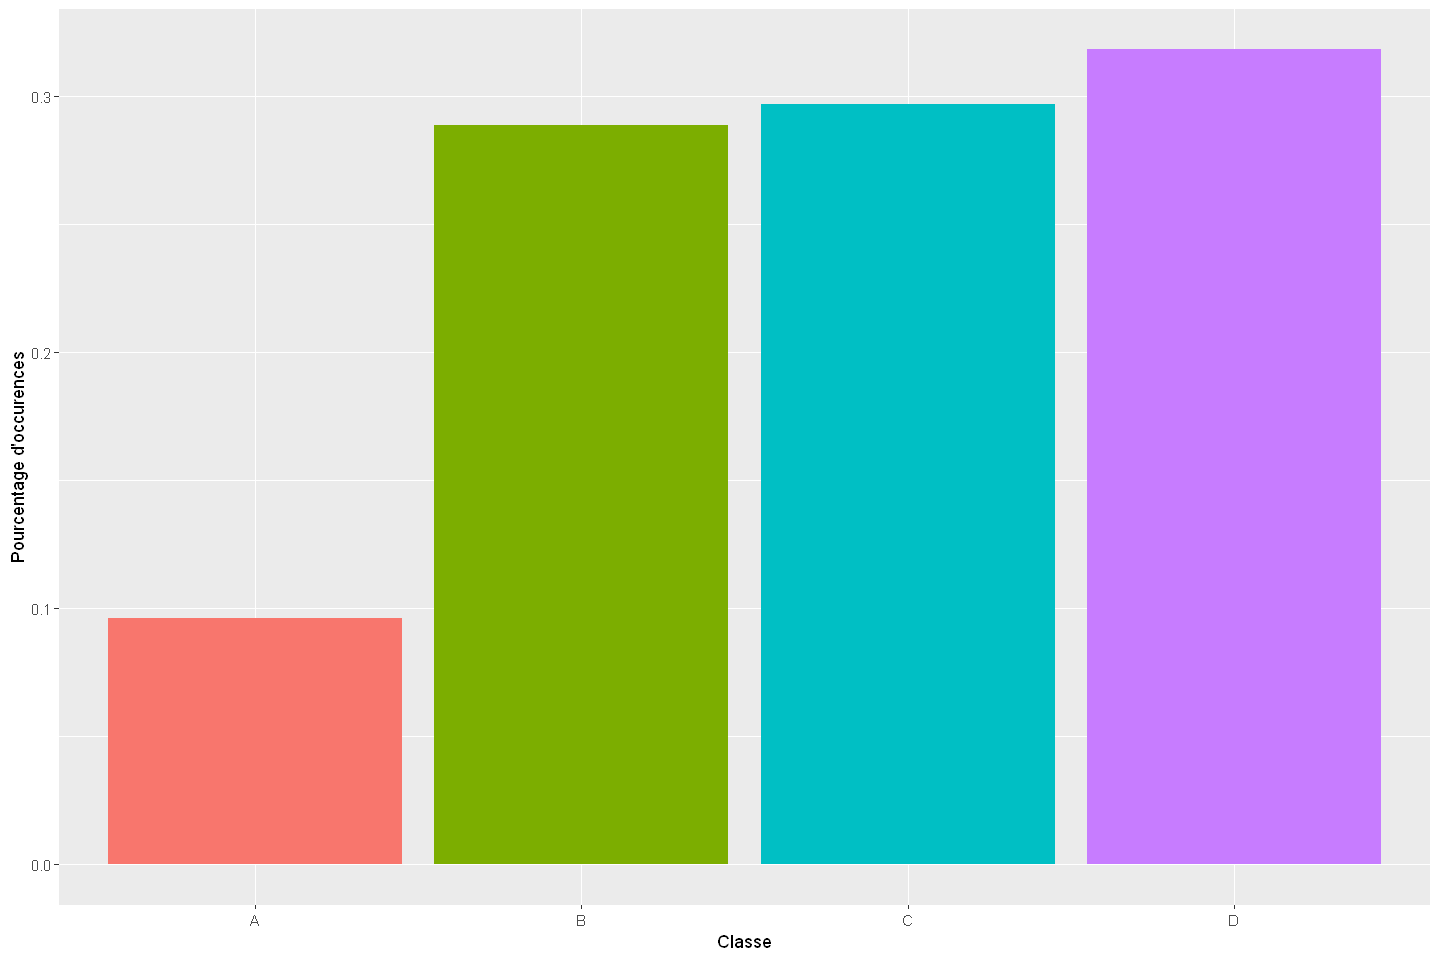

In [12]:
percentage <- as.data.frame(table(pop.class))
percentage$Freq <- percentage$Freq/sum(percentage$Freq)

pop.class.count <- data.frame(name = levels(pop.class), value = percentage$Freq)

options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(data = pop.class.count, aes(x = name, y = value, fill = name)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    labs(x = "Classe", y = "Pourcentage d'occurences")

On voit qu'il y a une distribution uniforme des chansons par classe, sauf pour la classe `A`, qui comprend moins de 10% des chansons. Ceci risque de poser problème dans la suite en termes de prédiction.

<b>Clé</b>

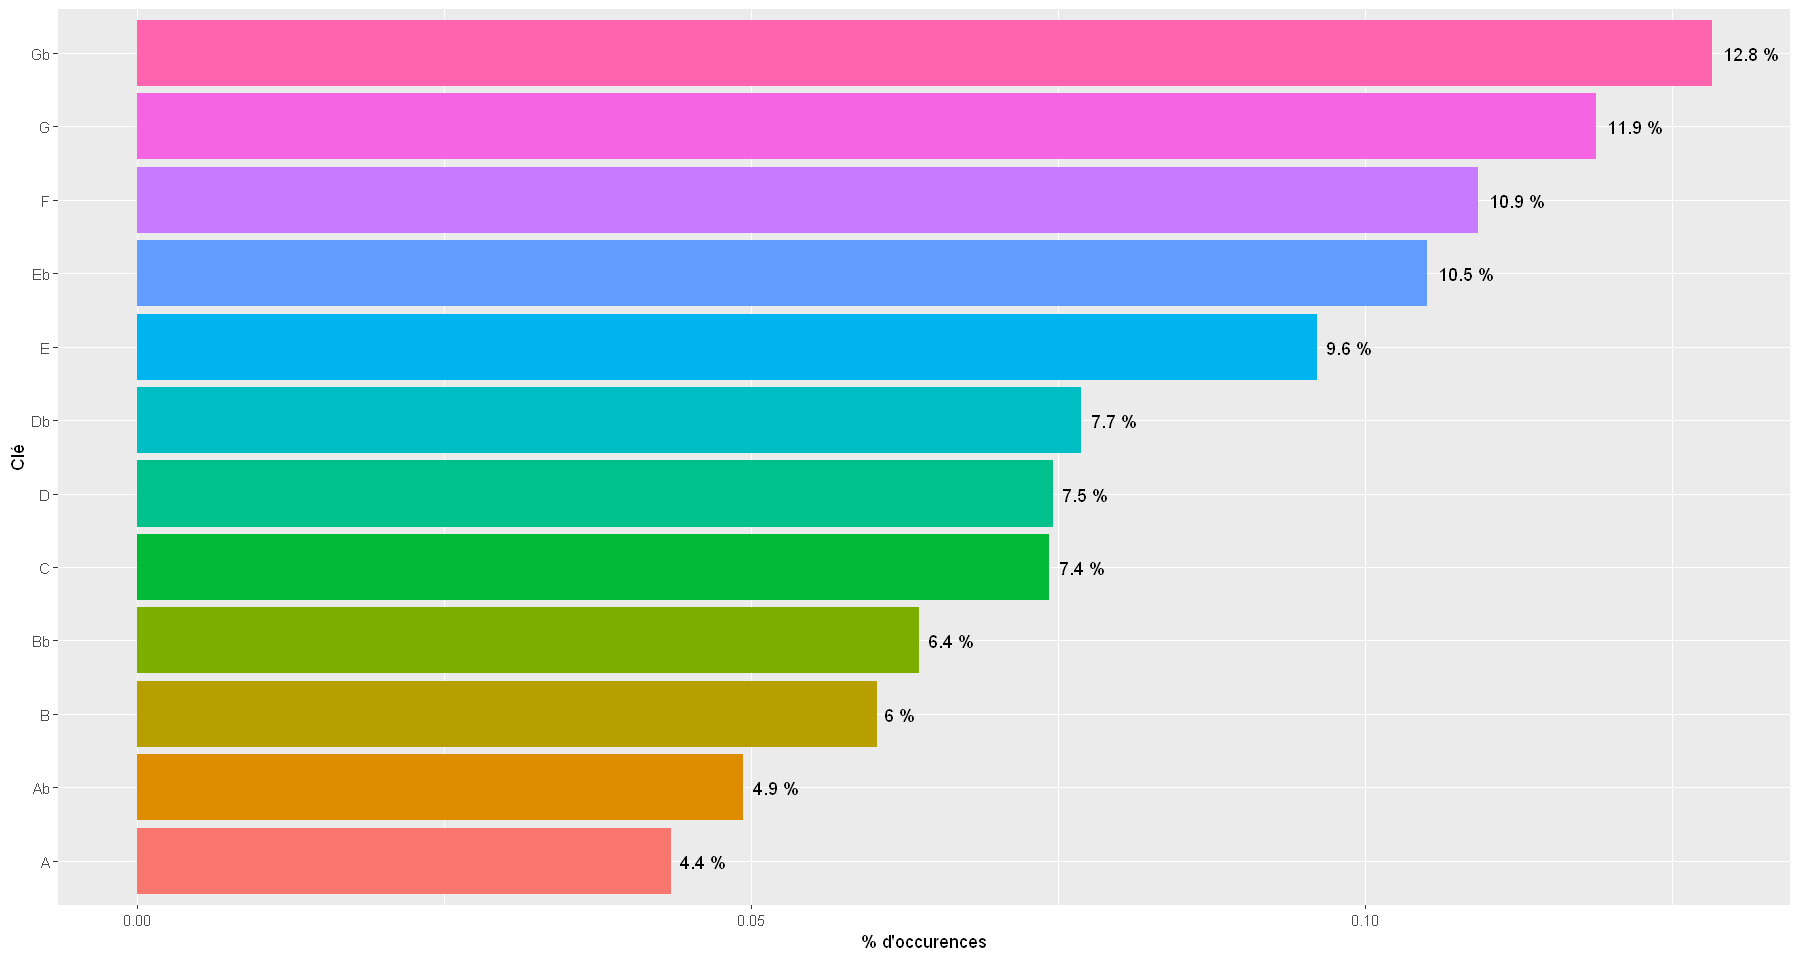

In [13]:
percentage <- as.data.frame(table(key))
percentage$Freq <- sort(percentage$Freq/sum(percentage$Freq), decreasing = F)

key.count <- data.frame(name = levels(key), value = percentage$Freq)

options(repr.plot.width = 15, repr.plot.height = 8)

ggplot(data = key.count, aes(x = name, y = value, fill = name)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    labs(x = "Clé", y = "% d'occurences") +
    geom_text(aes(label = paste(round(value, 3) * 100, "%"), hjust = -0.2)) +
    coord_flip()

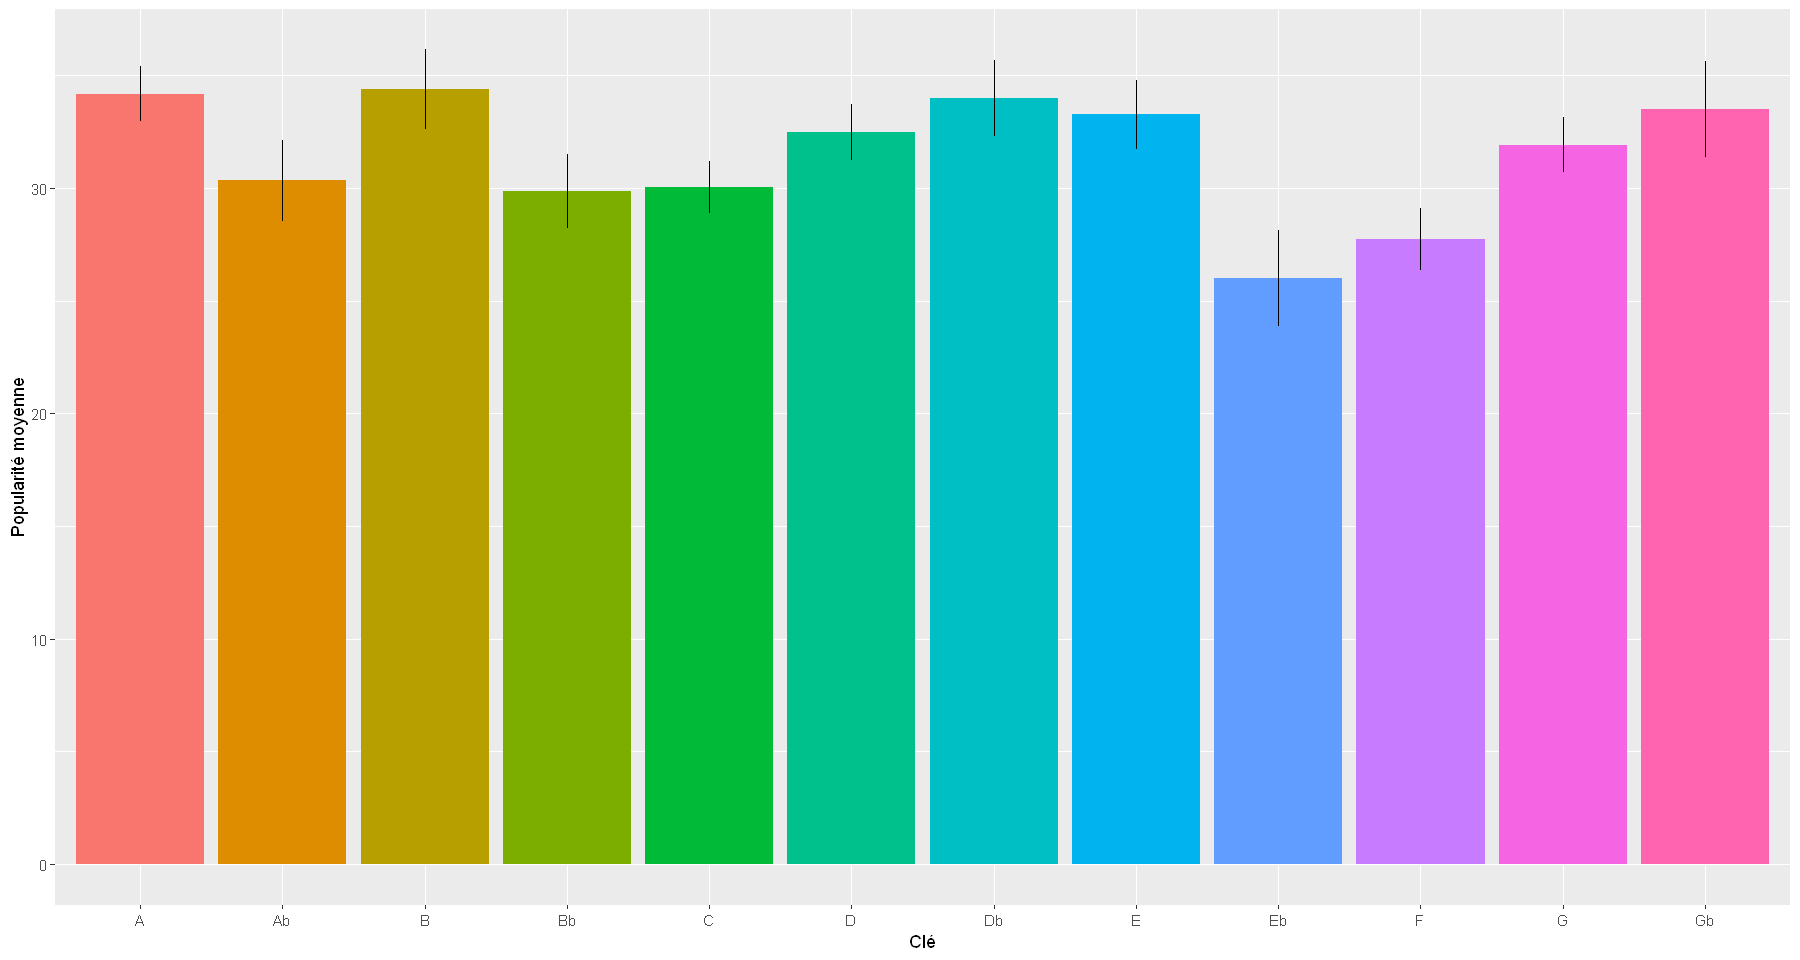

In [14]:
plotdata <- spotify_data %>%
    group_by(key) %>%
    summarize(n = n(), mean = mean(popularity), sd = sd(popularity)) %>%
    mutate(se = sd/sqrt(n)) %>%
    mutate(ic = se * qt((1 - 0.05)/2 + 0.5, n - 1))

ggplot(plotdata, aes(x = key, y = mean, fill = key)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    geom_linerange(aes(x = key, ymin = mean - ic, ymax = mean + ic)) +
    labs(x = "Clé", y = "Popularité moyenne")

Les variances de la popularité dans chacune des valeurs de `key` est petite donc nous n'avons pas besoin de transformer ces données.

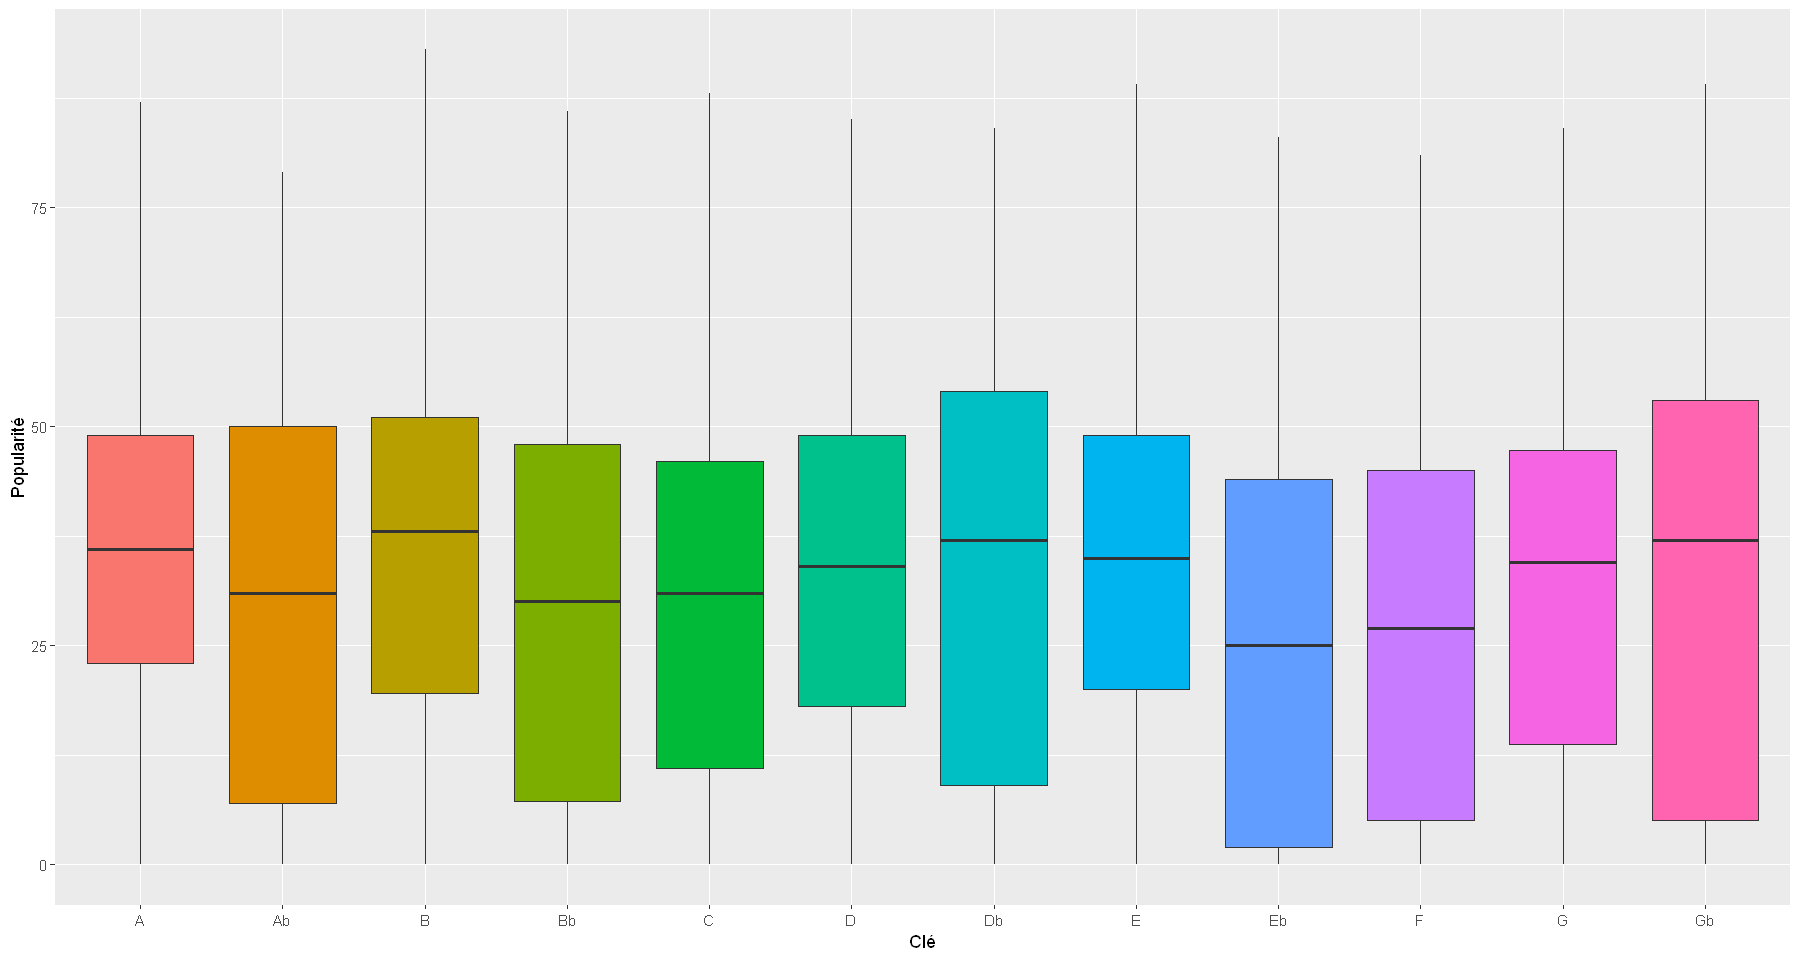

In [15]:
ggplot(data = spotify_data, aes(x = key, y = popularity, fill = key)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Clé", y = "Popularité")

De la même façon, la distribution de la popularité reste plutôt uniforme par clé : les boîtes ont une taille similaire et la médiane est au même niveau.

<b>Mode</b>

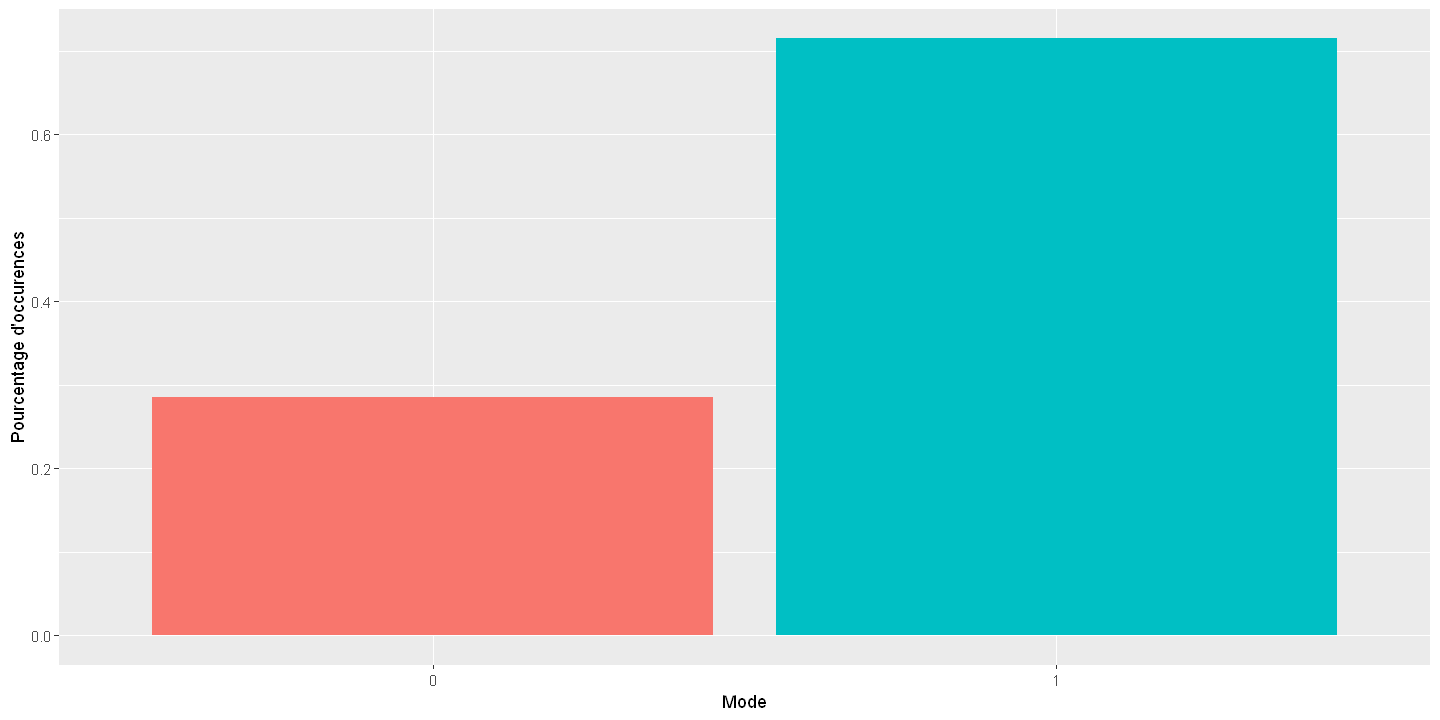

In [16]:
percentage <- as.data.frame(table(mode))
percentage$Freq <- percentage$Freq/sum(percentage$Freq)

mode.count <- data.frame(name = levels(mode), value = percentage$Freq)

options(repr.plot.width = 12, repr.plot.height = 6)

ggplot(data = mode.count, aes(x = name, y = value, fill = name)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    labs(x = "Mode", y = "Pourcentage d'occurences")

La distribution de la variable `mode` est inégale : il y a 30% et 70% des chansons avec `mode` = 0 et `mode` = 1 respectivement.

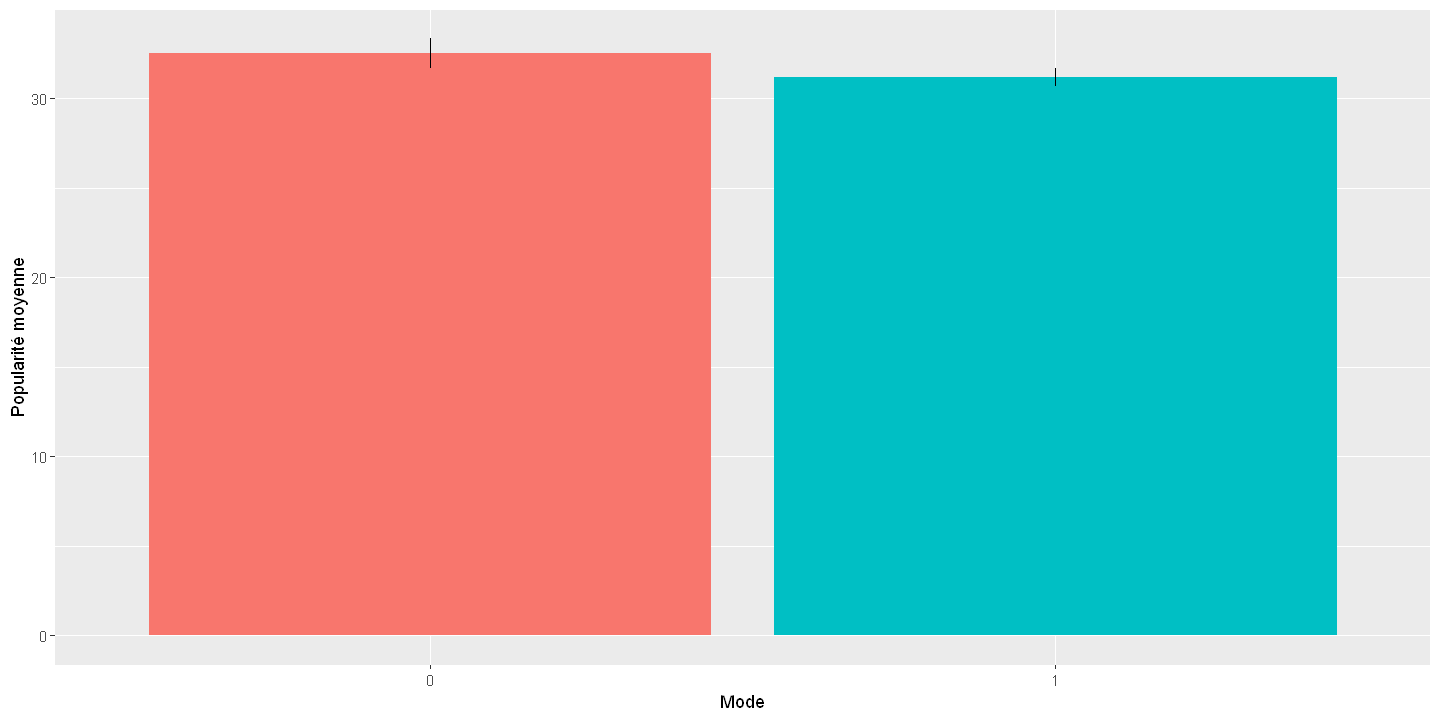

In [17]:
plotdata <- spotify_data %>%
    group_by(mode) %>%
    summarize(n = n(), mean = mean(popularity), sd = sd(popularity)) %>%
    mutate(se = sd/sqrt(n)) %>%
    mutate(ic = se * qt((1 - 0.05)/2 + 0.5, n - 1))

ggplot(plotdata, aes(x = mode, y = mean, fill = mode)) +
    geom_bar(stat = "identity", show.legend = FALSE) +
    geom_linerange(aes(x = mode, ymin = mean - ic, ymax = mean + ic)) +
    labs(x = "Mode", y = "Popularité moyenne")

Par contre, la popularité est similaire selon le mode.

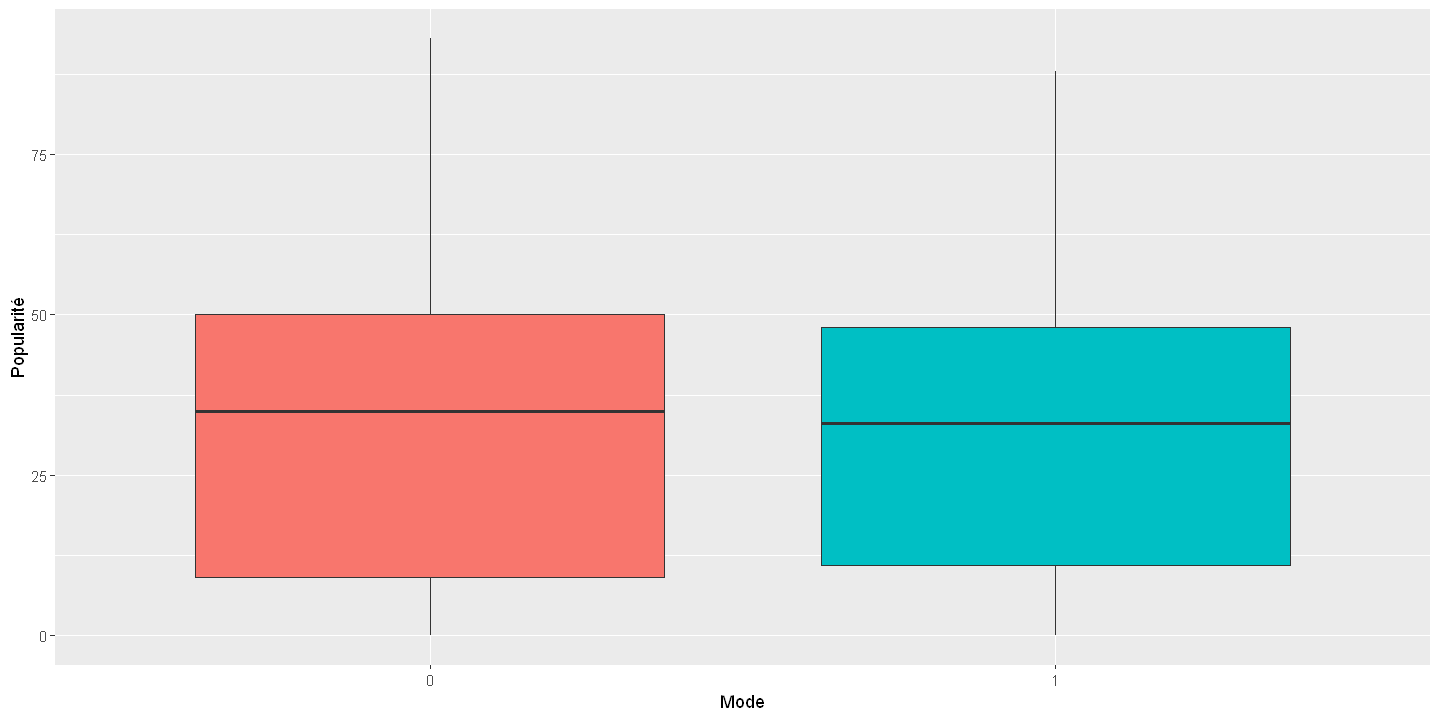

In [18]:
ggplot(data = spotify_data, aes(x = mode, y = popularity, fill = mode)) +
    geom_boxplot(show.legend = FALSE) +
    labs(x = "Mode", y = "Popularité")

On regroupe toutes les variables qualitatives en un barplot :

`summarise()` has grouped output by 'key'. You can override using the `.groups` argument.



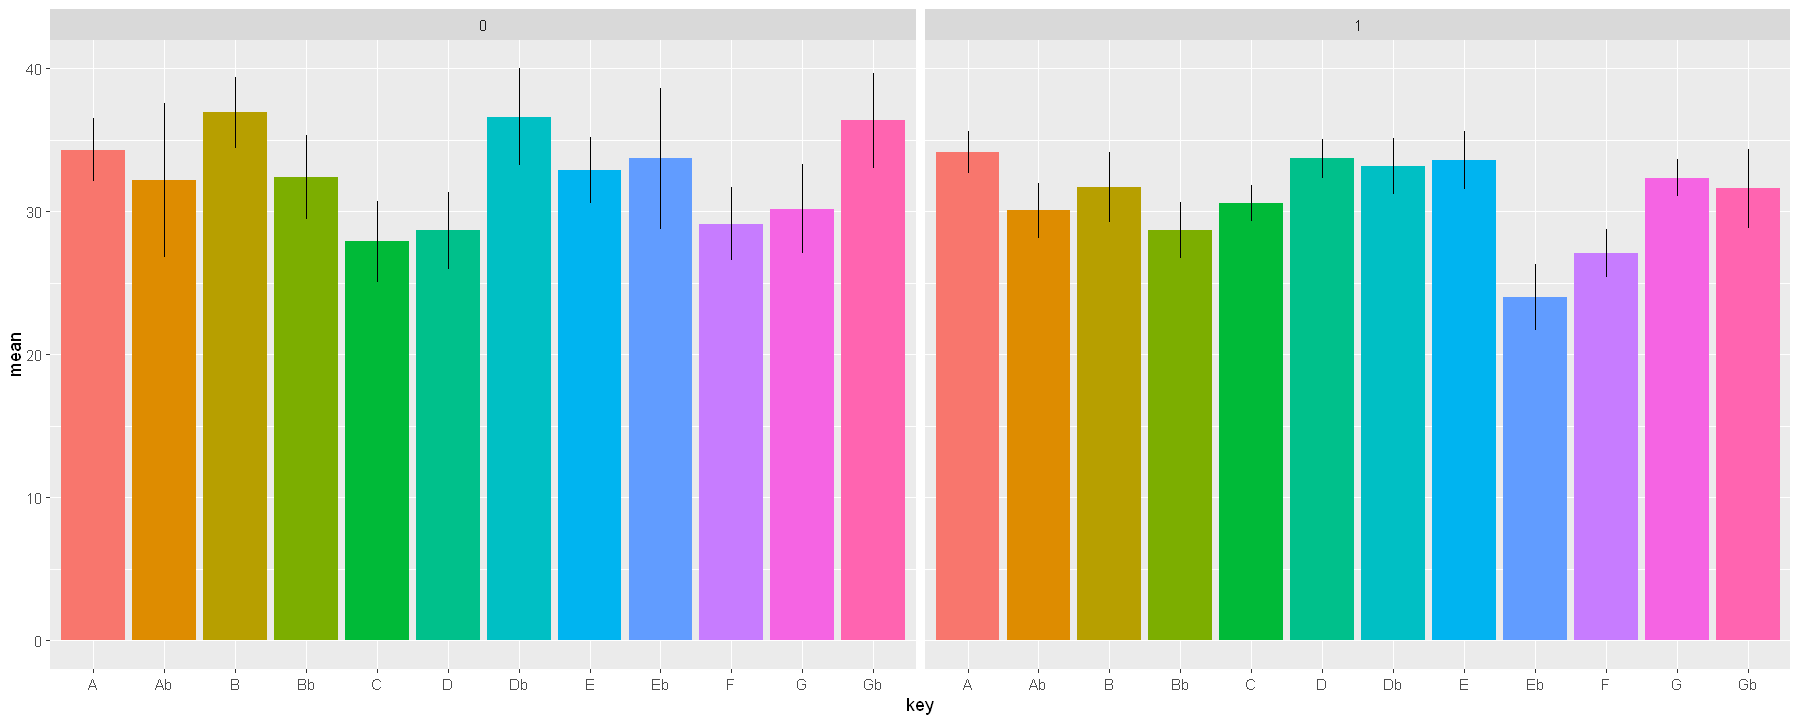

In [19]:
plotdata <- spotify_data %>%
    group_by(key, mode) %>%
    summarize(n = n(), mean = mean(popularity), sd = sd(popularity)) %>%
    mutate(se = sd/sqrt(n)) %>%
    mutate(ic = se * qt((1 - 0.05)/2 + 0.5, n - 1))

options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(data = plotdata, aes(x = key, y = mean, fill = key)) +
    geom_bar(position="dodge", stat="identity", show.legend = FALSE) +
    geom_linerange(aes(x = key, ymin = mean - ic, ymax = mean + ic)) +
    facet_wrap(~mode)

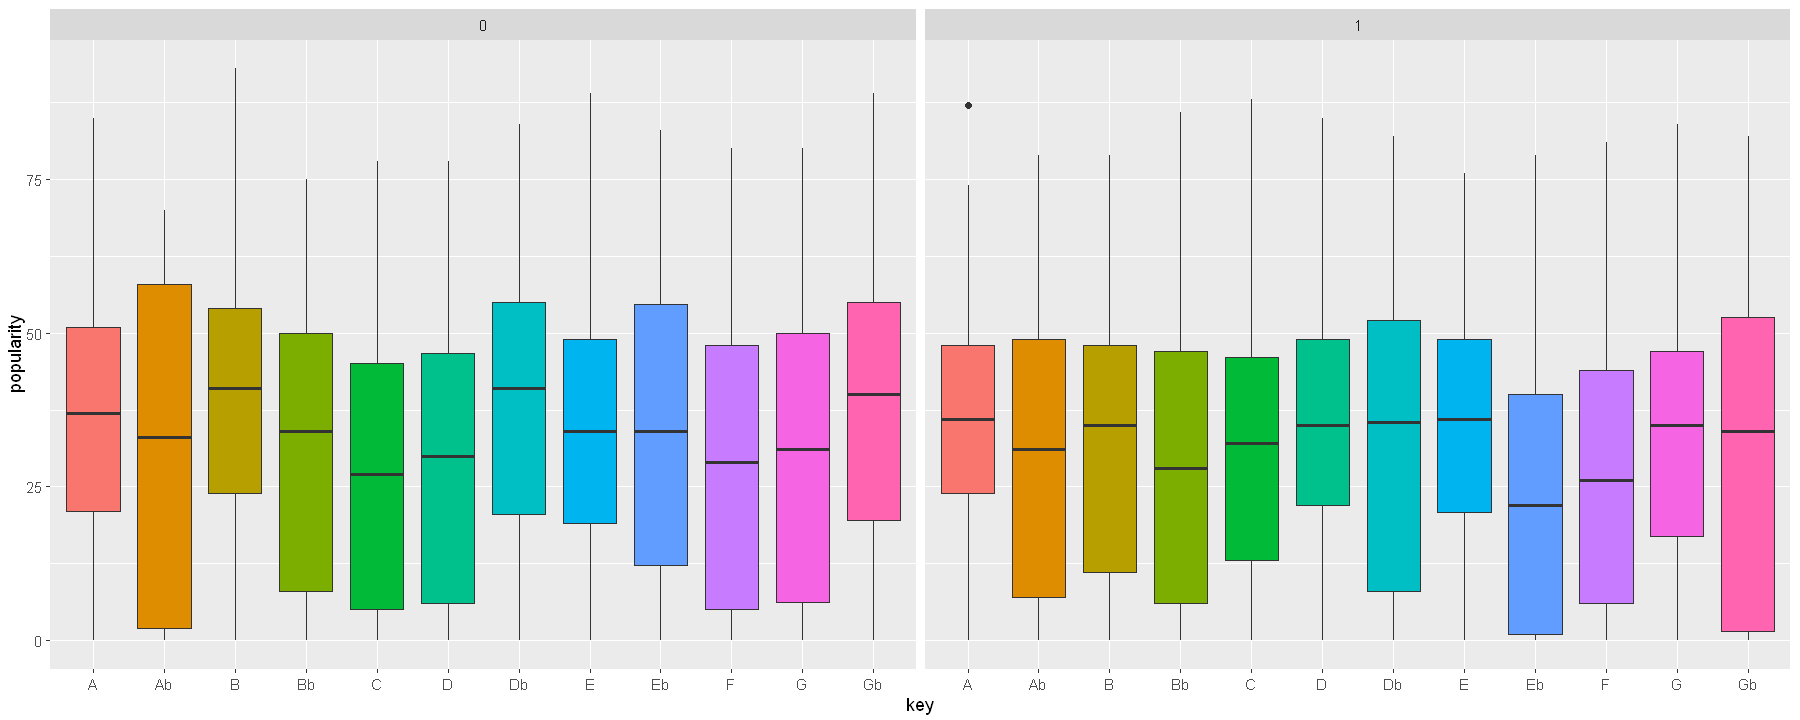

In [20]:
options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(data = spotify_data, aes(x = key, y = popularity, fill = key)) +
    geom_boxplot(show.legend = FALSE) +
    facet_wrap(~mode)

## Variables quantitatives

On commence par visualiser la corrélation entre les variables quantitatives :

In [21]:
data.quant <- spotify_data[, -c(8, 11, 15)]
colnames(data.quant)

[1] "valence"          "year"             "acousticness"     "danceability"    
 [5] "duration"         "energy"           "instrumentalness" "liveness"        
 [9] "loudness"         "popularity"       "speechiness"      "tempo"

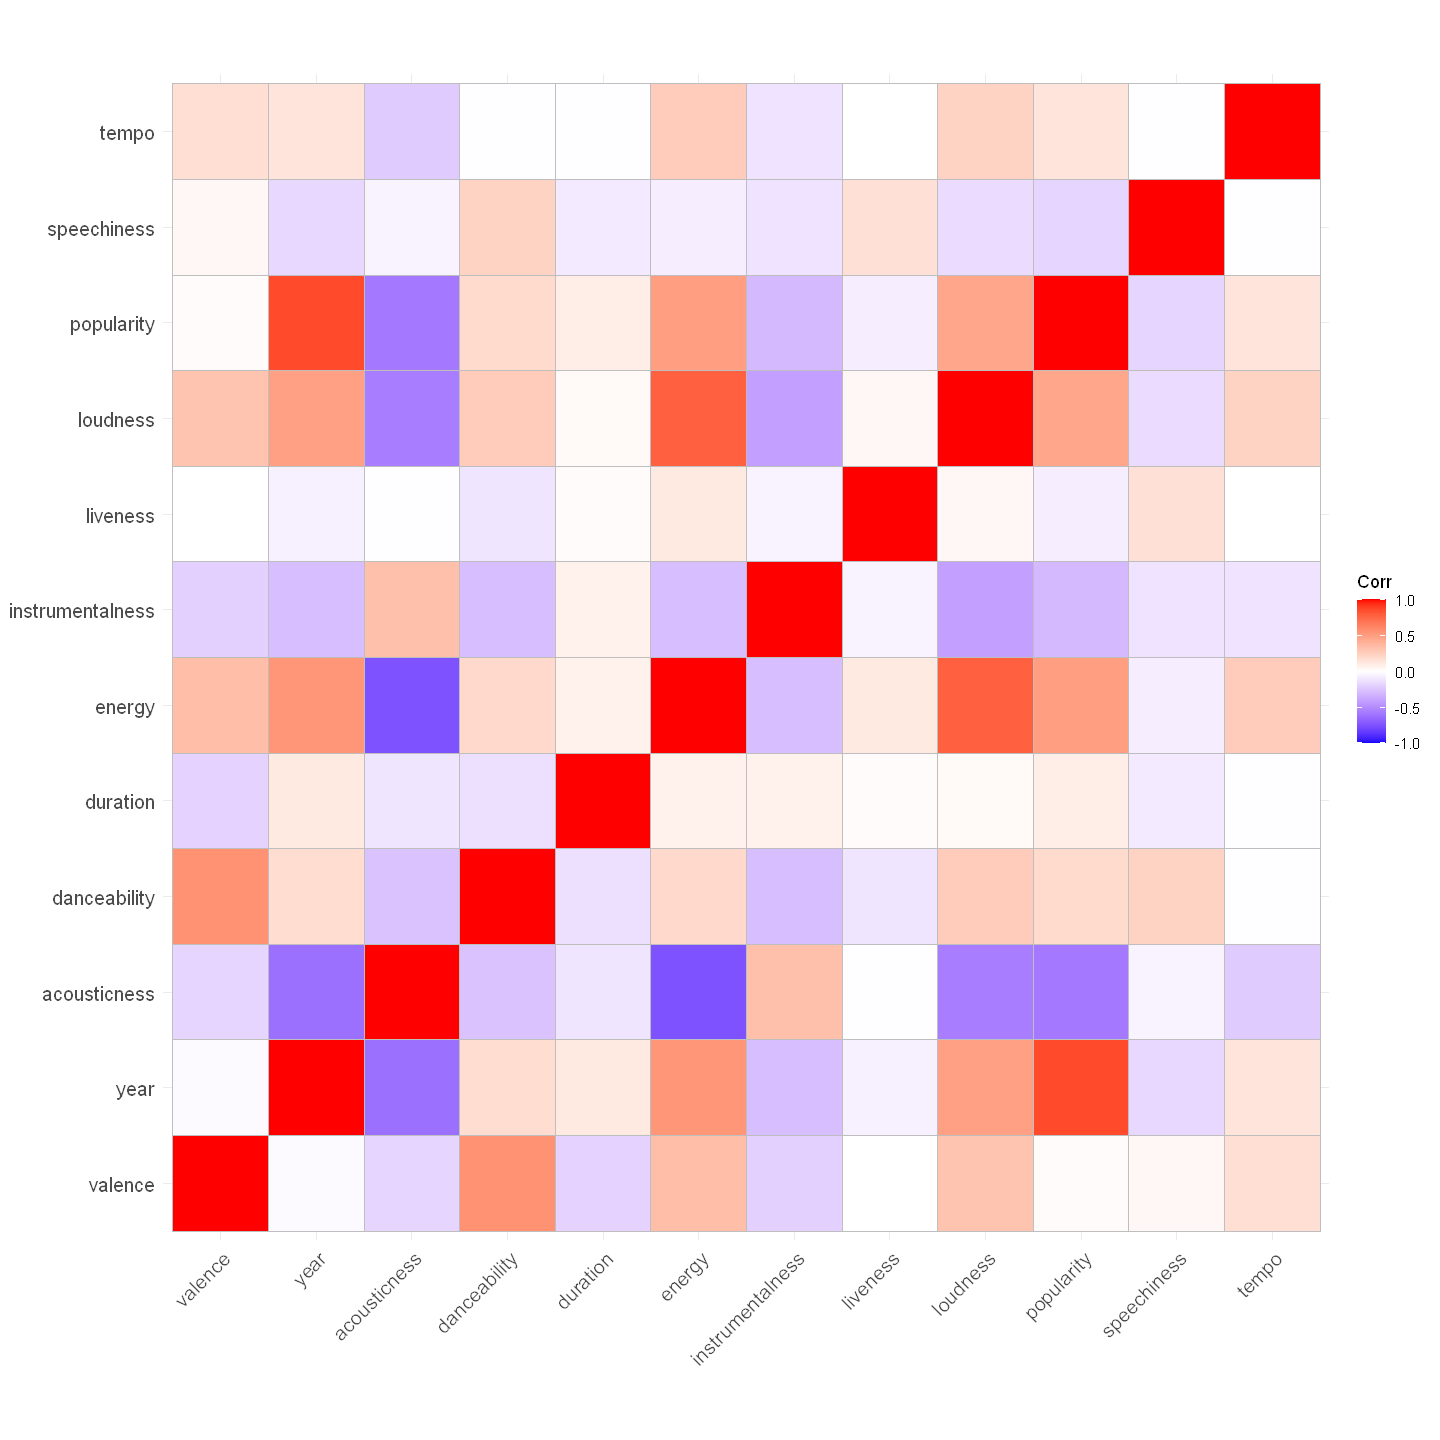

In [22]:
library(ggcorrplot)

options(repr.plot.width = 12, repr.plot.height = 12)
M <- cor(data.quant)

ggcorrplot(M)

Ce graphique nous montre qu'il y a certaines variables qui ont une forte corrélation. Par exemple, il y a une forte corrélation négative entre les variables `energy` et `acousticness`. Cela a du sens vu que les chansons acoustiques sont plus tranquilles (moins énergiques) que celles qui ne sont pas acoustiques. De même, `energy` et `loudness` sont positivement corrélées, ce qui est attendu vu que les chansons bruyantes ont souvent plus d'énergie.
<br>
On voit aussi que plus une chanson est acoustique, moins elle est populaire, vu que les variables `acousticness` et `popularity` ont une forte corrélation négative.

In [23]:
correlation <- sort(abs(M[, 10]), decreasing = T)
series <- as.data.frame(correlation)

print("Les variables les plus corrélées avec 'popularity' sont :")
for (row in rownames(series)) {
    if (series[row, 1] >= 0.2 && series[row, 1] < 1) {
        print(paste(row, round(series[row, 1], 2), "(abs)"))
    }
}

[1] "Les variables les plus corrélées avec 'popularity' sont :"
[1] "year 0.86 (abs)"
[1] "acousticness 0.58 (abs)"
[1] "energy 0.5 (abs)"
[1] "loudness 0.46 (abs)"
[1] "instrumentalness 0.3 (abs)"


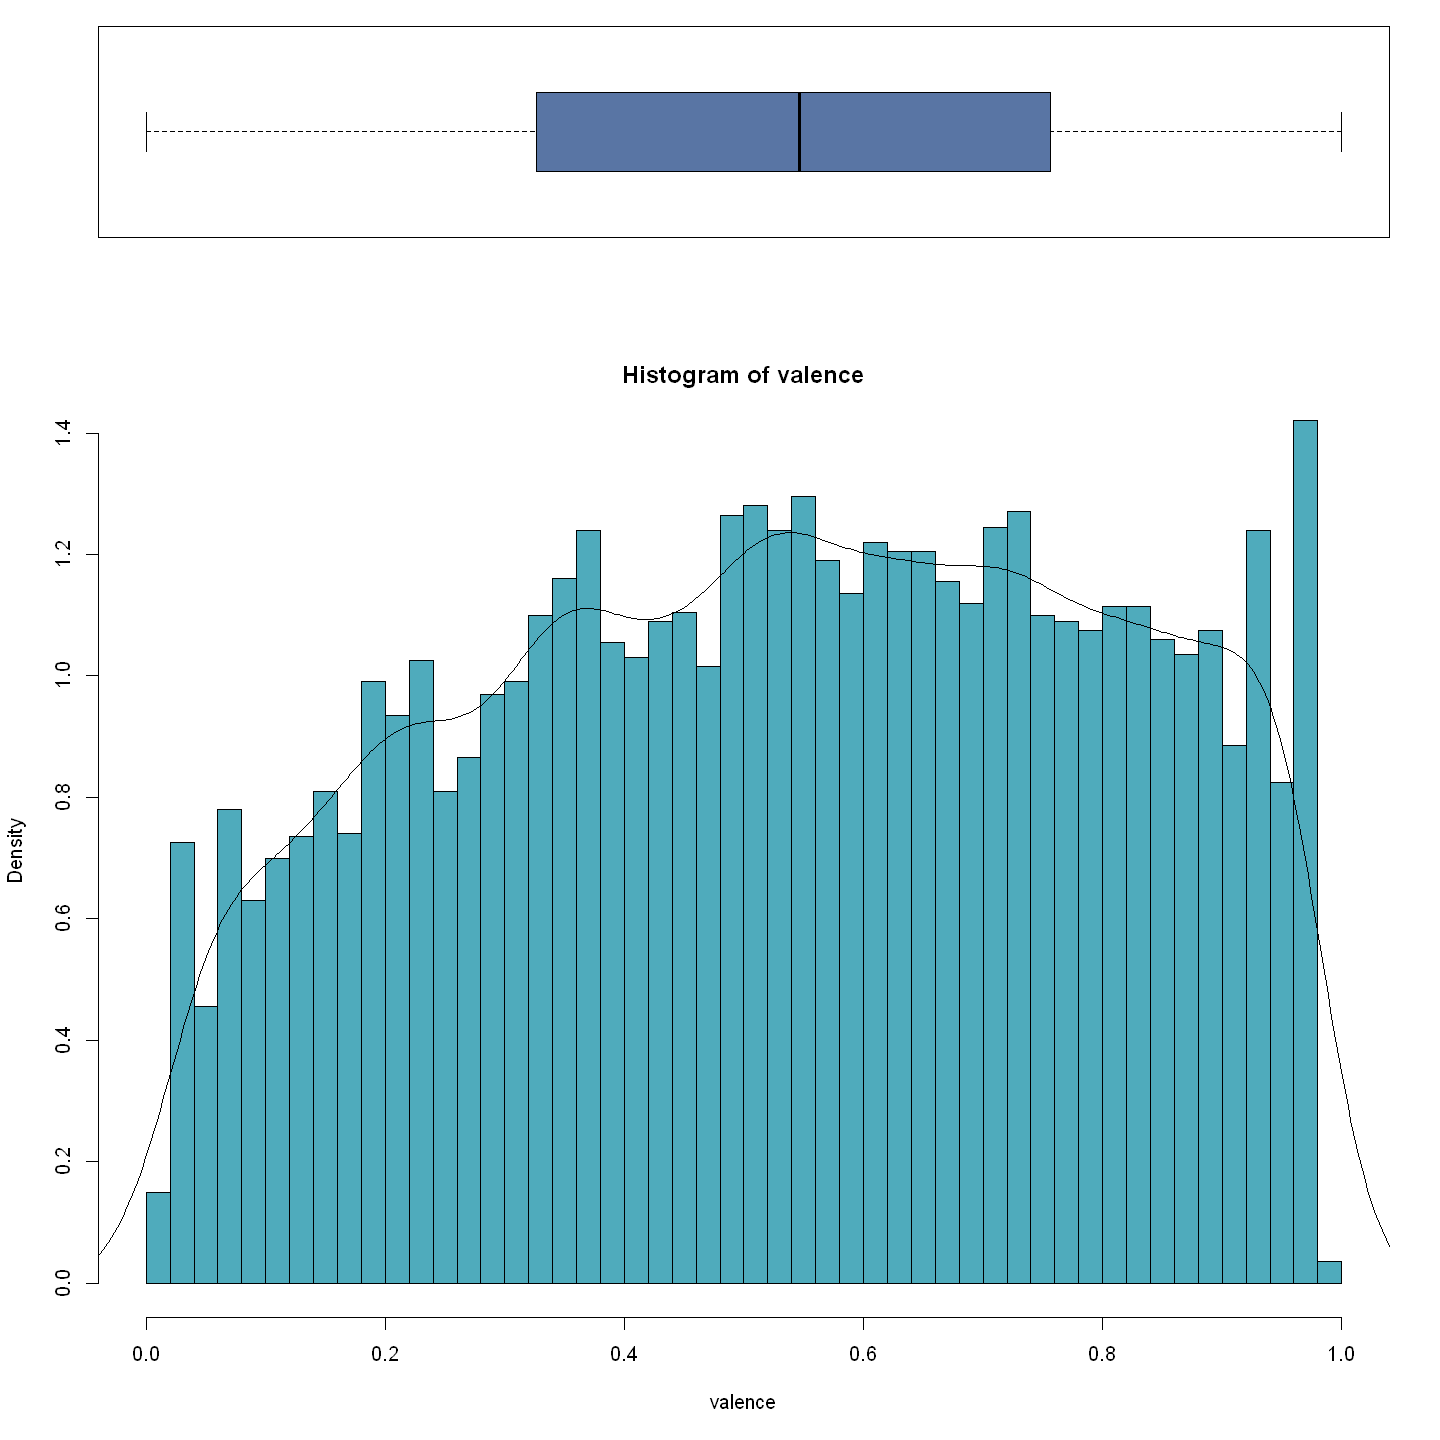

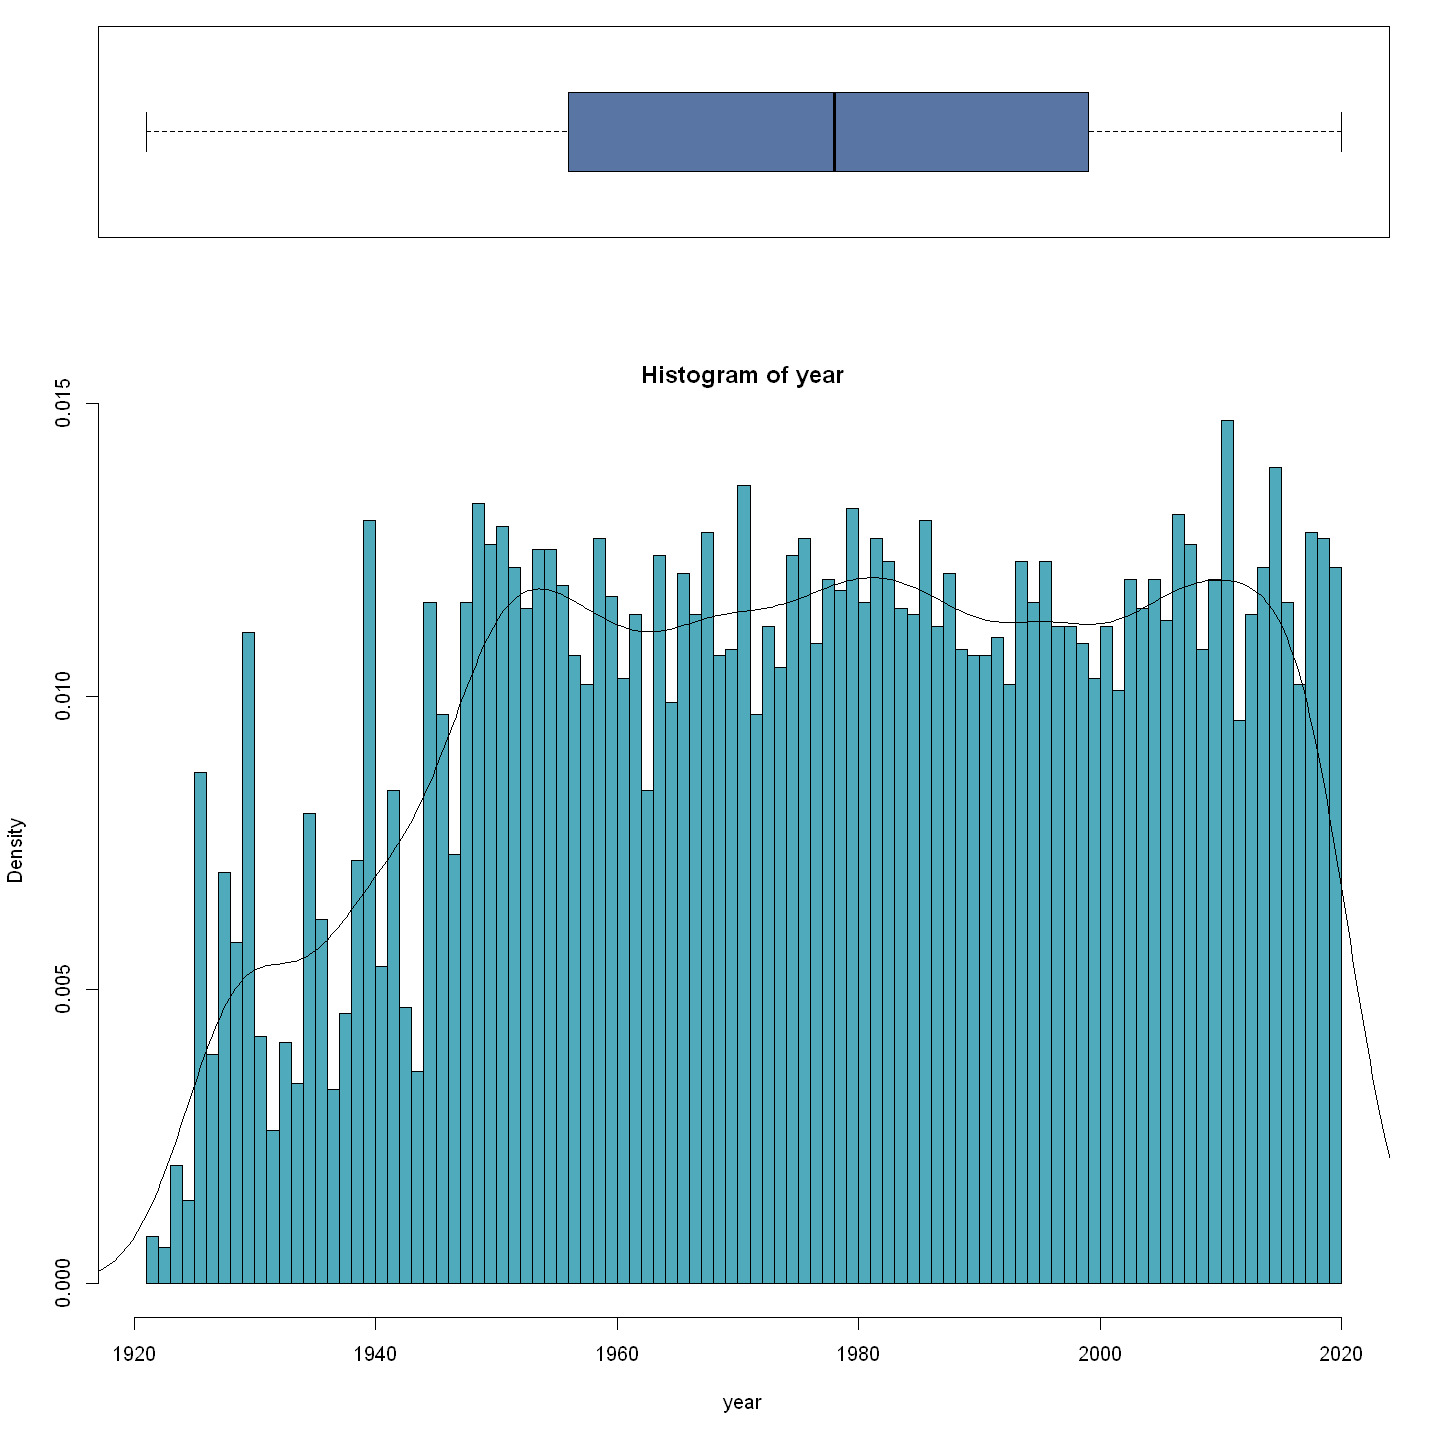

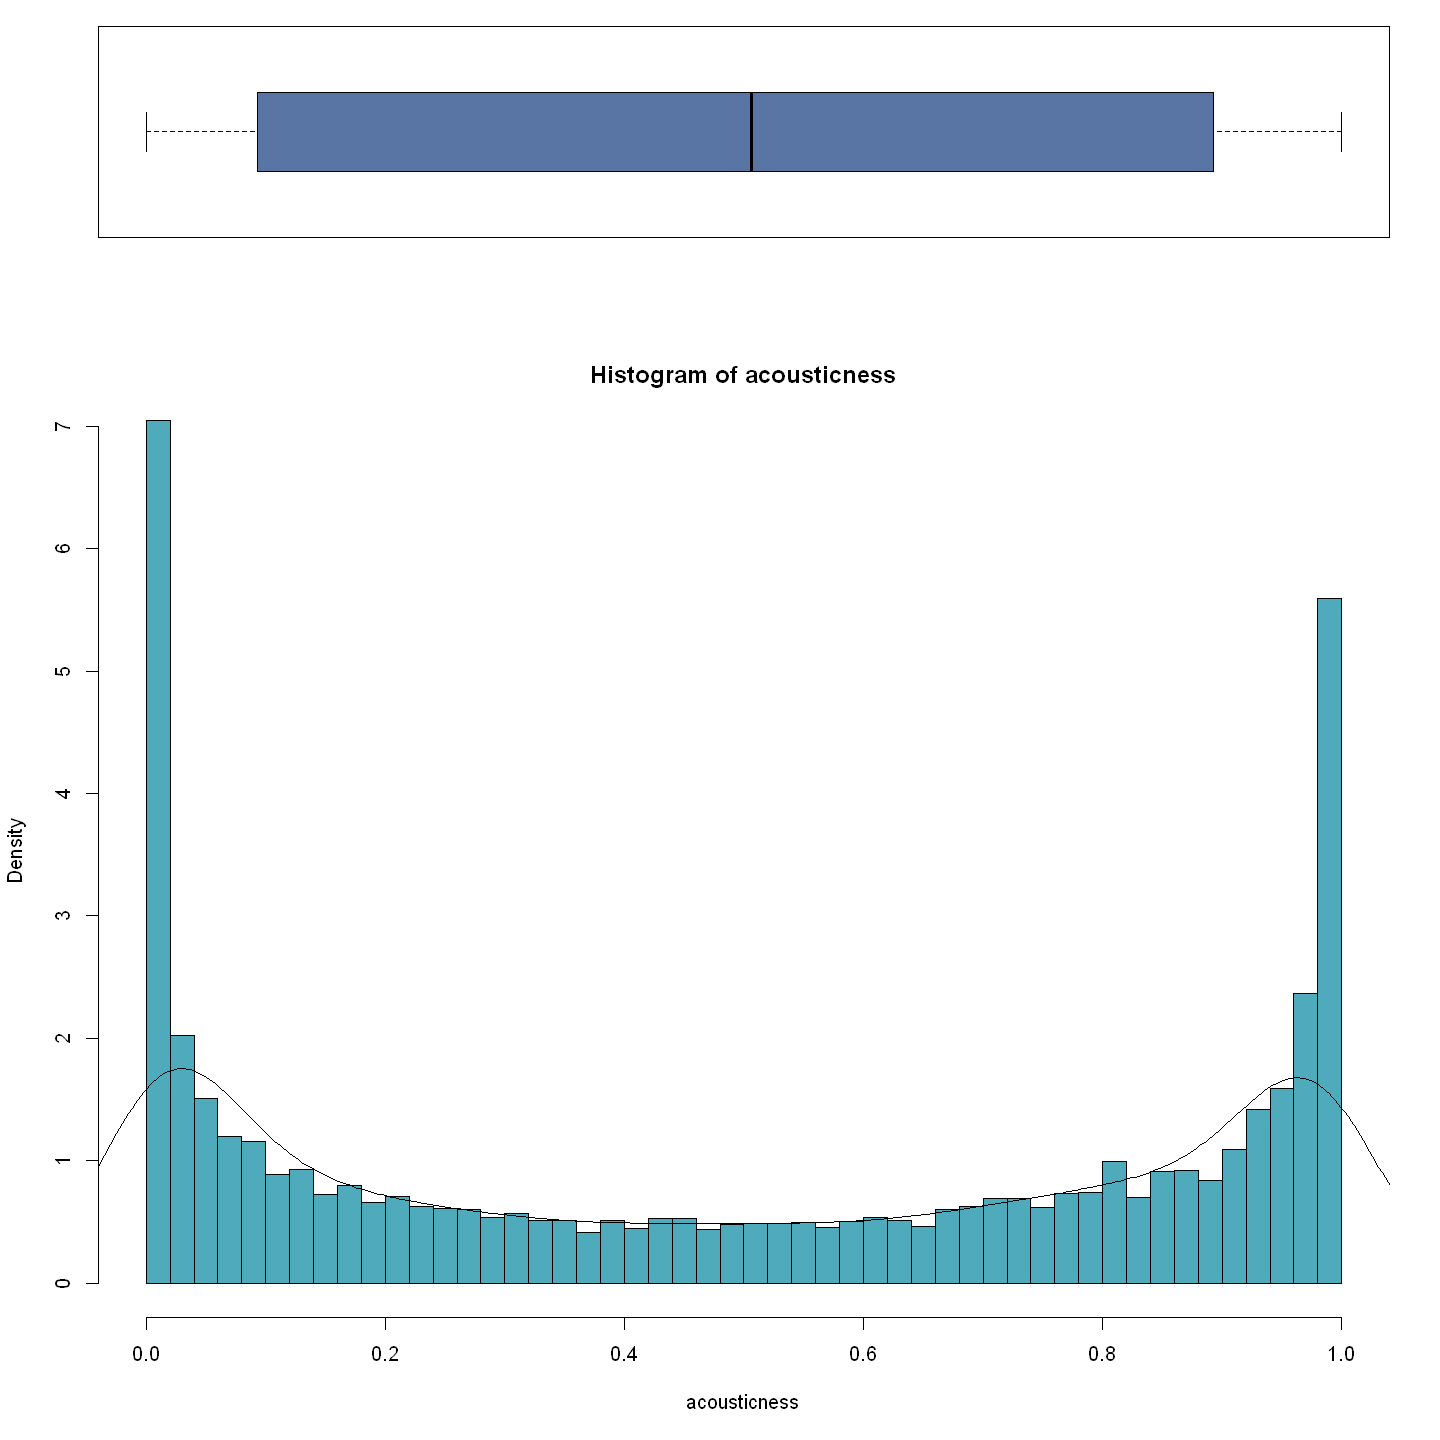

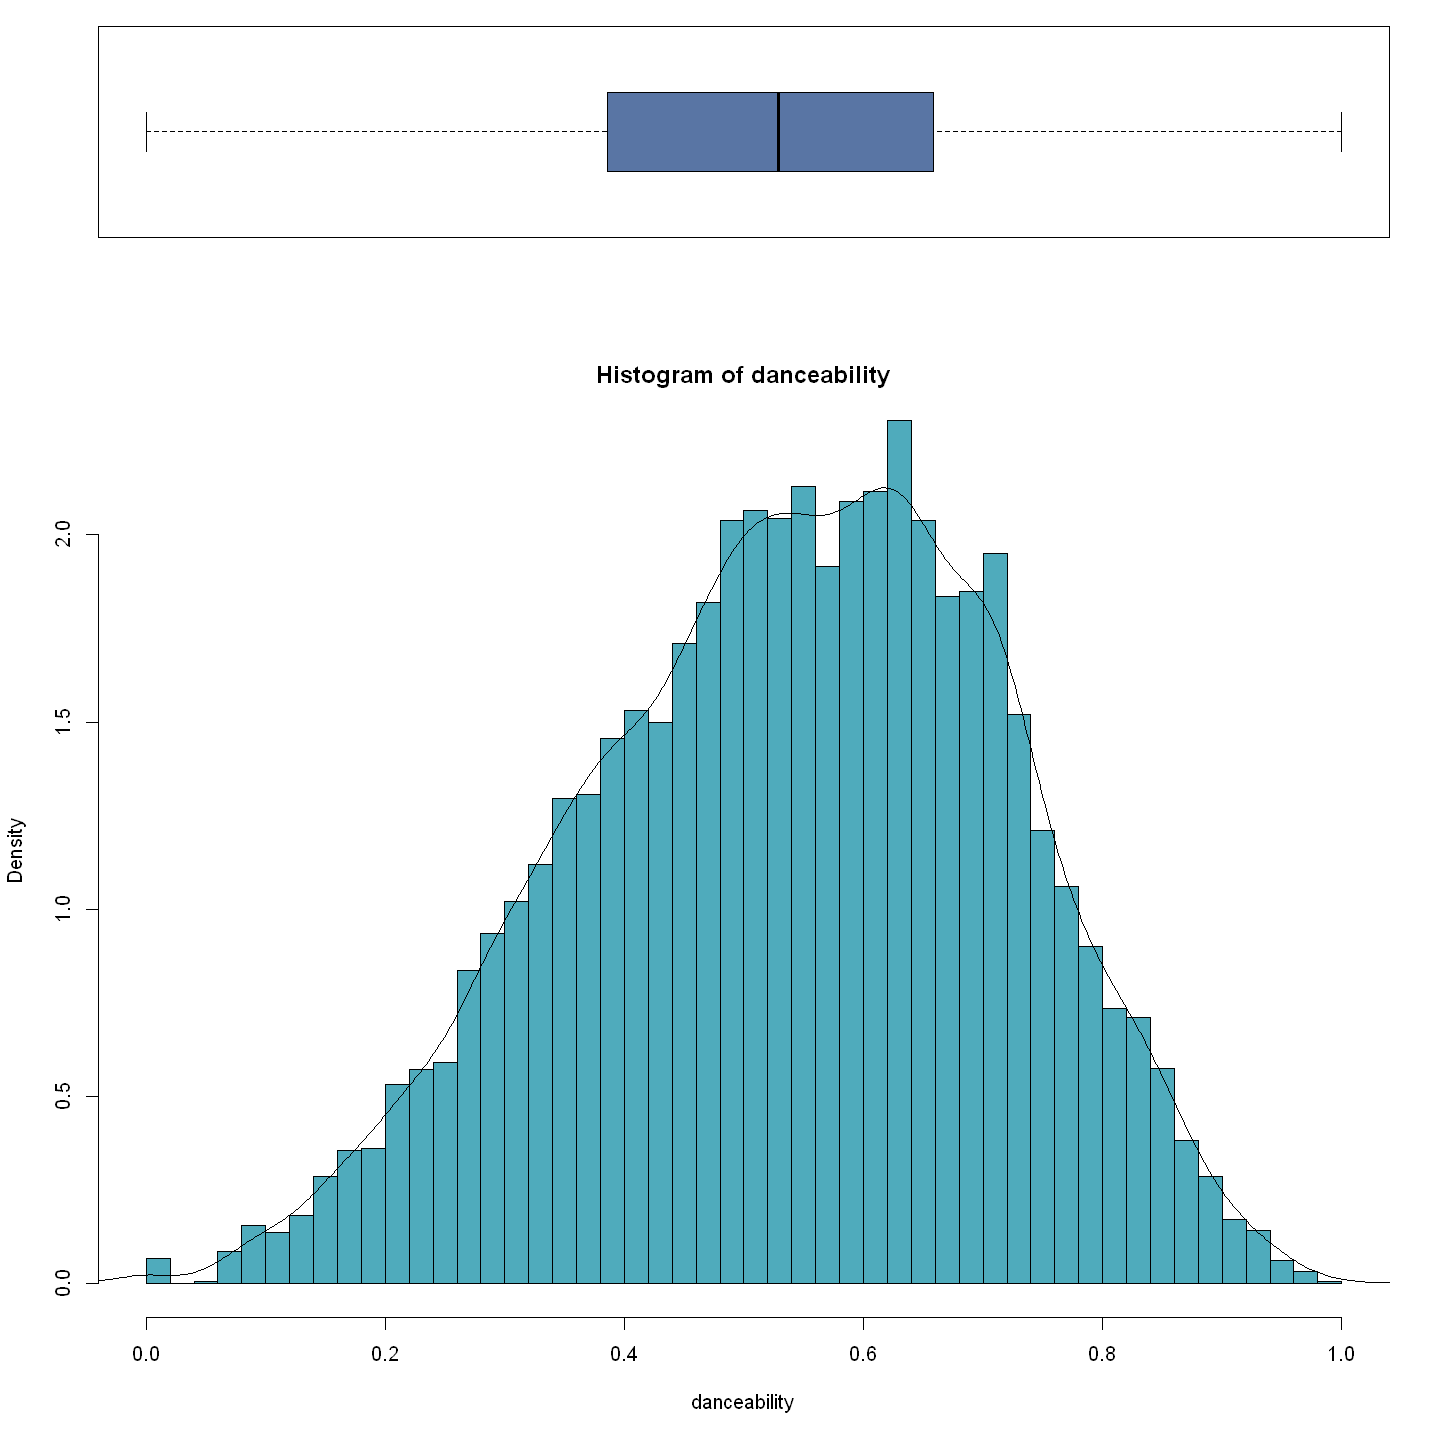

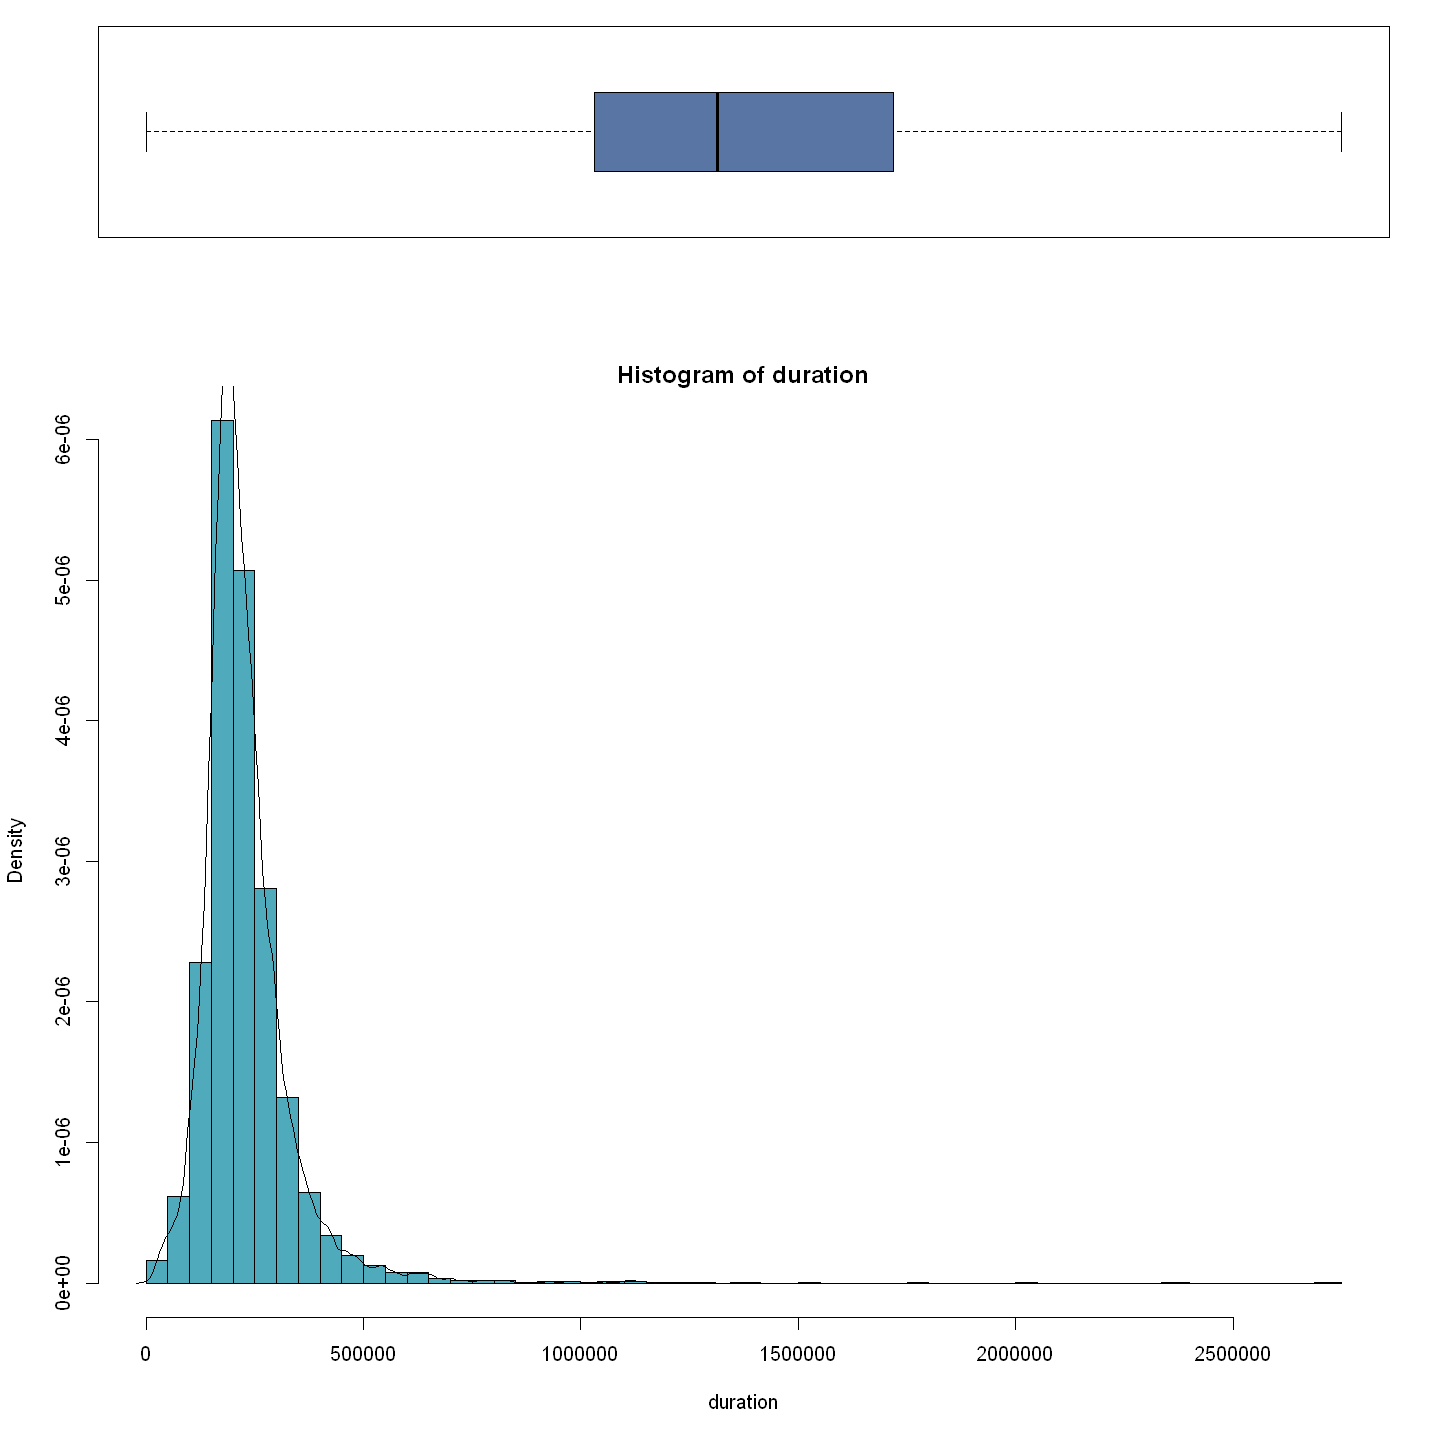

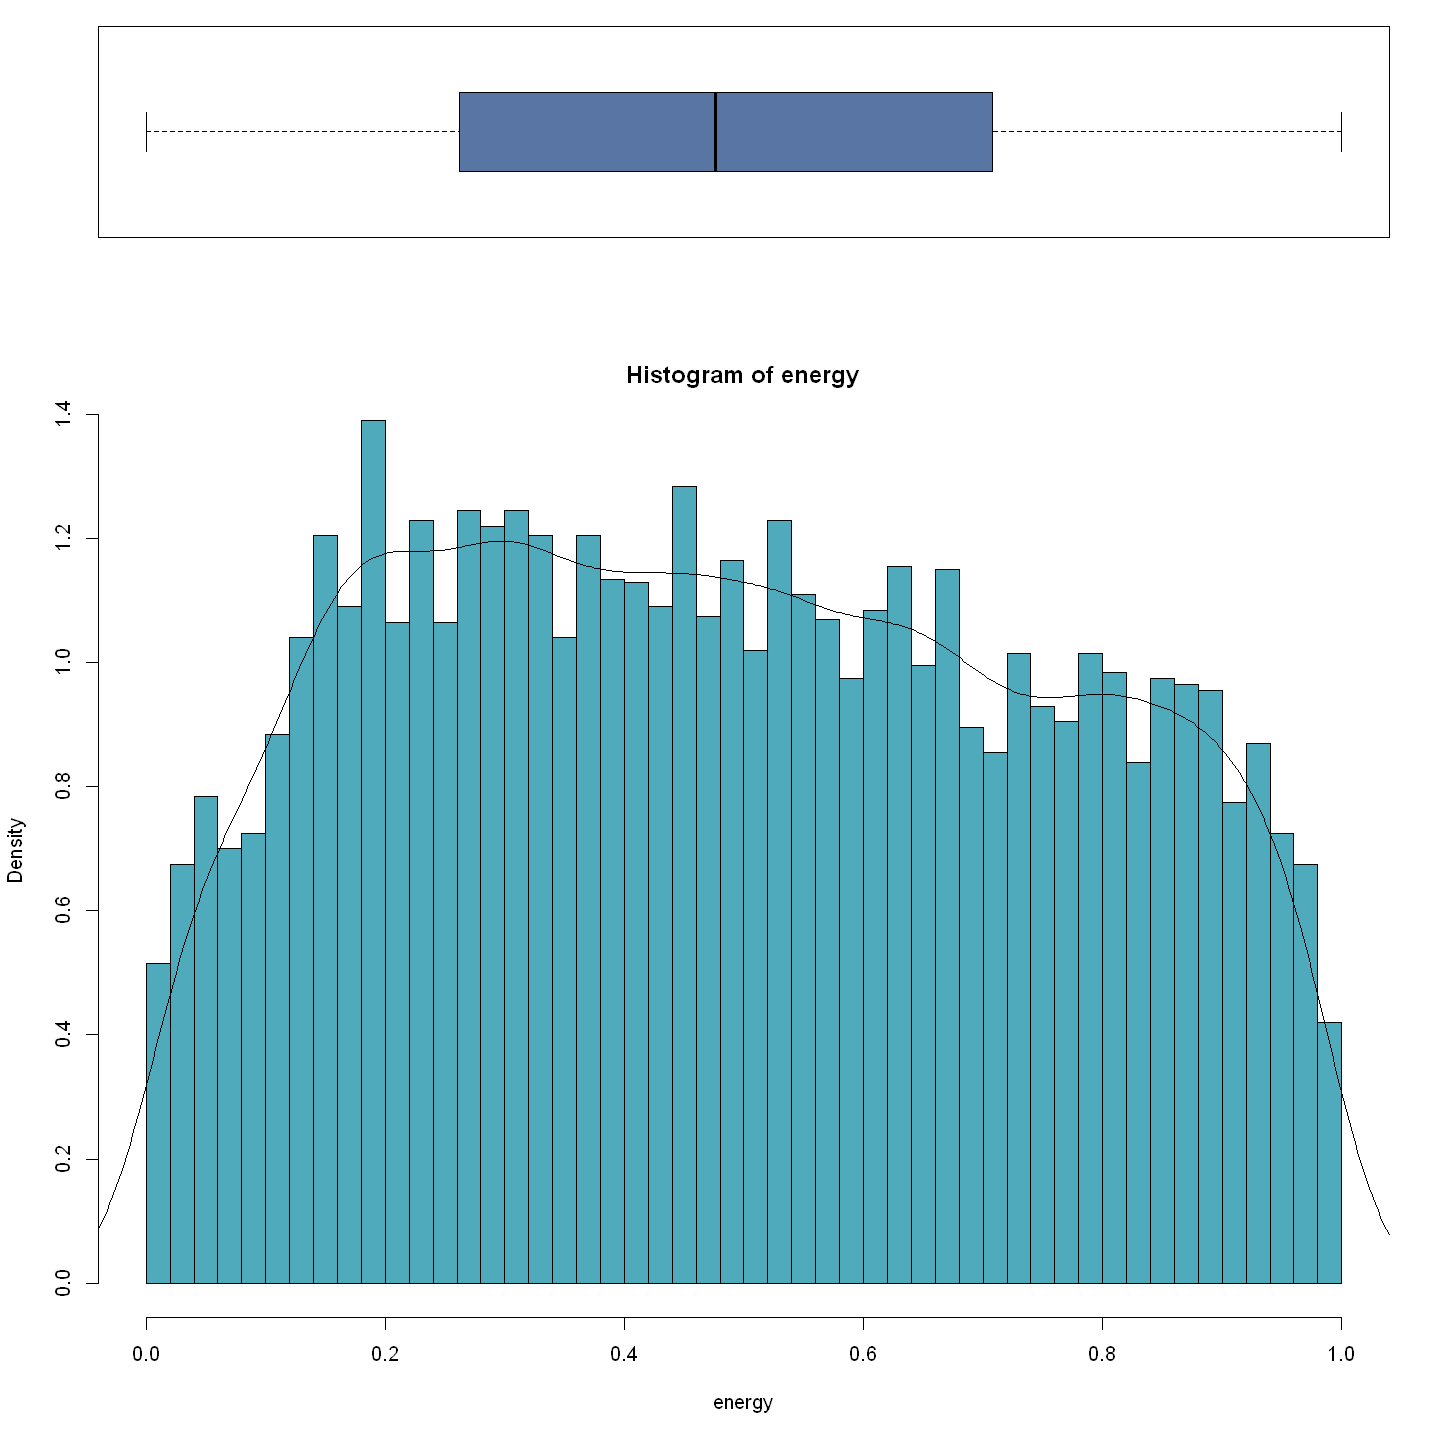

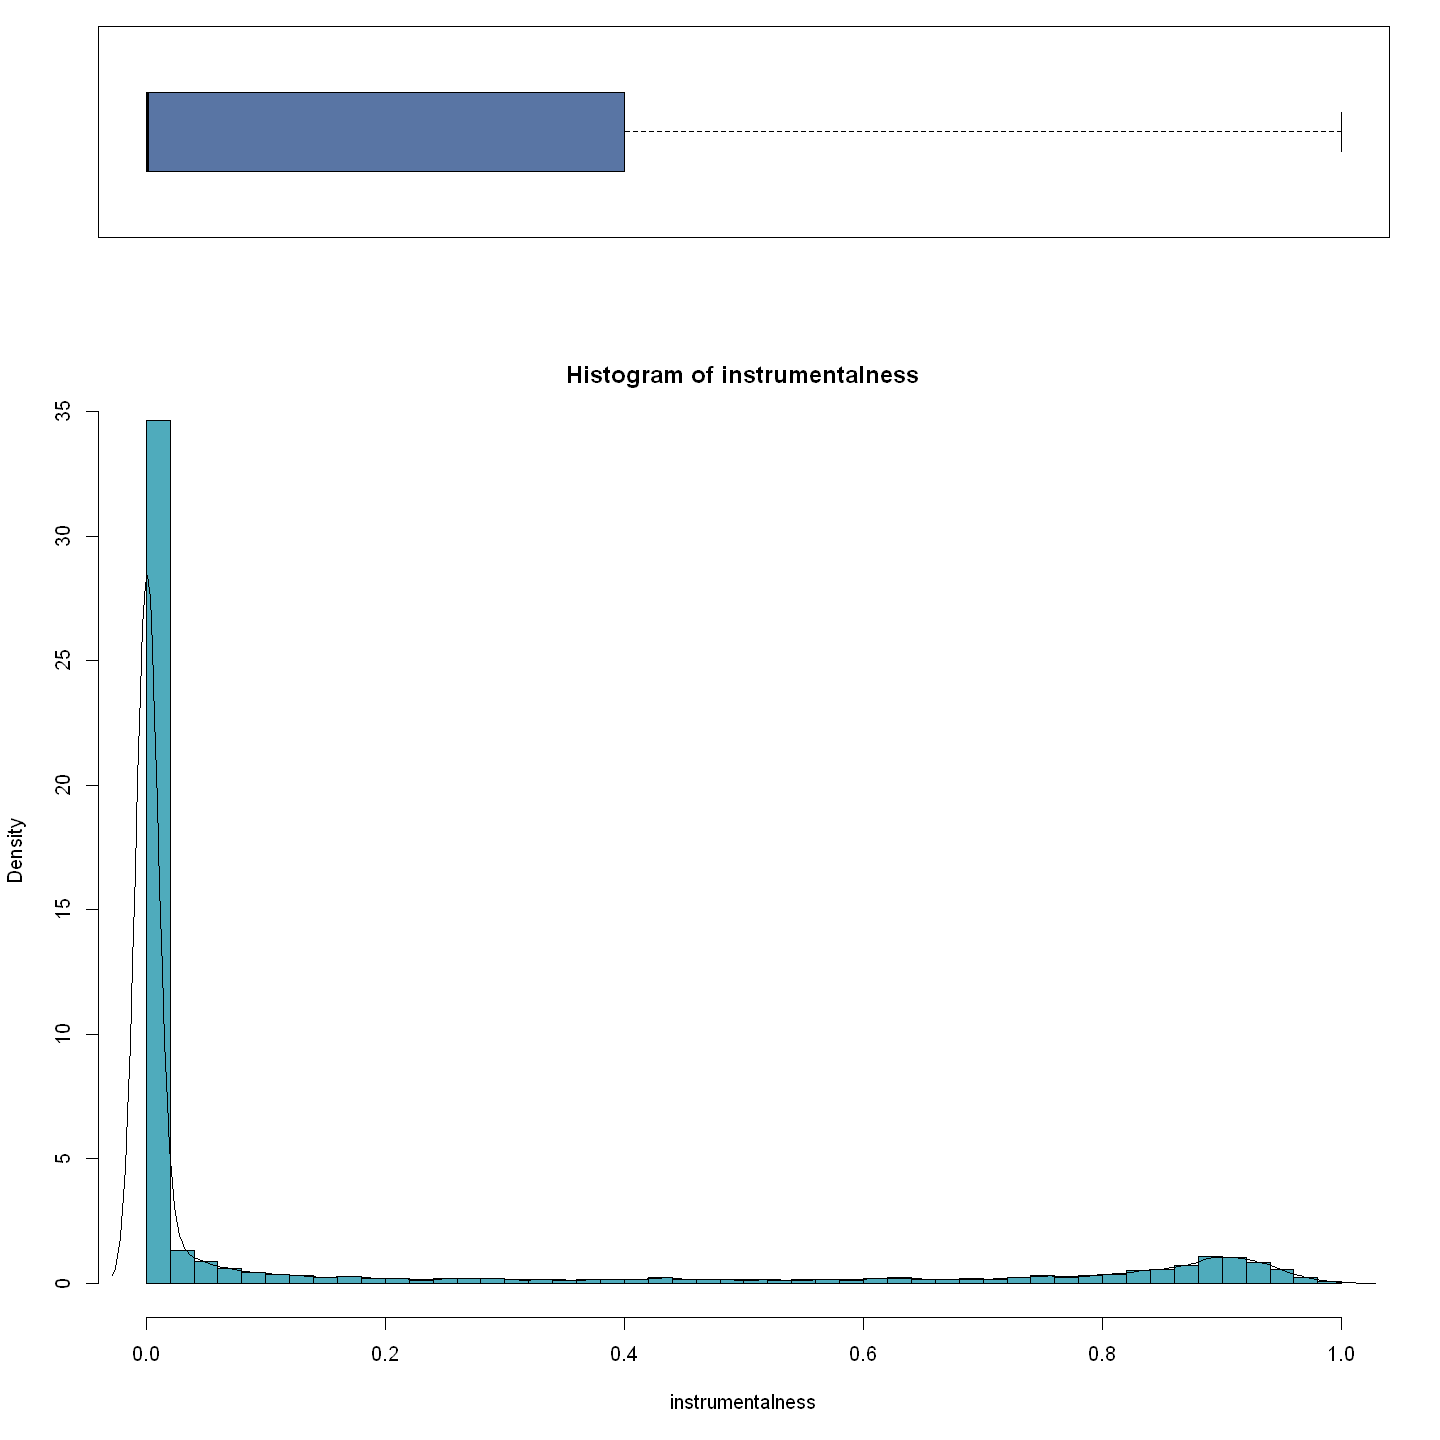

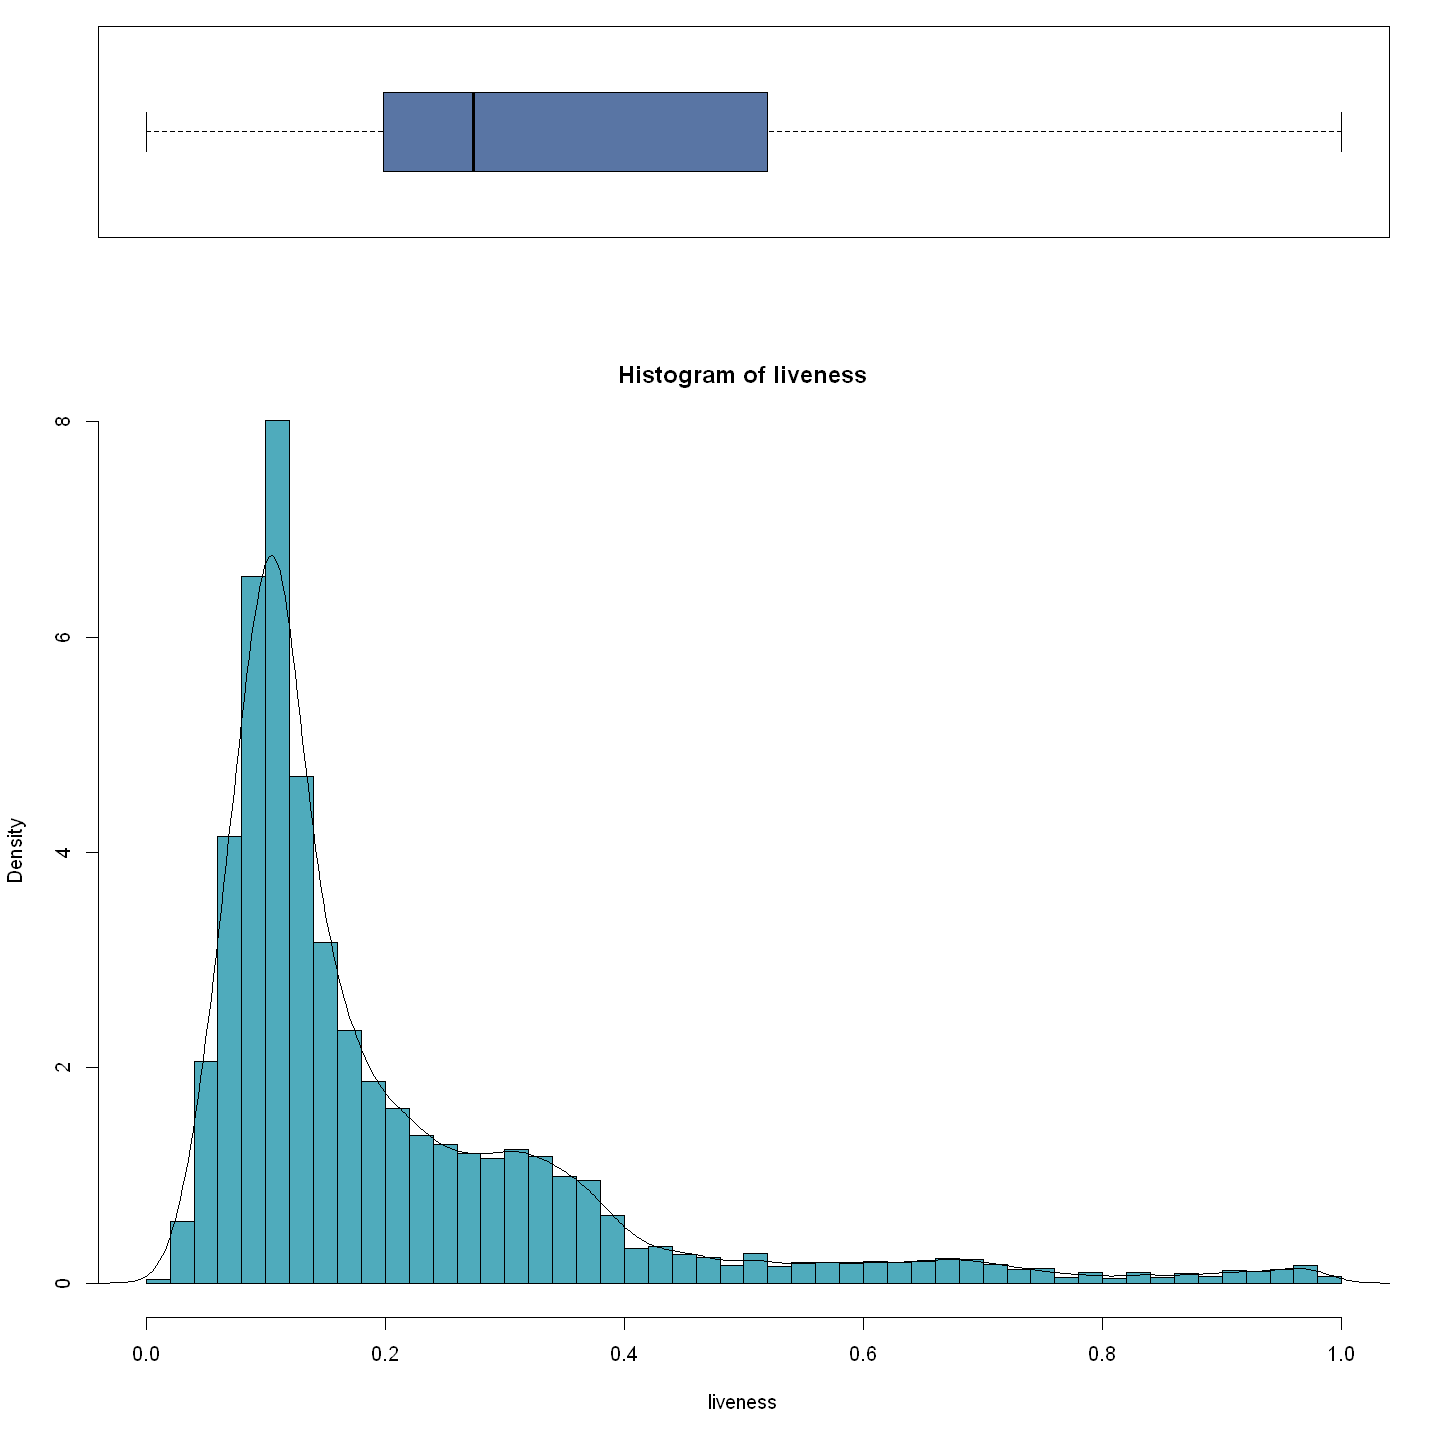

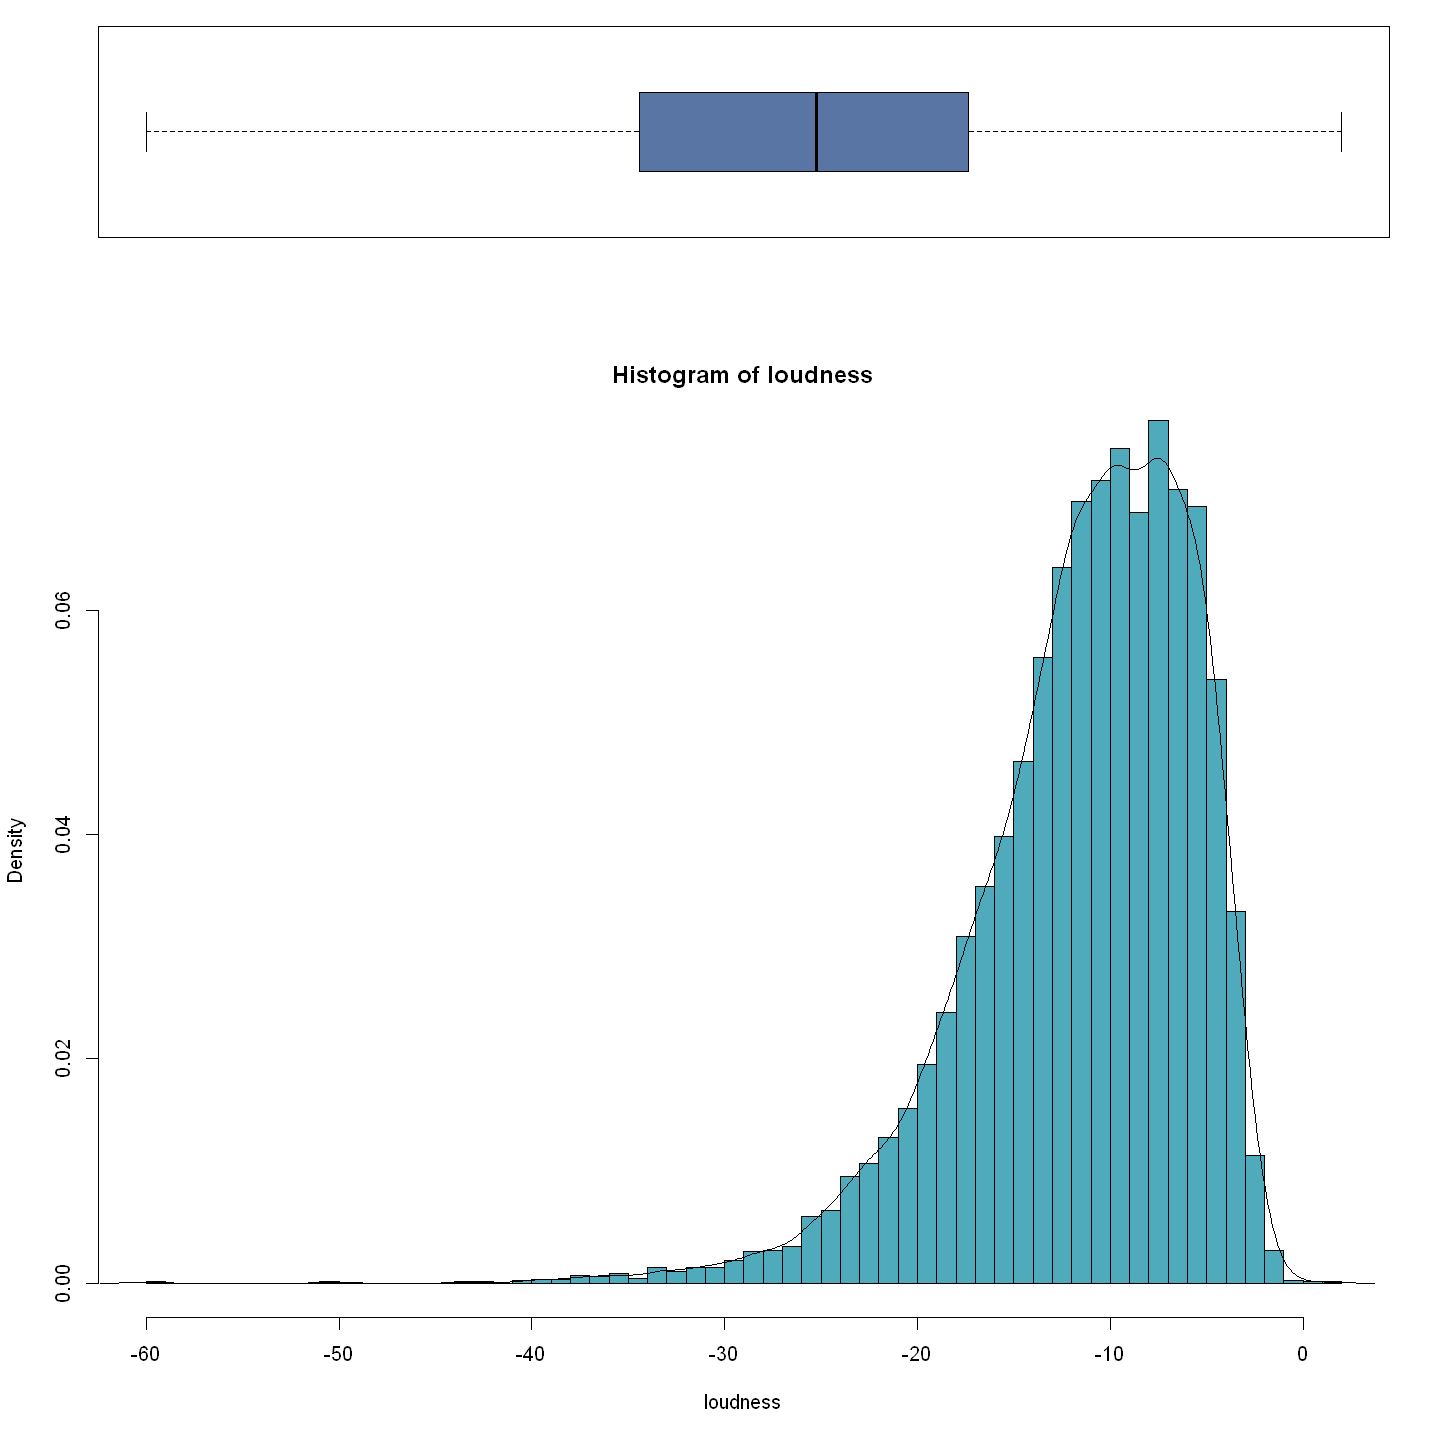

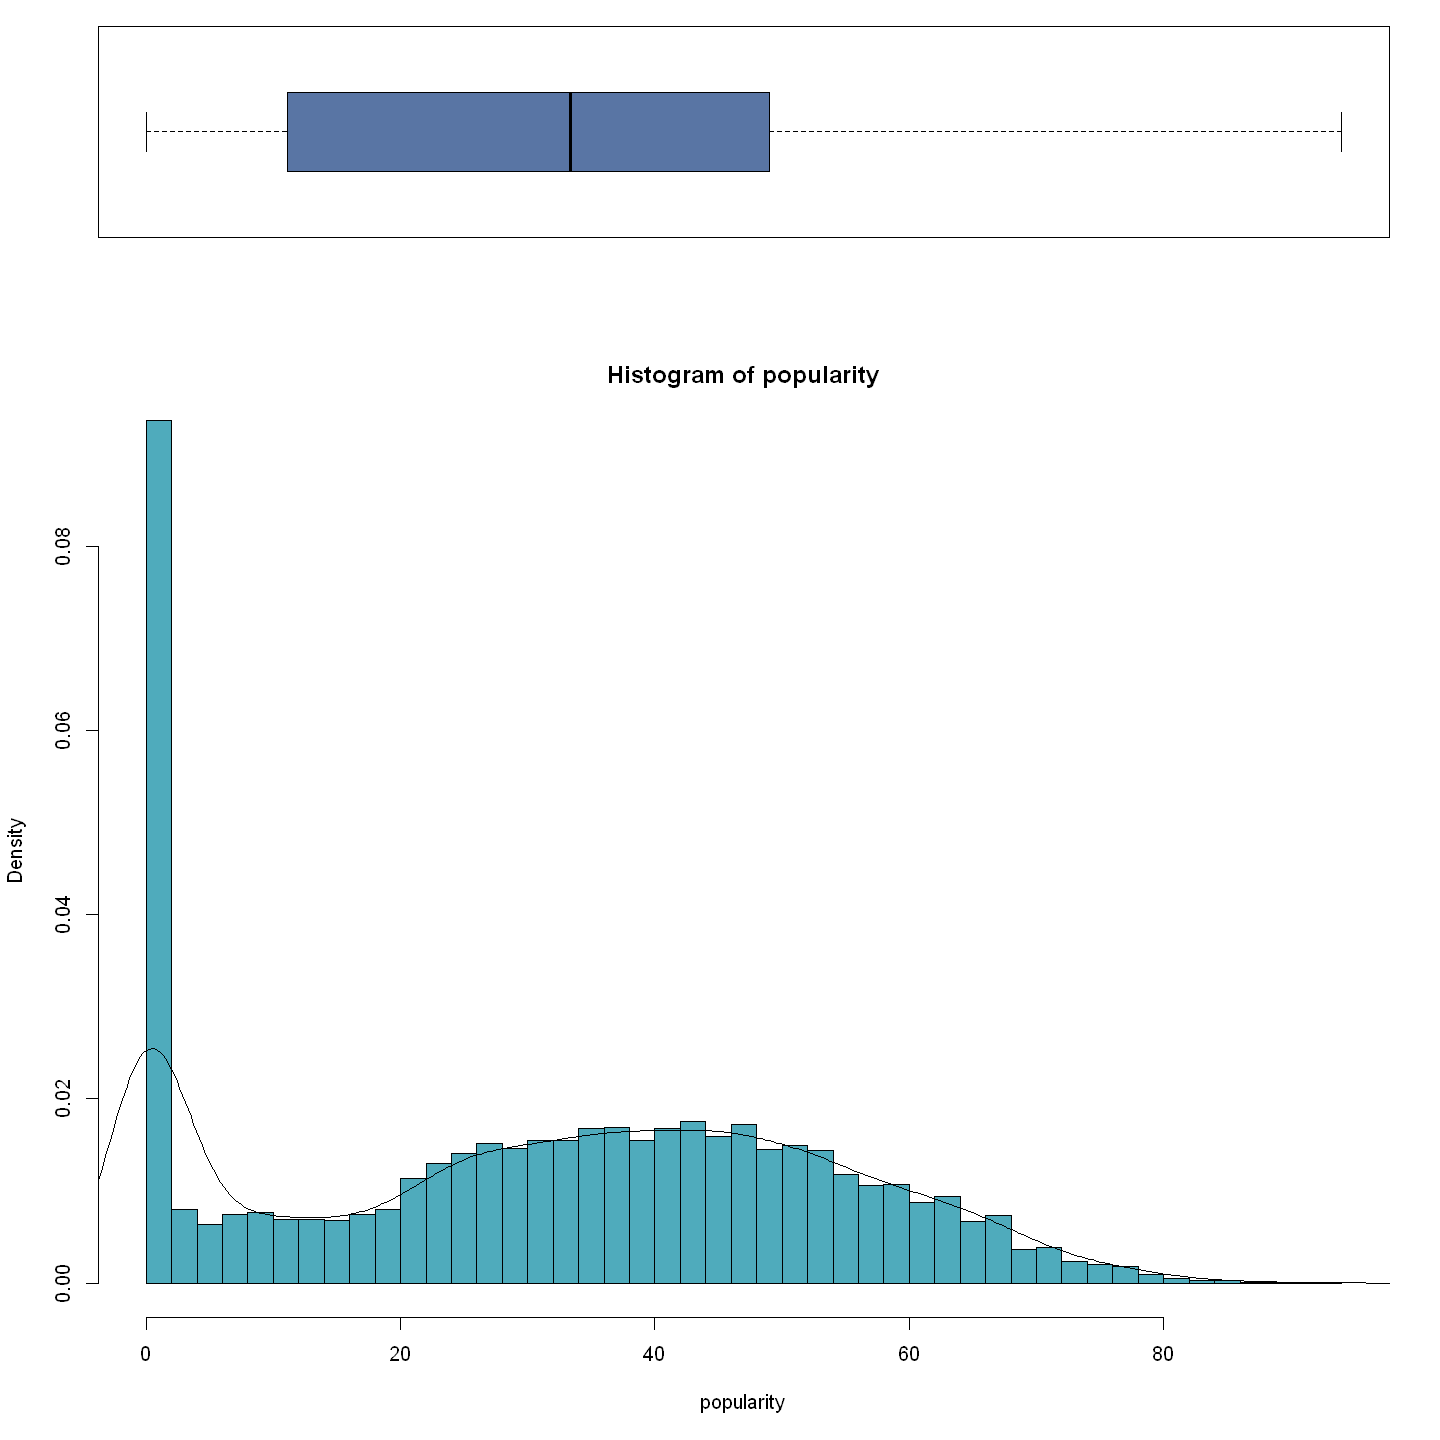

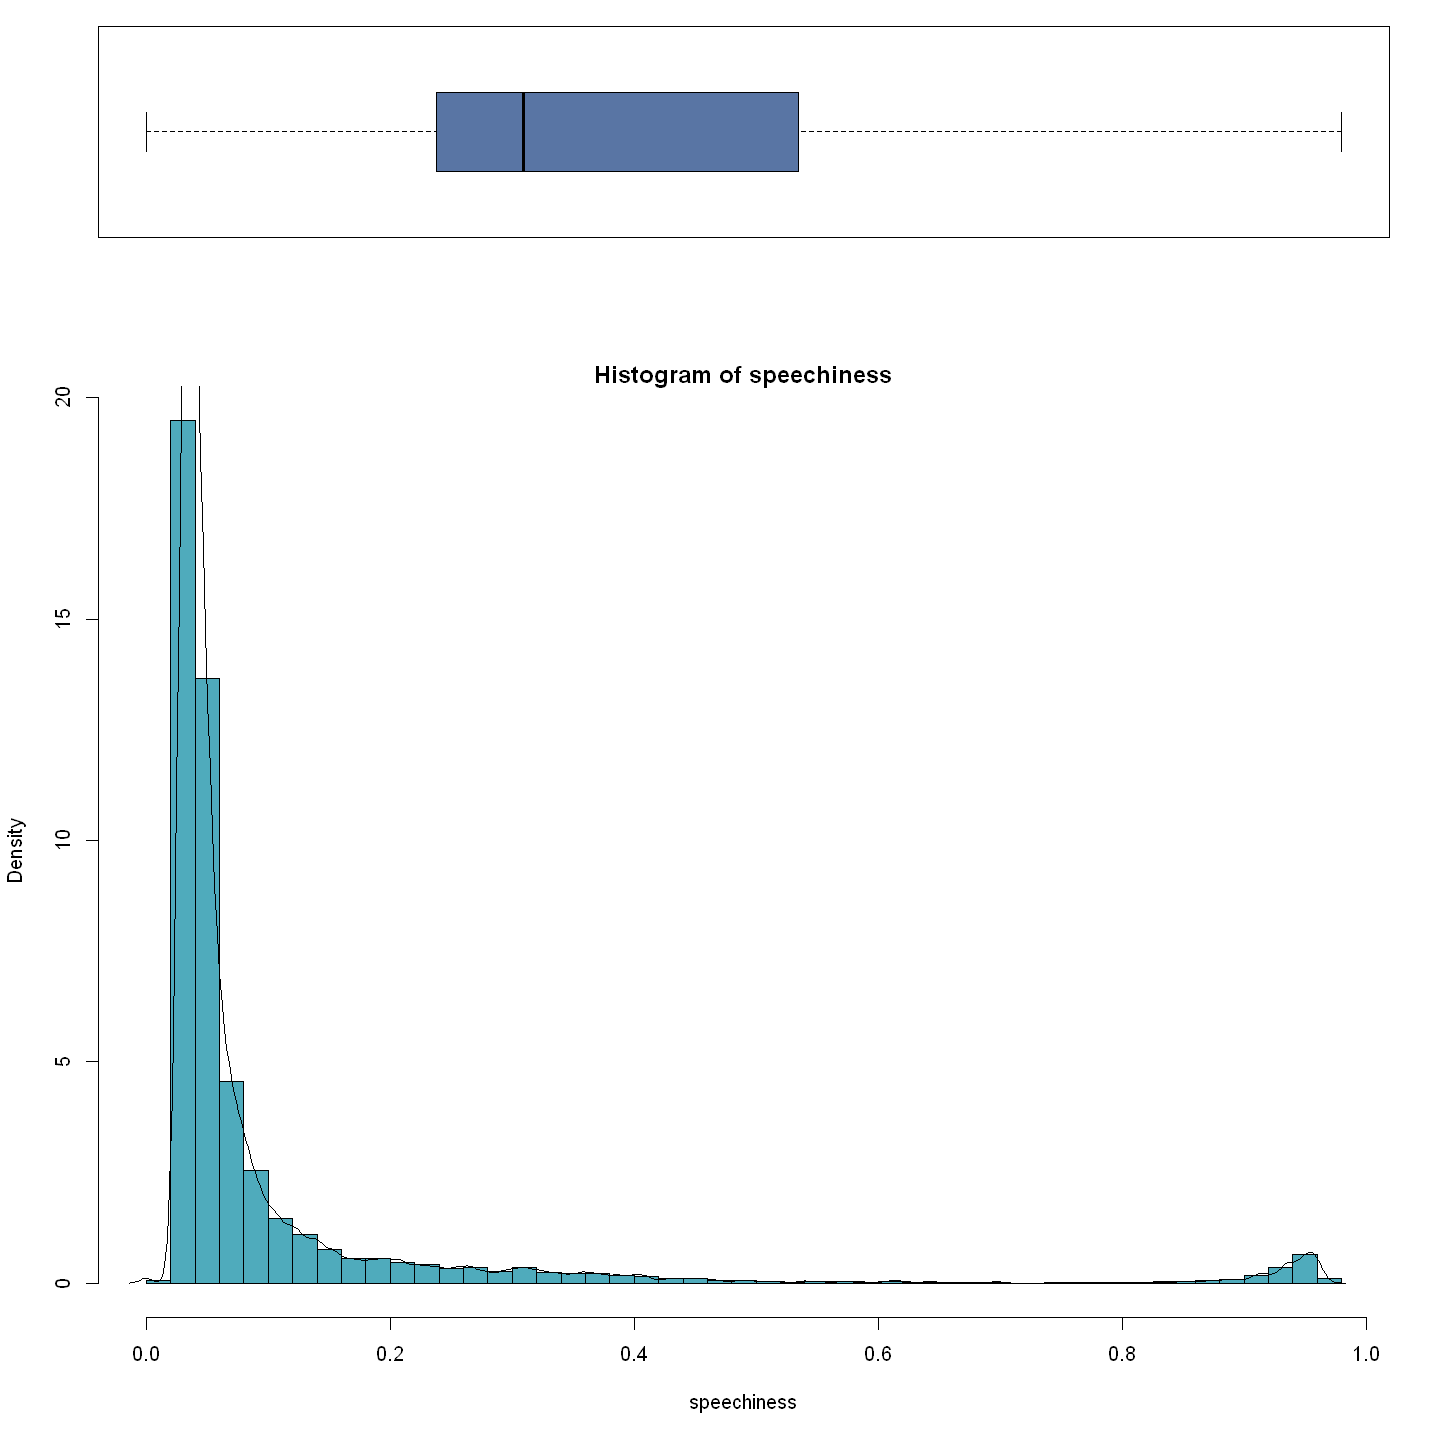

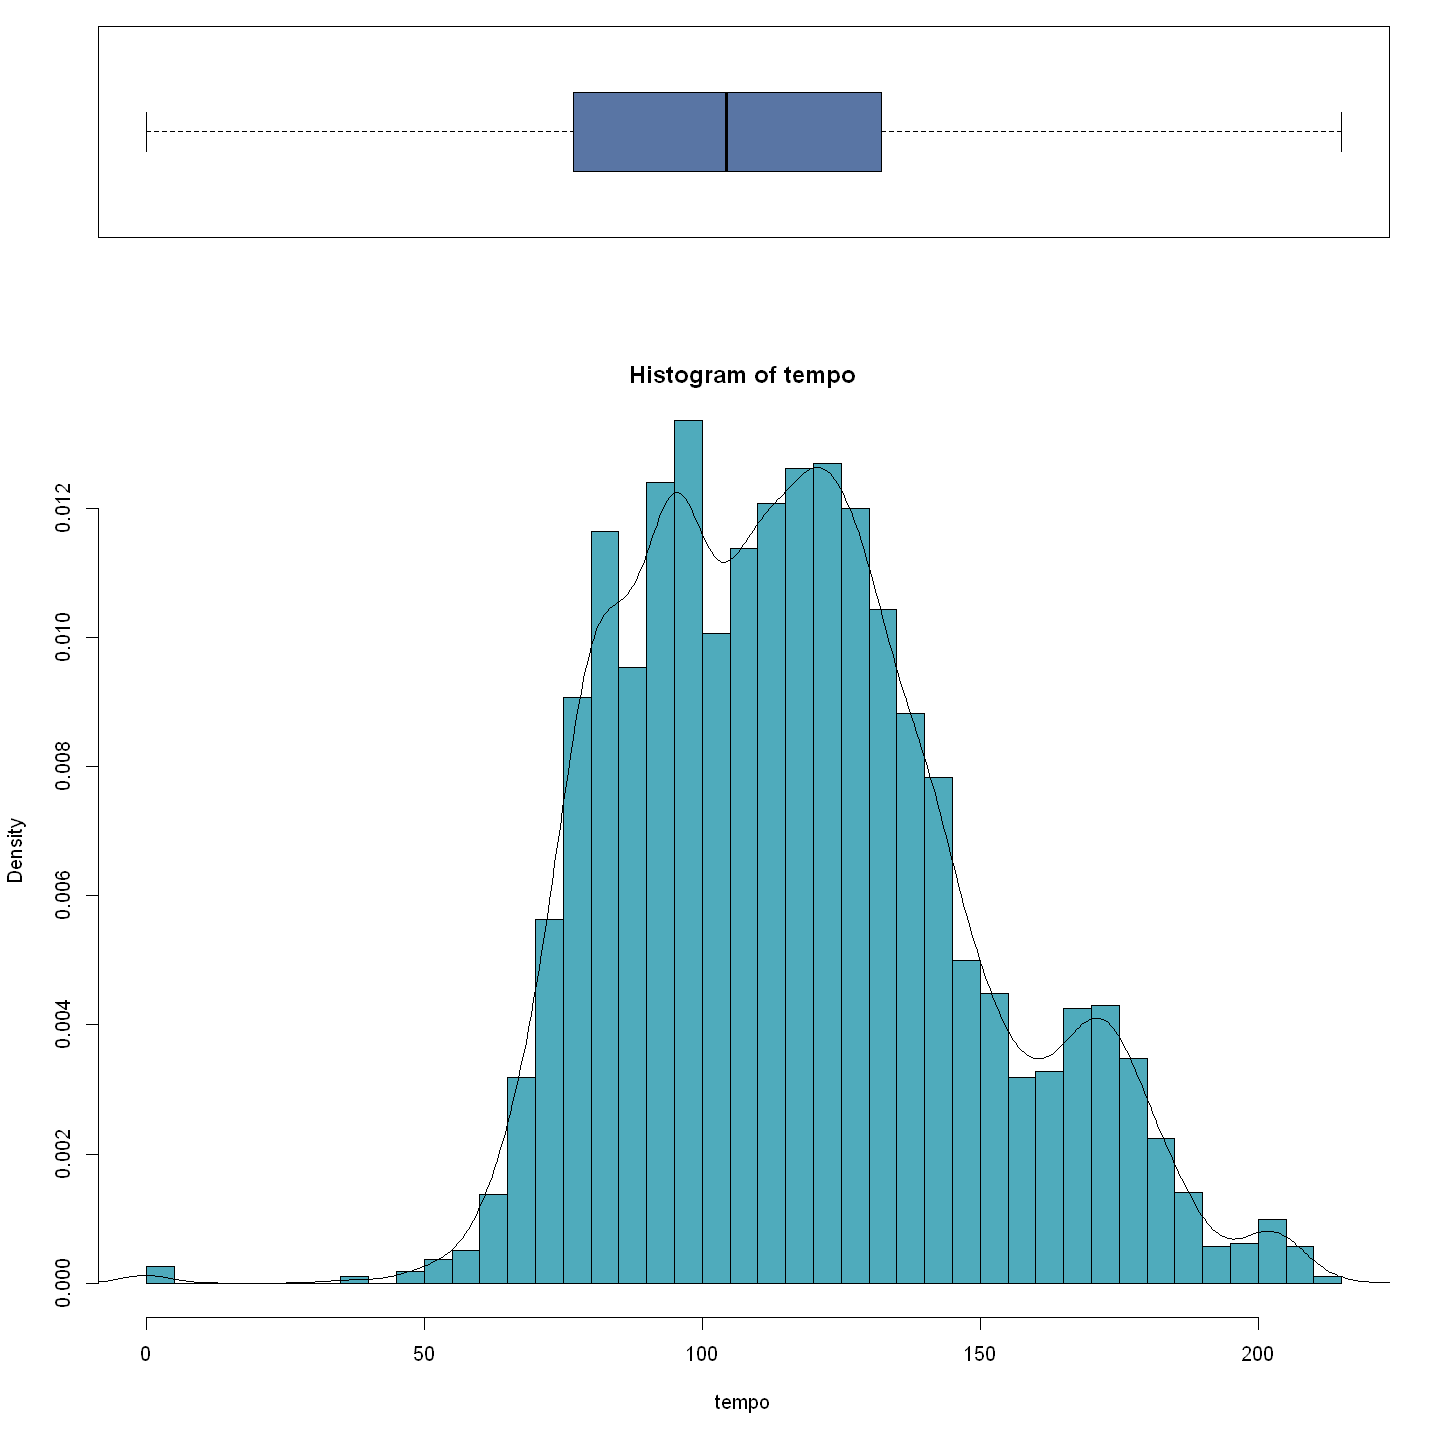

In [24]:
for (i in 1:12) {
    vari <- data.quant[, i]
    nf <- layout(mat = matrix(c(1, 2), 2, 1, byrow = TRUE), height = c(1, 3))
    par(mar = c(5.1, 4.1, 1.1, 2.1))
    boxplot(vari, horizontal = TRUE, xaxt = "n", outline = F, col = "#5975A4")
    hist(vari, main = paste("Histogram of", colnames(data.quant)[i], sep = " "), 
        breaks = ifelse(i == 2, 100, 50), xlab = colnames(data.quant)[i], freq = F, 
        col = "#4FABBC")
    lines(density(vari))
}

Voici une étude plus approfondie de chaque variable quantitative :

<b>Acousticness</b>

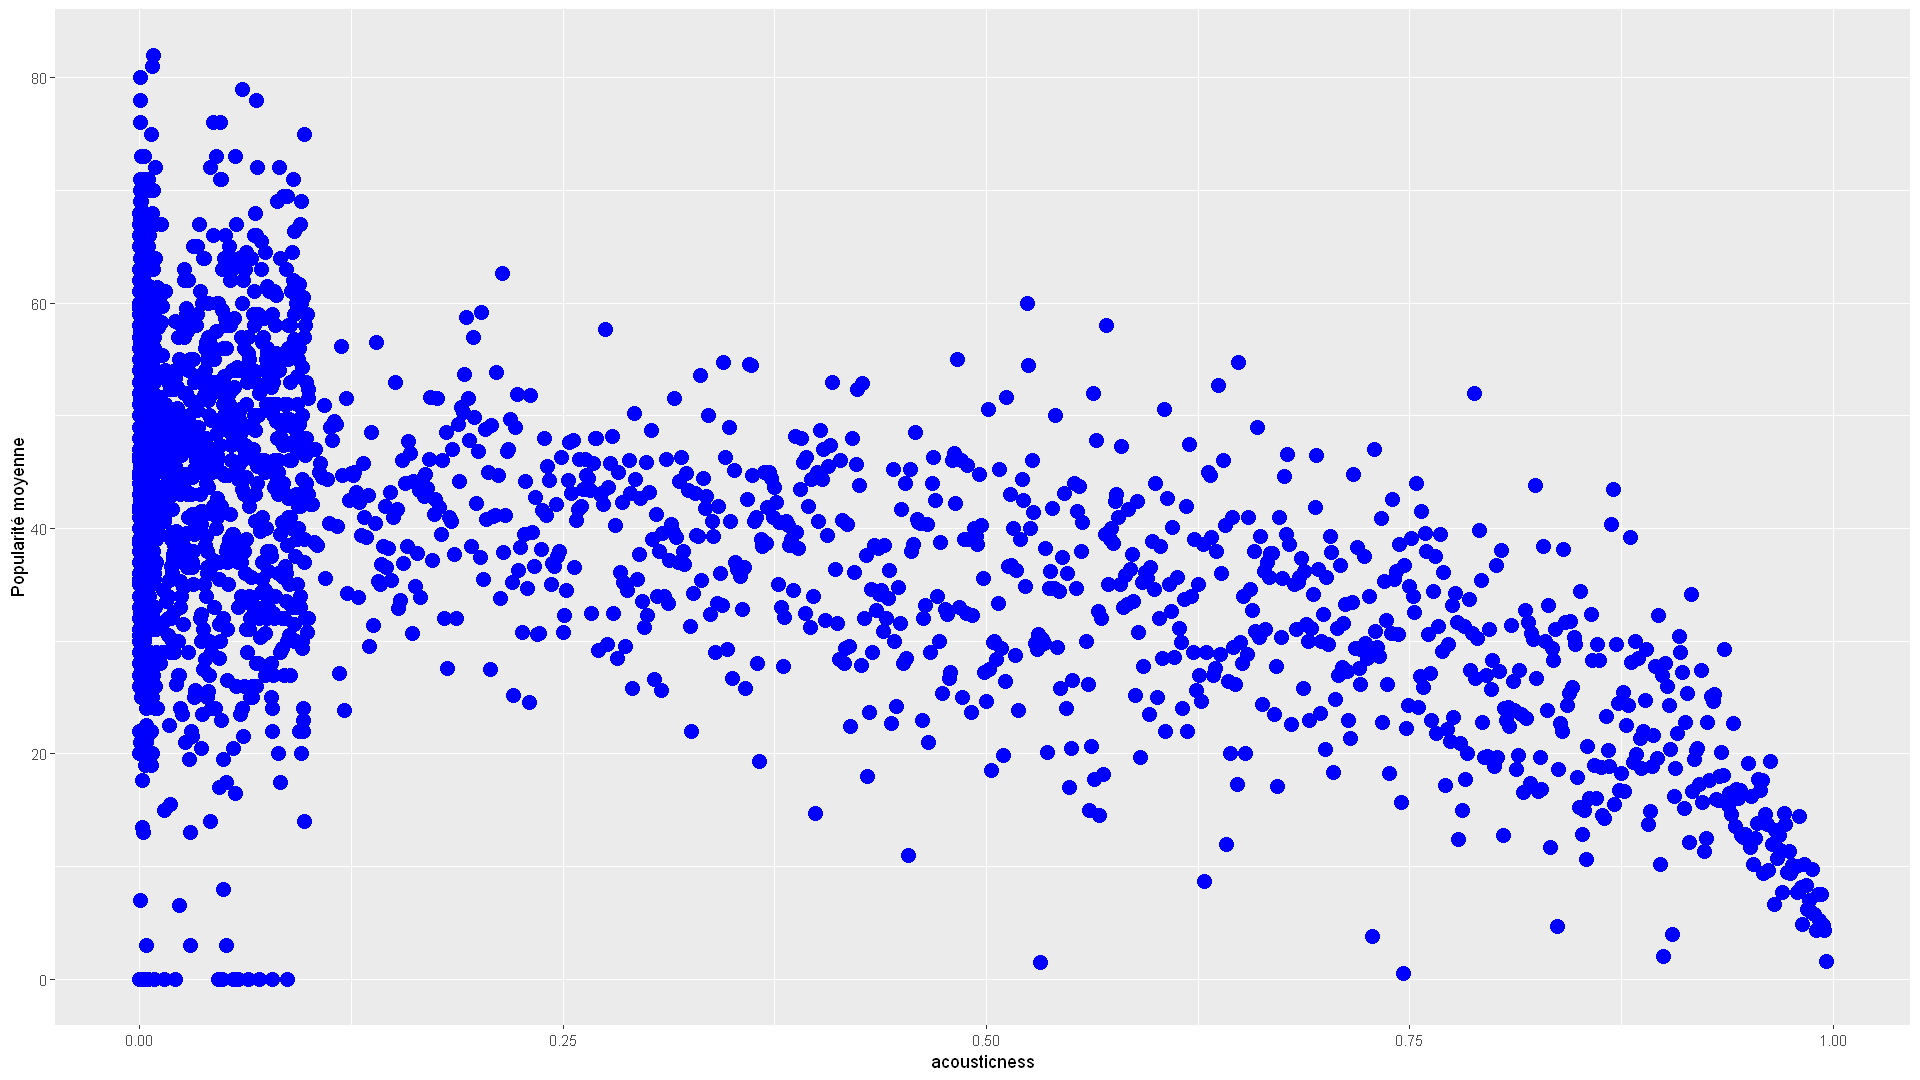

In [25]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(acousticness) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 16, repr.plot.height = 9)

ggplot(ax.data, aes(x = acousticness, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Danceability</b>

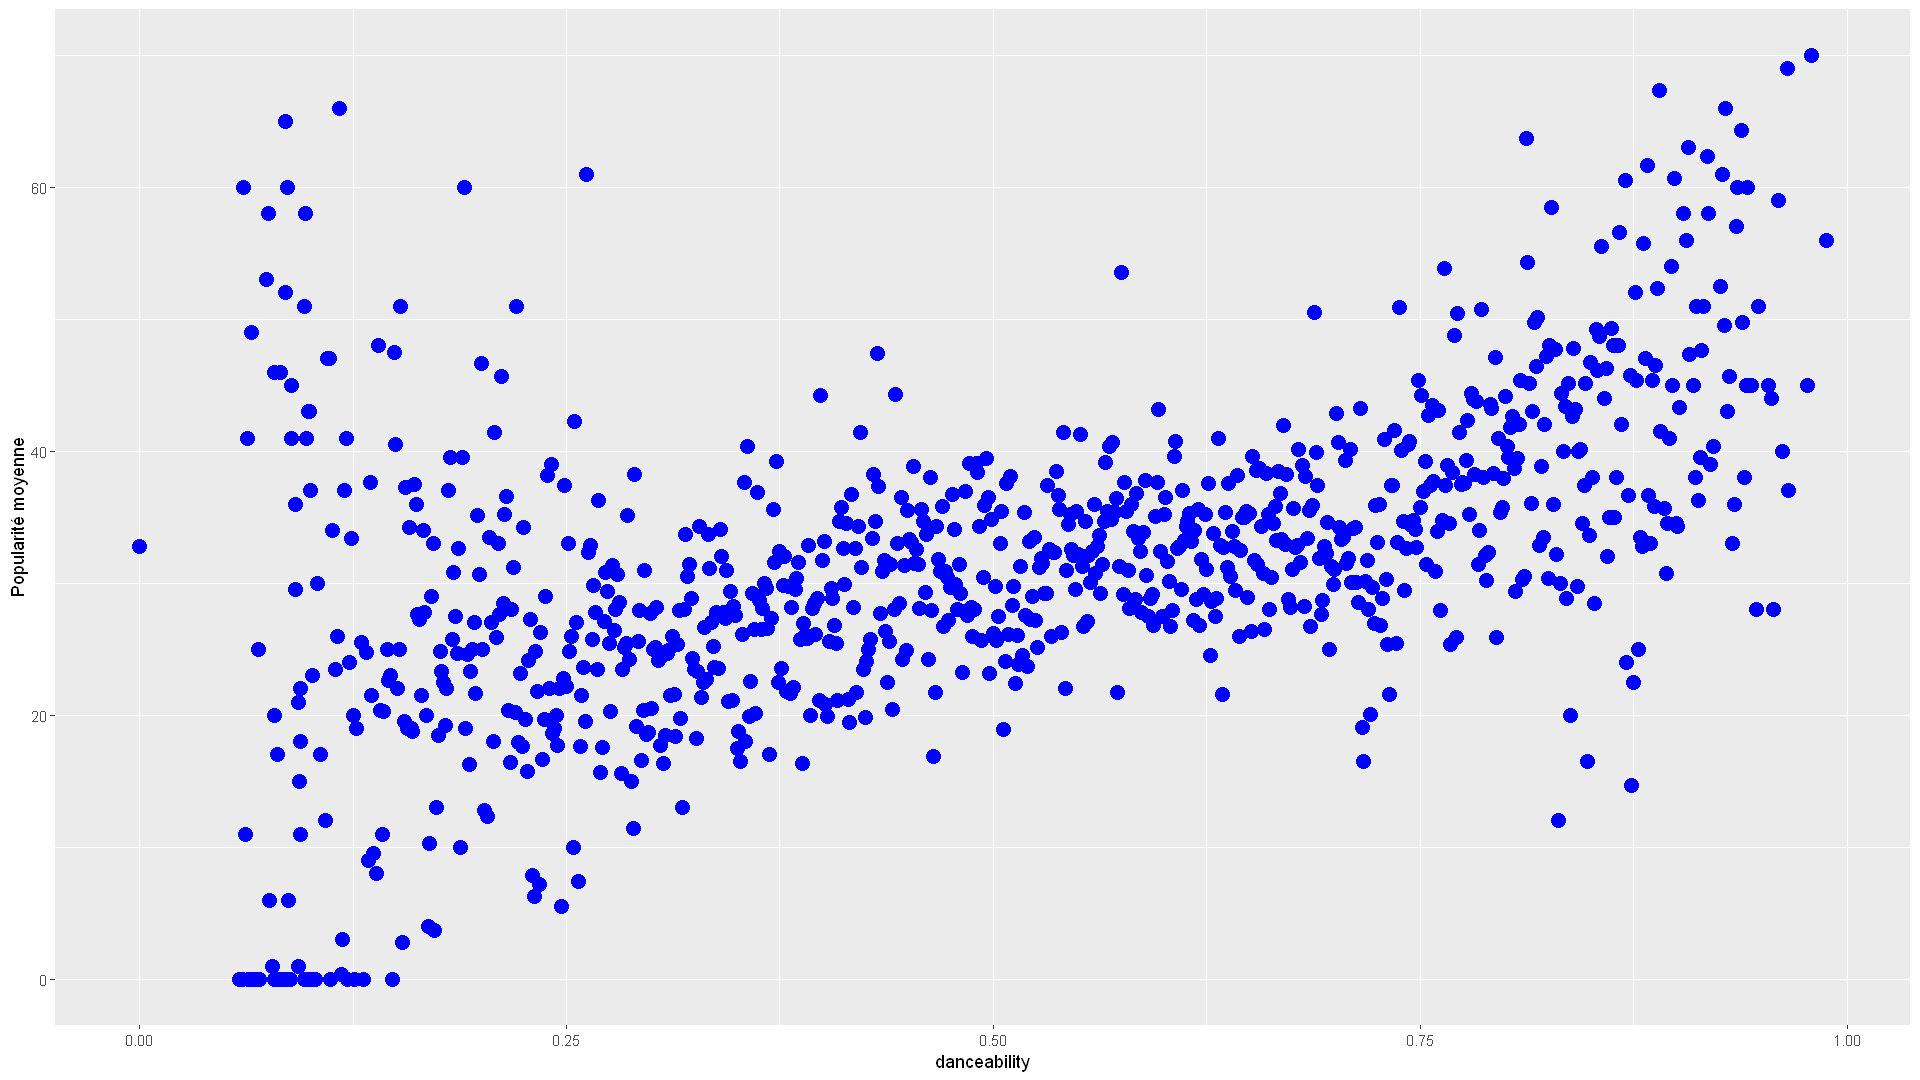

In [26]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(danceability) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 16, repr.plot.height = 9)

ggplot(ax.data, aes(x = danceability, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Duration</b>

On convertit la durée des chansons en minutes pour en tirer plus d'informations.

In [27]:
spotify_data$duration <- spotify_data$duration / 60000
summary(spotify_data$duration)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
 0.09985  2.81778  3.44216  3.78692  4.32888 45.05378 

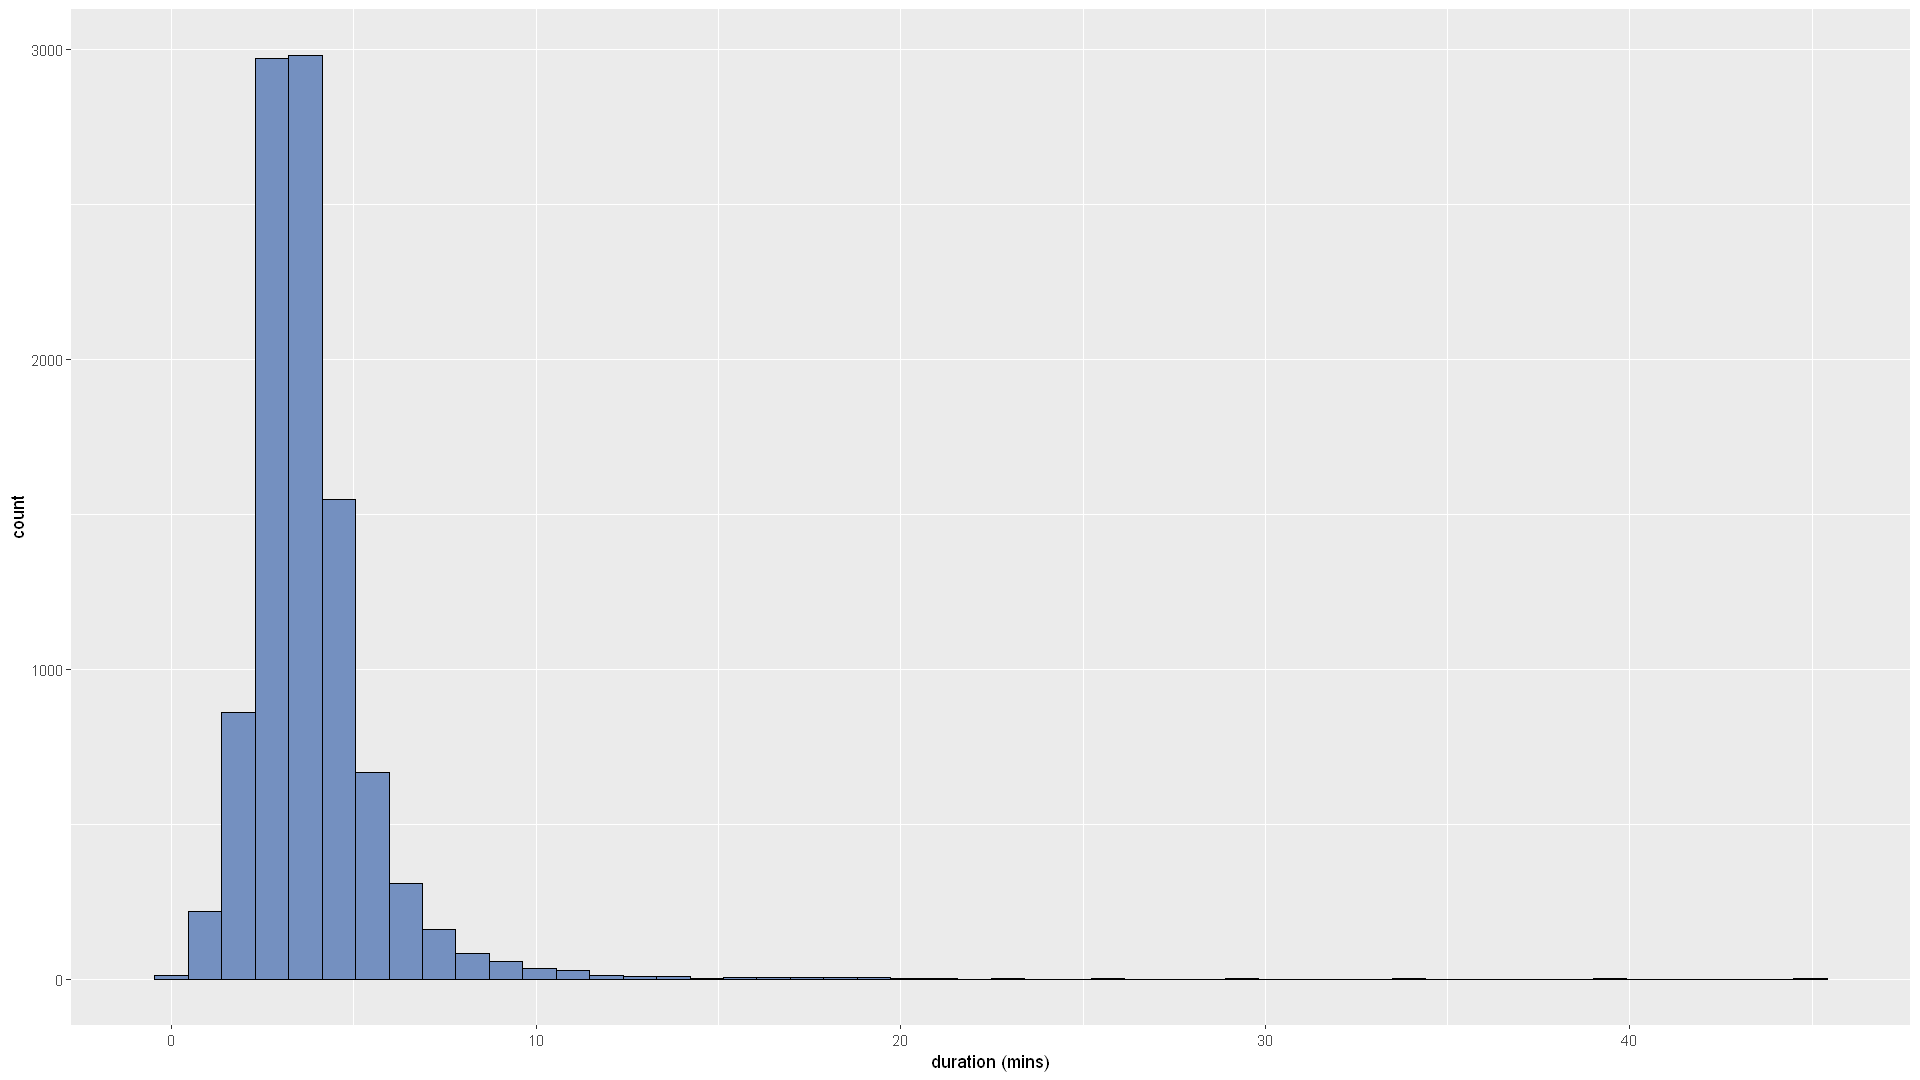

In [28]:
ggplot(data = spotify_data, aes(x = duration)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
    labs(x = "duration (mins)")

On voit que la chanson la plus longue dans le jeu de données dure 45 minutes, donc on choisit de séparer les chansons longues de chansons courtes au seuil de 8 minutes pour mieux voir les durées.

In [29]:
long.songs <- spotify_data[spotify_data$duration > 8, ]
short.songs <- spotify_data[spotify_data$duration <= 8, ]

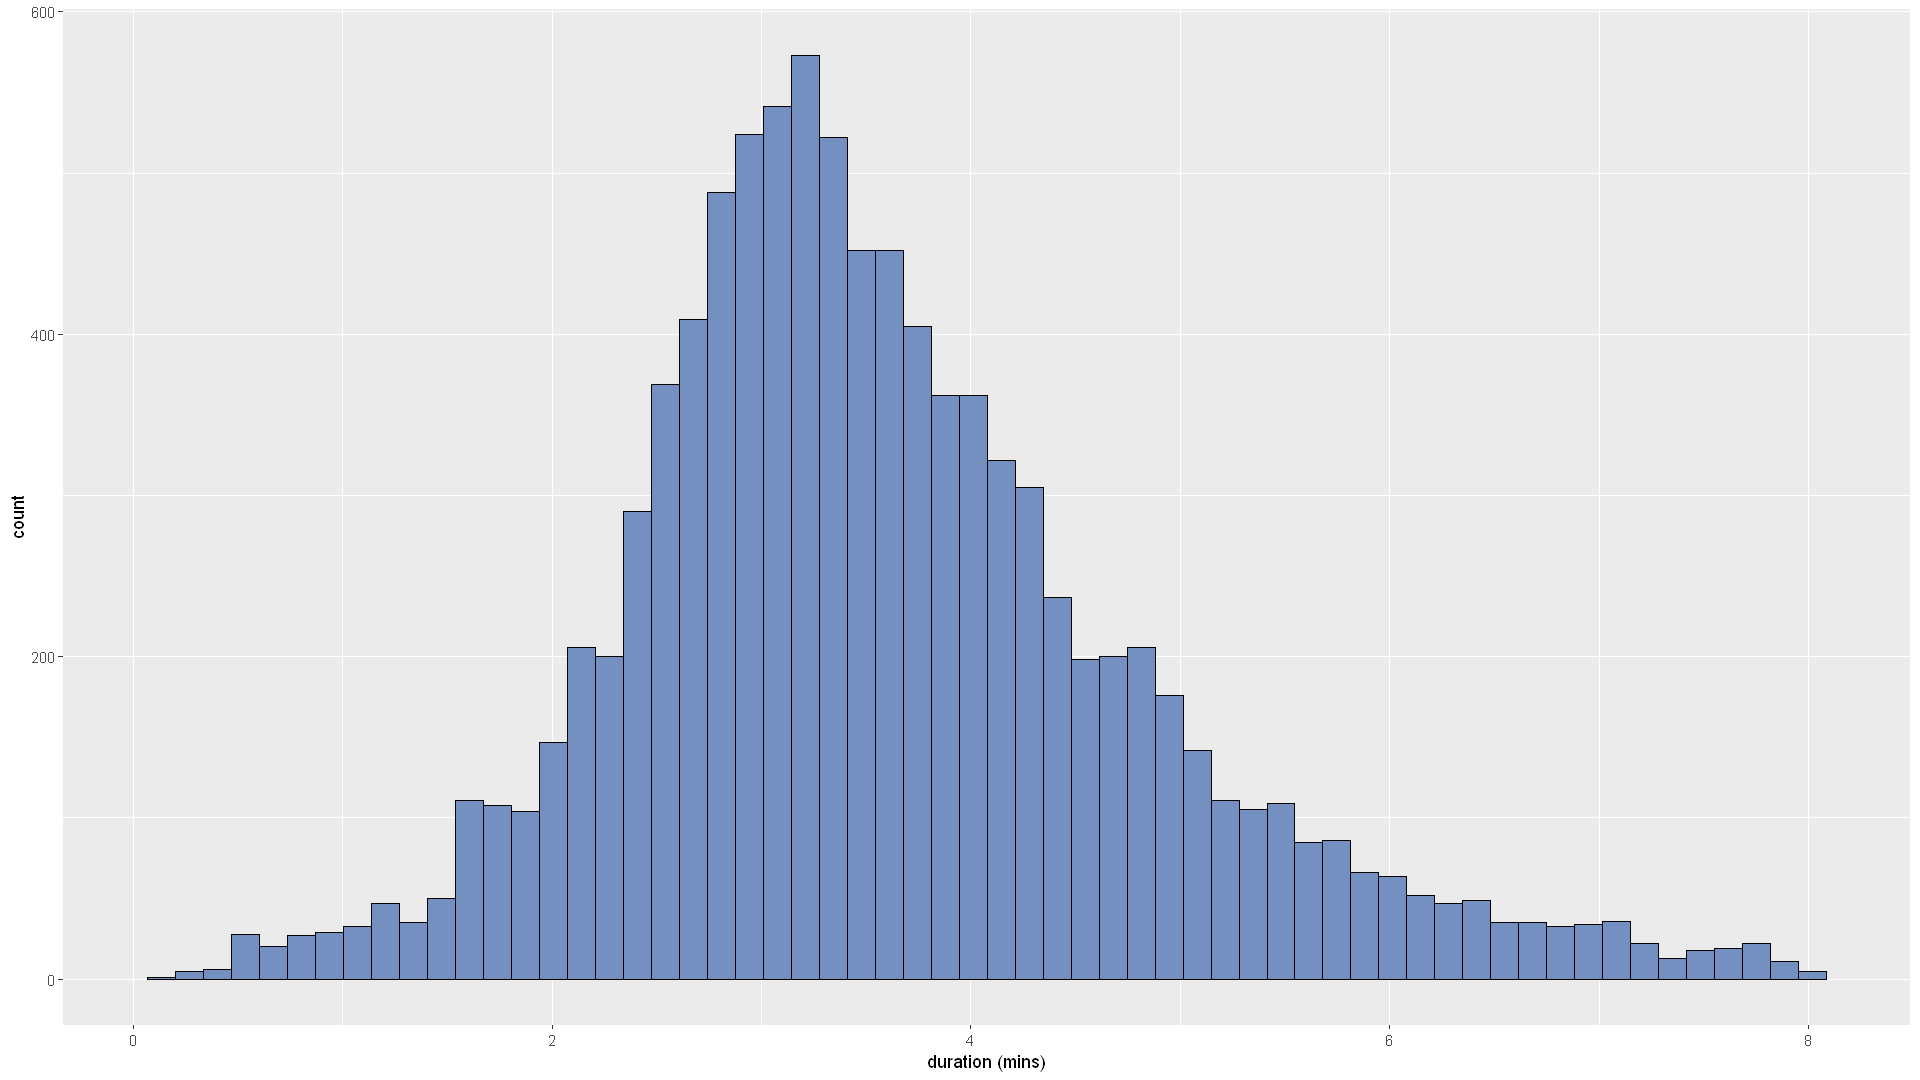

In [30]:
ggplot(data = short.songs, aes(x = duration)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 60) +
    labs(x = "duration (mins)")

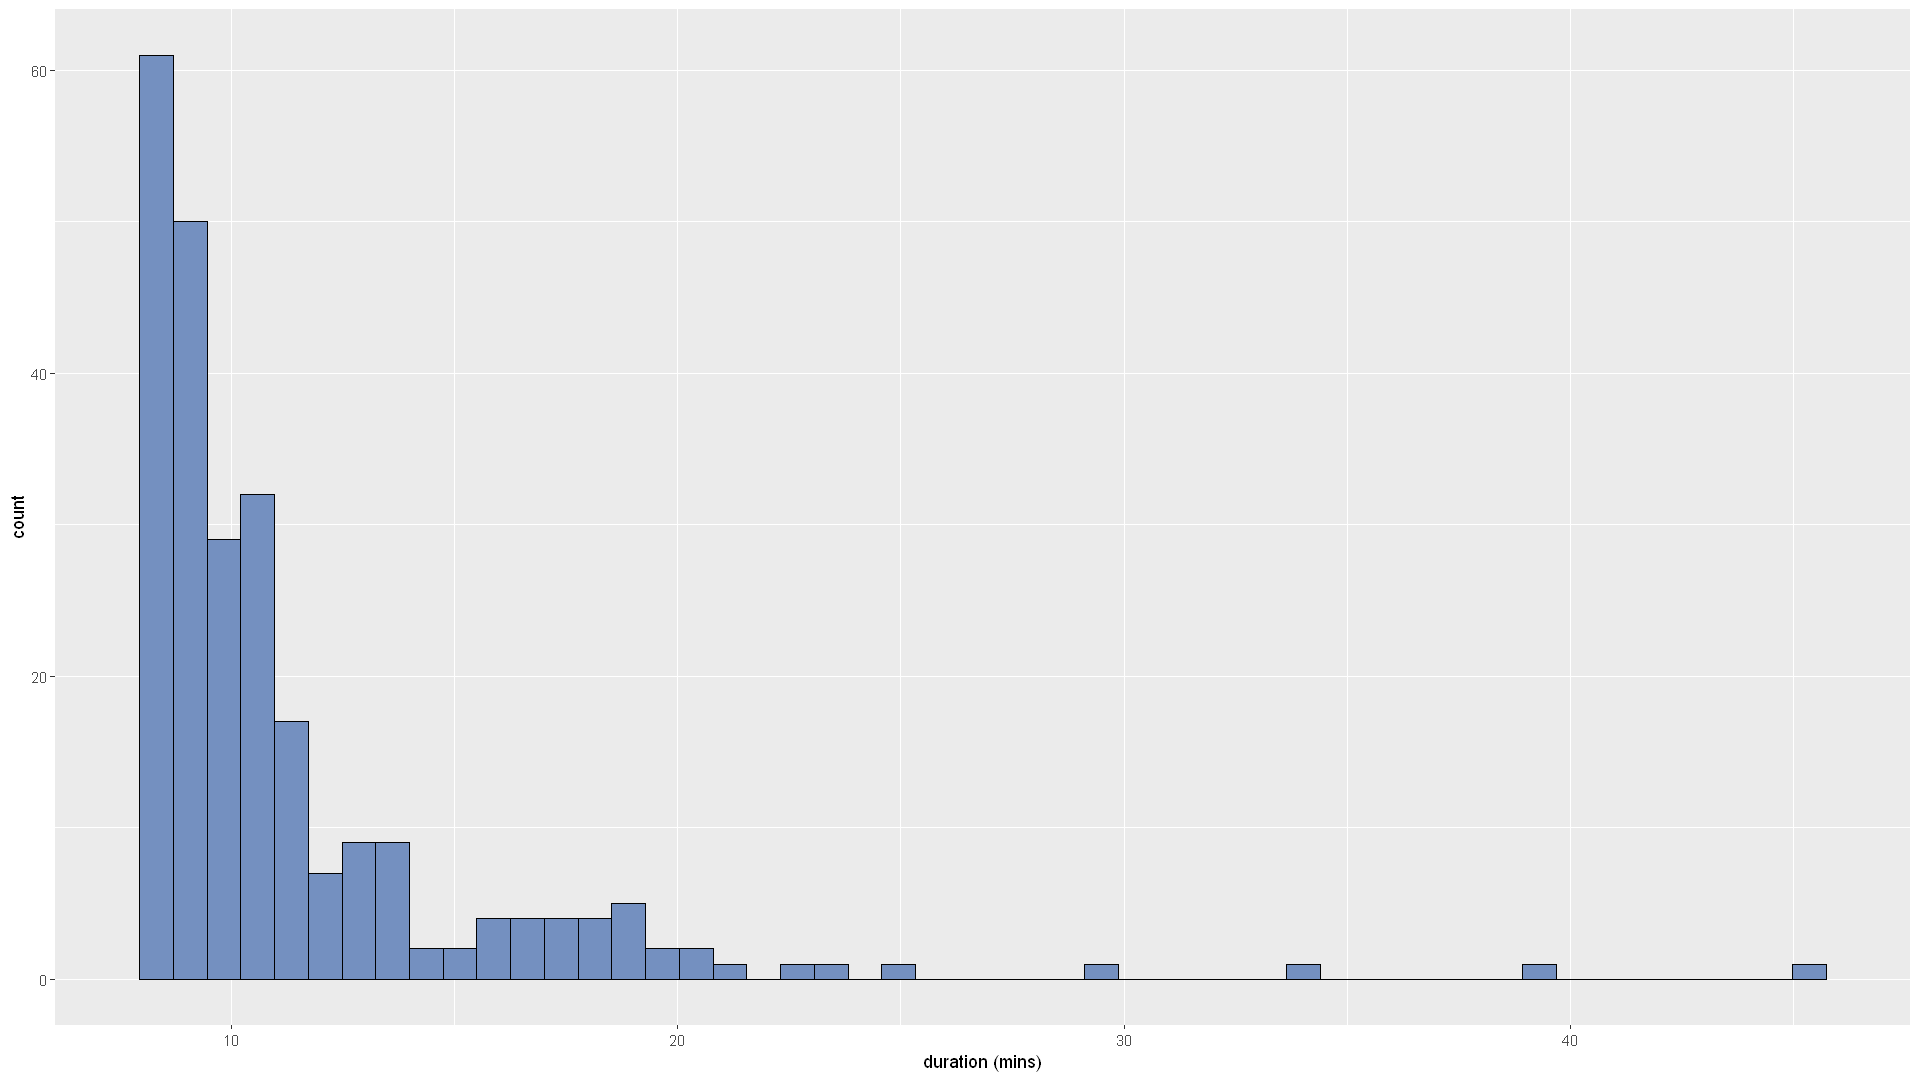

In [31]:
ggplot(data = long.songs, aes(x = duration)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
    labs(x = "duration (mins)")


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




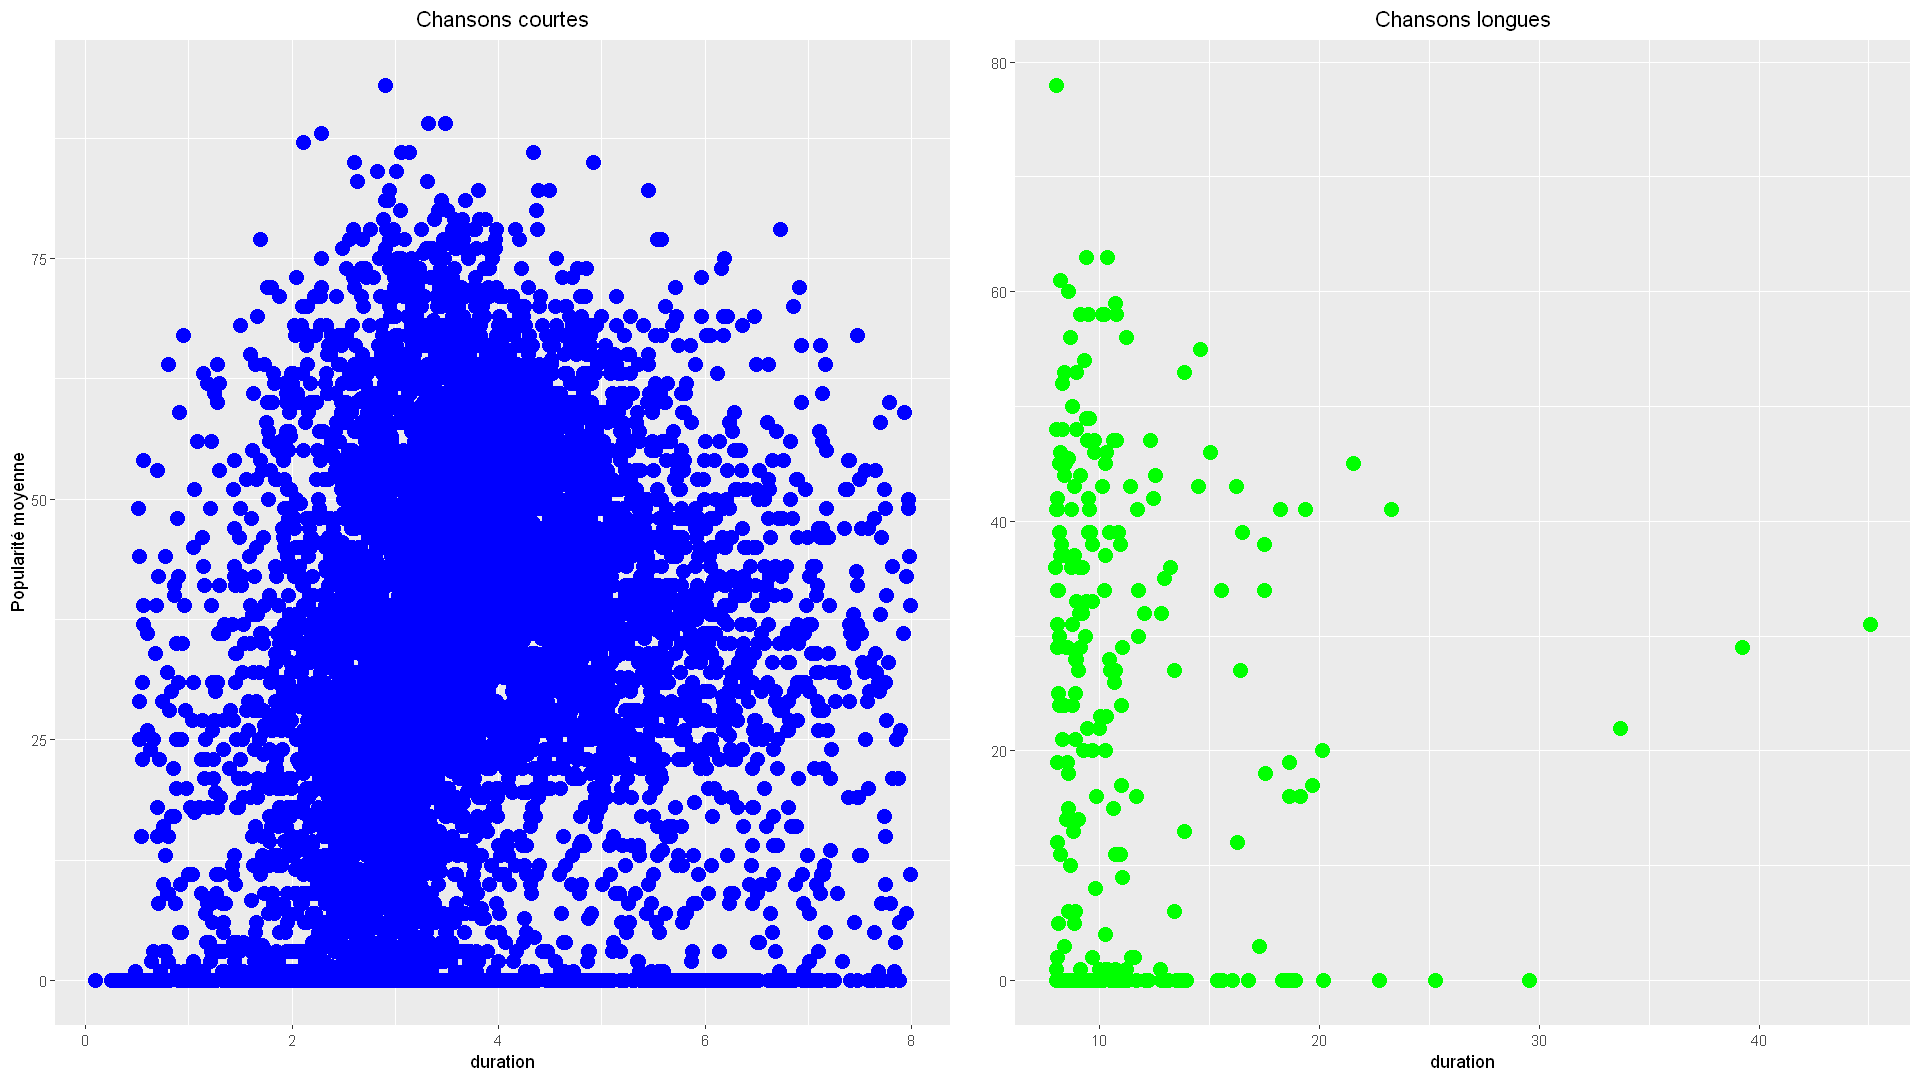

In [32]:
library(grid)
library(gridExtra)

ax1.data <- as.data.frame(short.songs %>%
    group_by(duration) %>%
    mutate(popularity = mean(popularity)))

ax2.data <- as.data.frame(long.songs %>%
    group_by(duration) %>%
    mutate(popularity = mean(popularity)))

p1 <- ggplot(ax1.data, aes(x = duration, y = popularity)) +
        geom_point(color = "blue", size = 4) +
        labs(title = "Chansons courtes", y = "Popularité moyenne") +
        theme(plot.title = element_text(hjust = 0.5))

p2 <- ggplot(ax2.data, aes(x = duration, y = popularity)) +
        geom_point(color = "green", size = 4) +
        labs(title = "Chansons longues", y = "") +
        theme(plot.title = element_text(hjust = 0.5))

grid.arrange(p1, p2, nrow = 1)

<b>Energy</b>

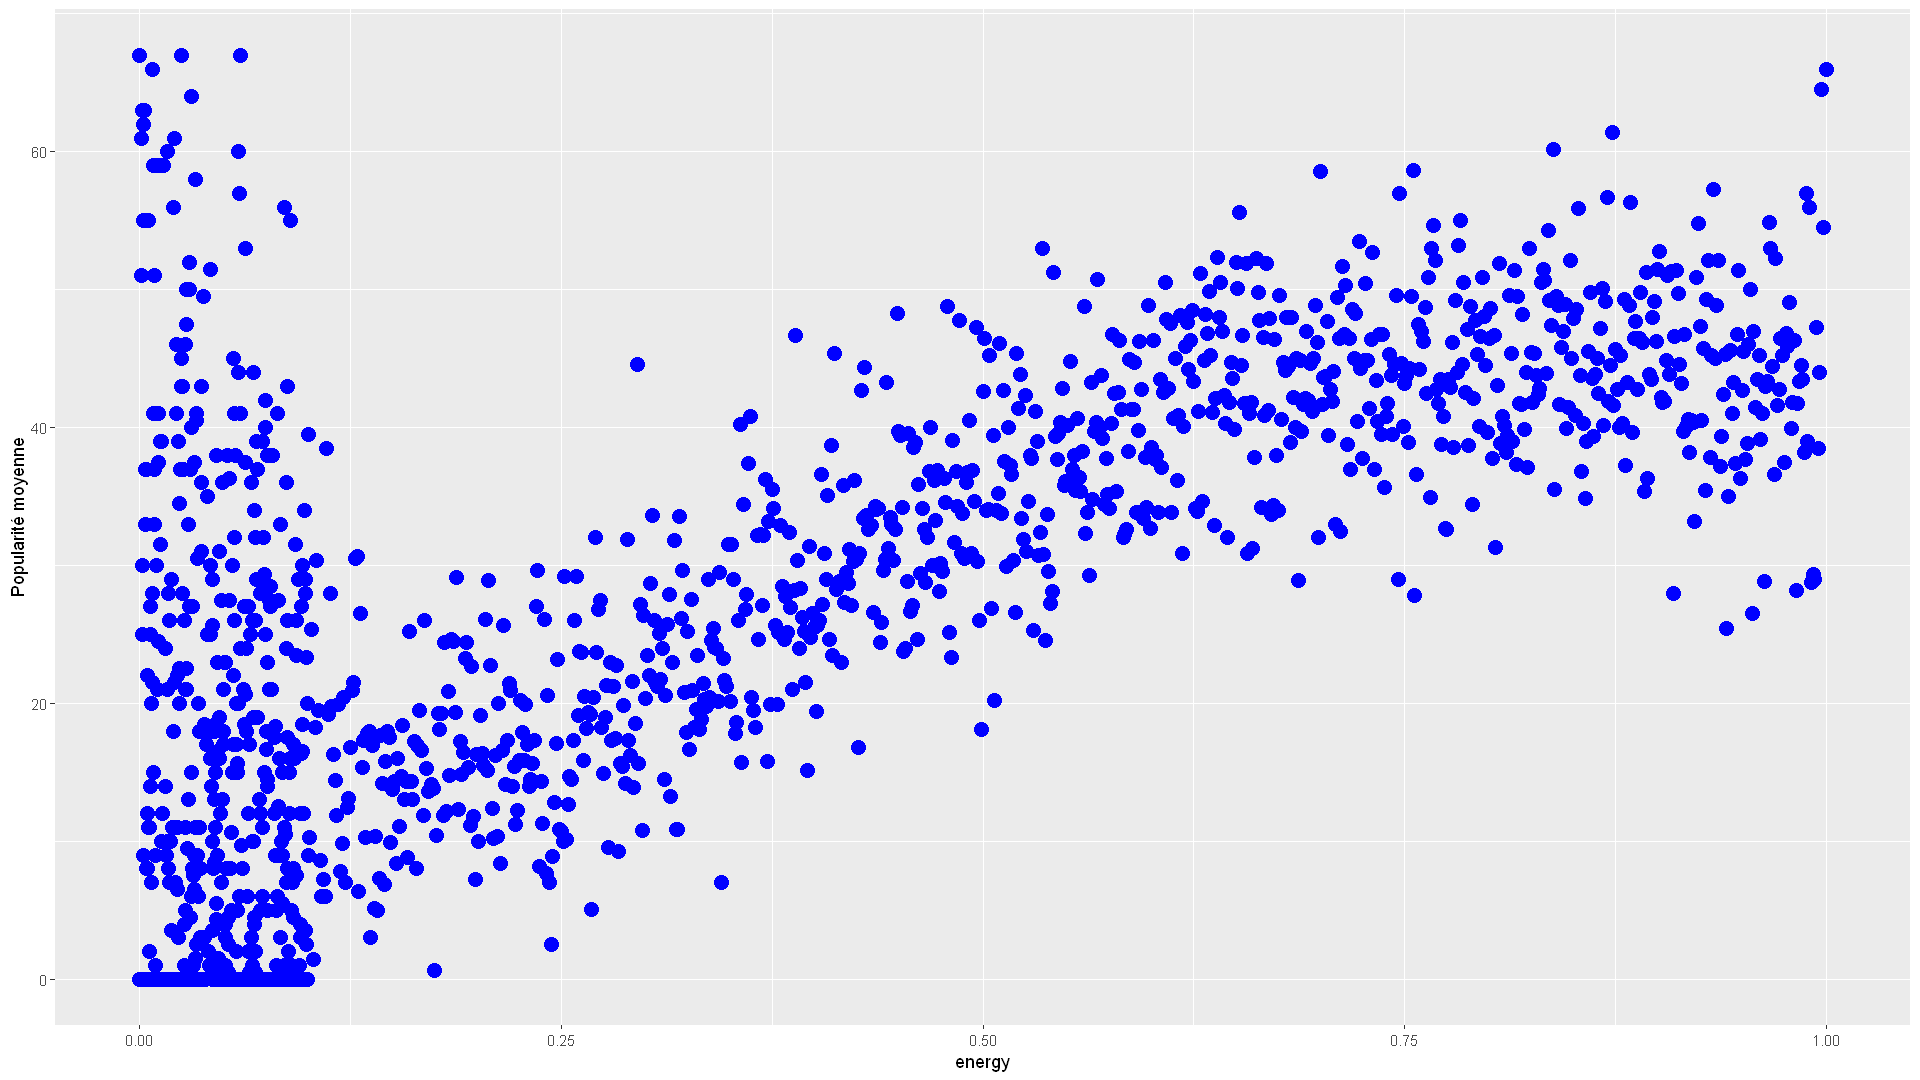

In [33]:
ax.data <- as.data.frame(short.songs %>%
    group_by(energy) %>%
    mutate(popularity = mean(popularity)))

ggplot(ax.data, aes(x = energy, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Instrumentalness</b>

In [34]:
summary(spotify_data$instrumentalness)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000174 0.164947 0.087100 1.000000 

In [35]:
dim(spotify_data[spotify_data$instrumentalness == 0, ])

[1] 2806   15

Il y a 2806 chansons pour lesquelles `instrumentalness` vaut 0.

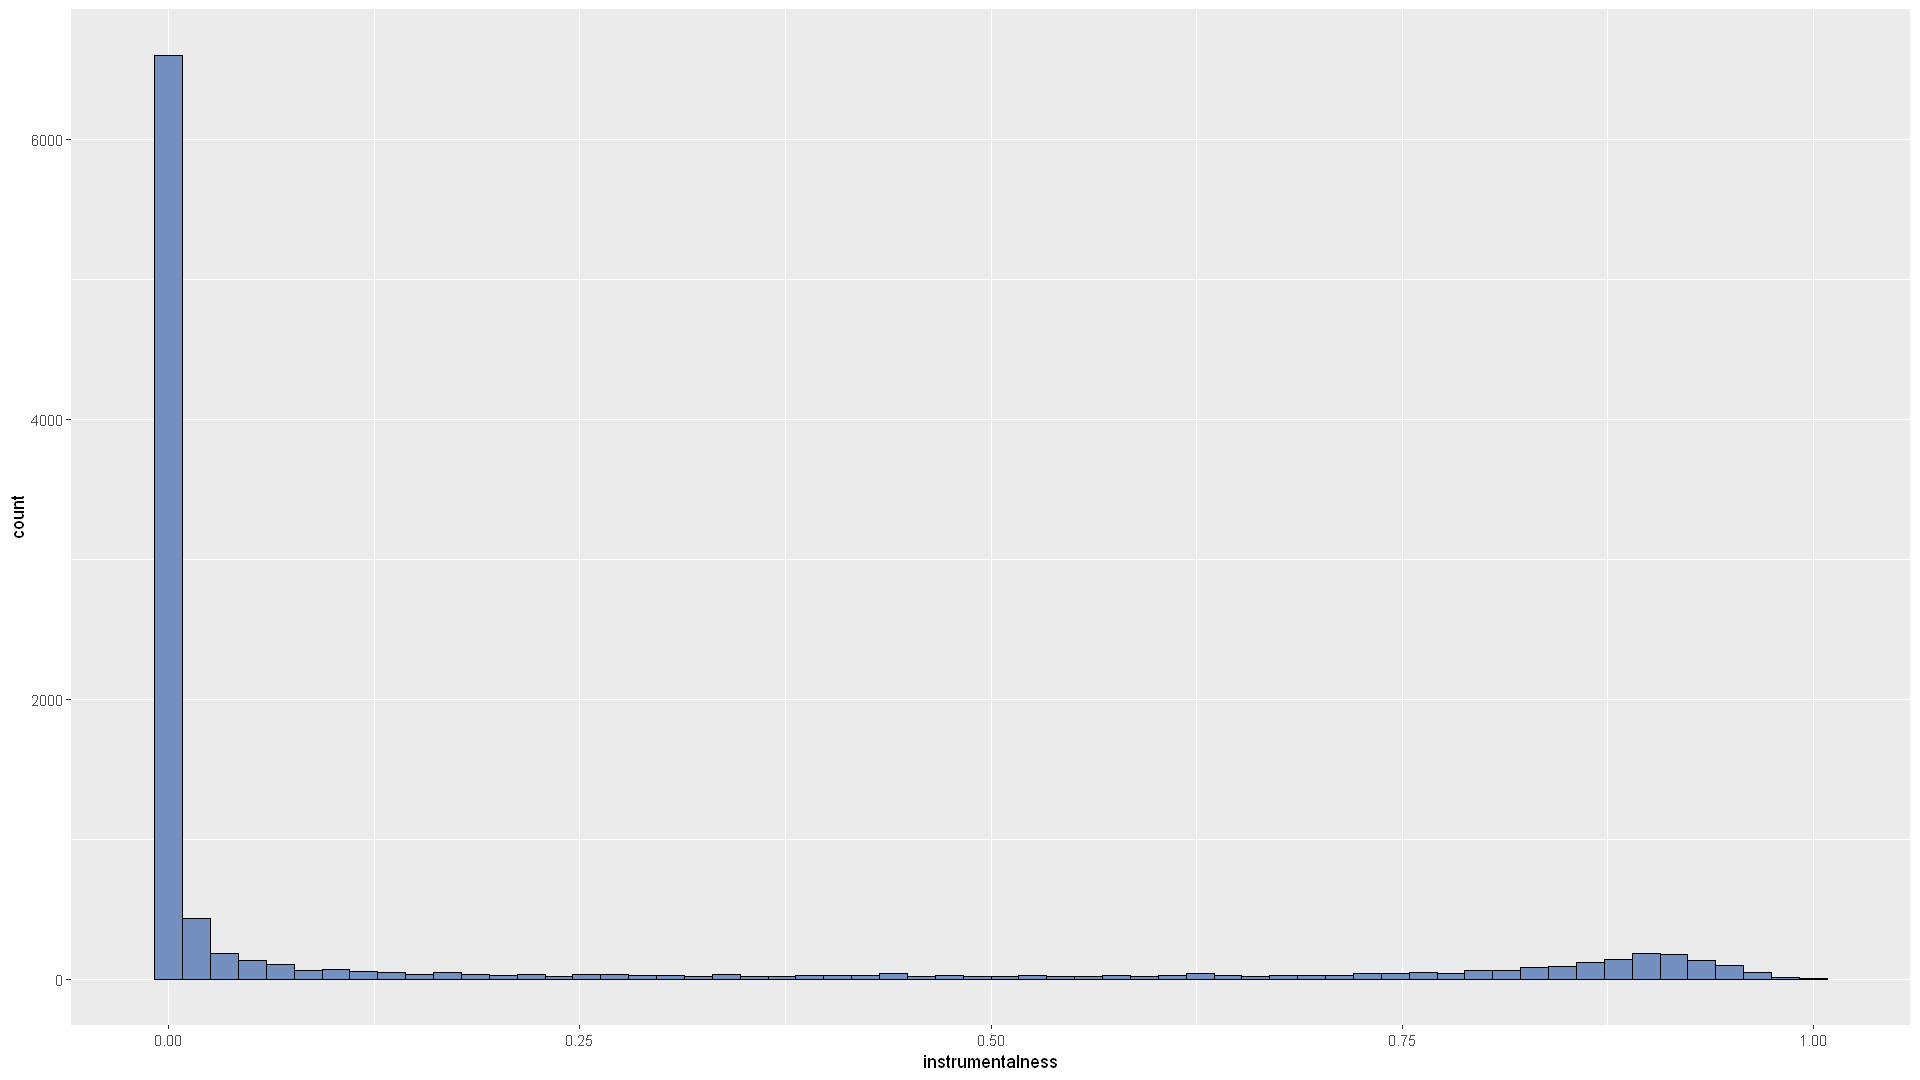

In [36]:
ggplot(data = spotify_data, aes(x = instrumentalness)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 60)

<b>Liveness</b>

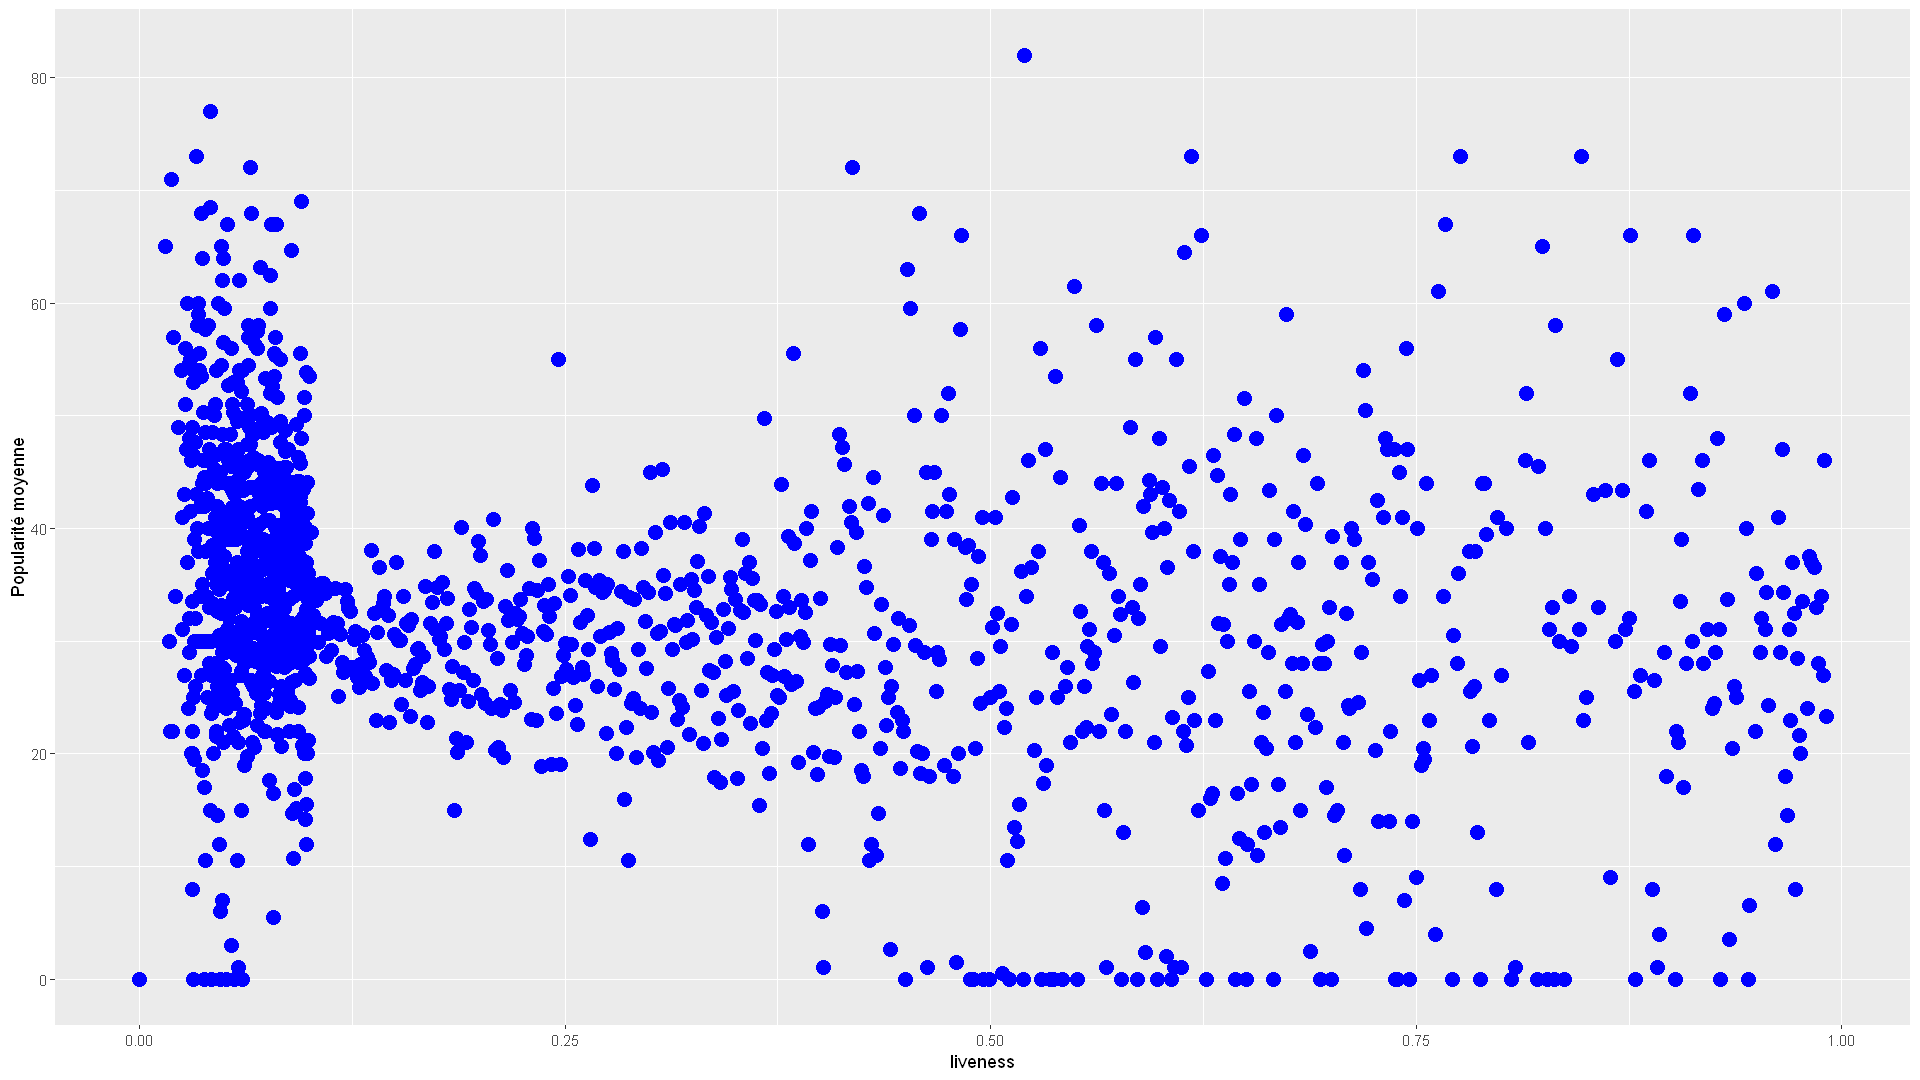

In [37]:
ax.data <- as.data.frame(short.songs %>%
    group_by(liveness) %>%
    mutate(popularity = mean(popularity)))

ggplot(ax.data, aes(x = liveness, y = popularity)) +
    geom_point(color = "blue", size = 4) +
    labs(y = "Popularité moyenne")

<b>Popularity</b> (variable à prédire)

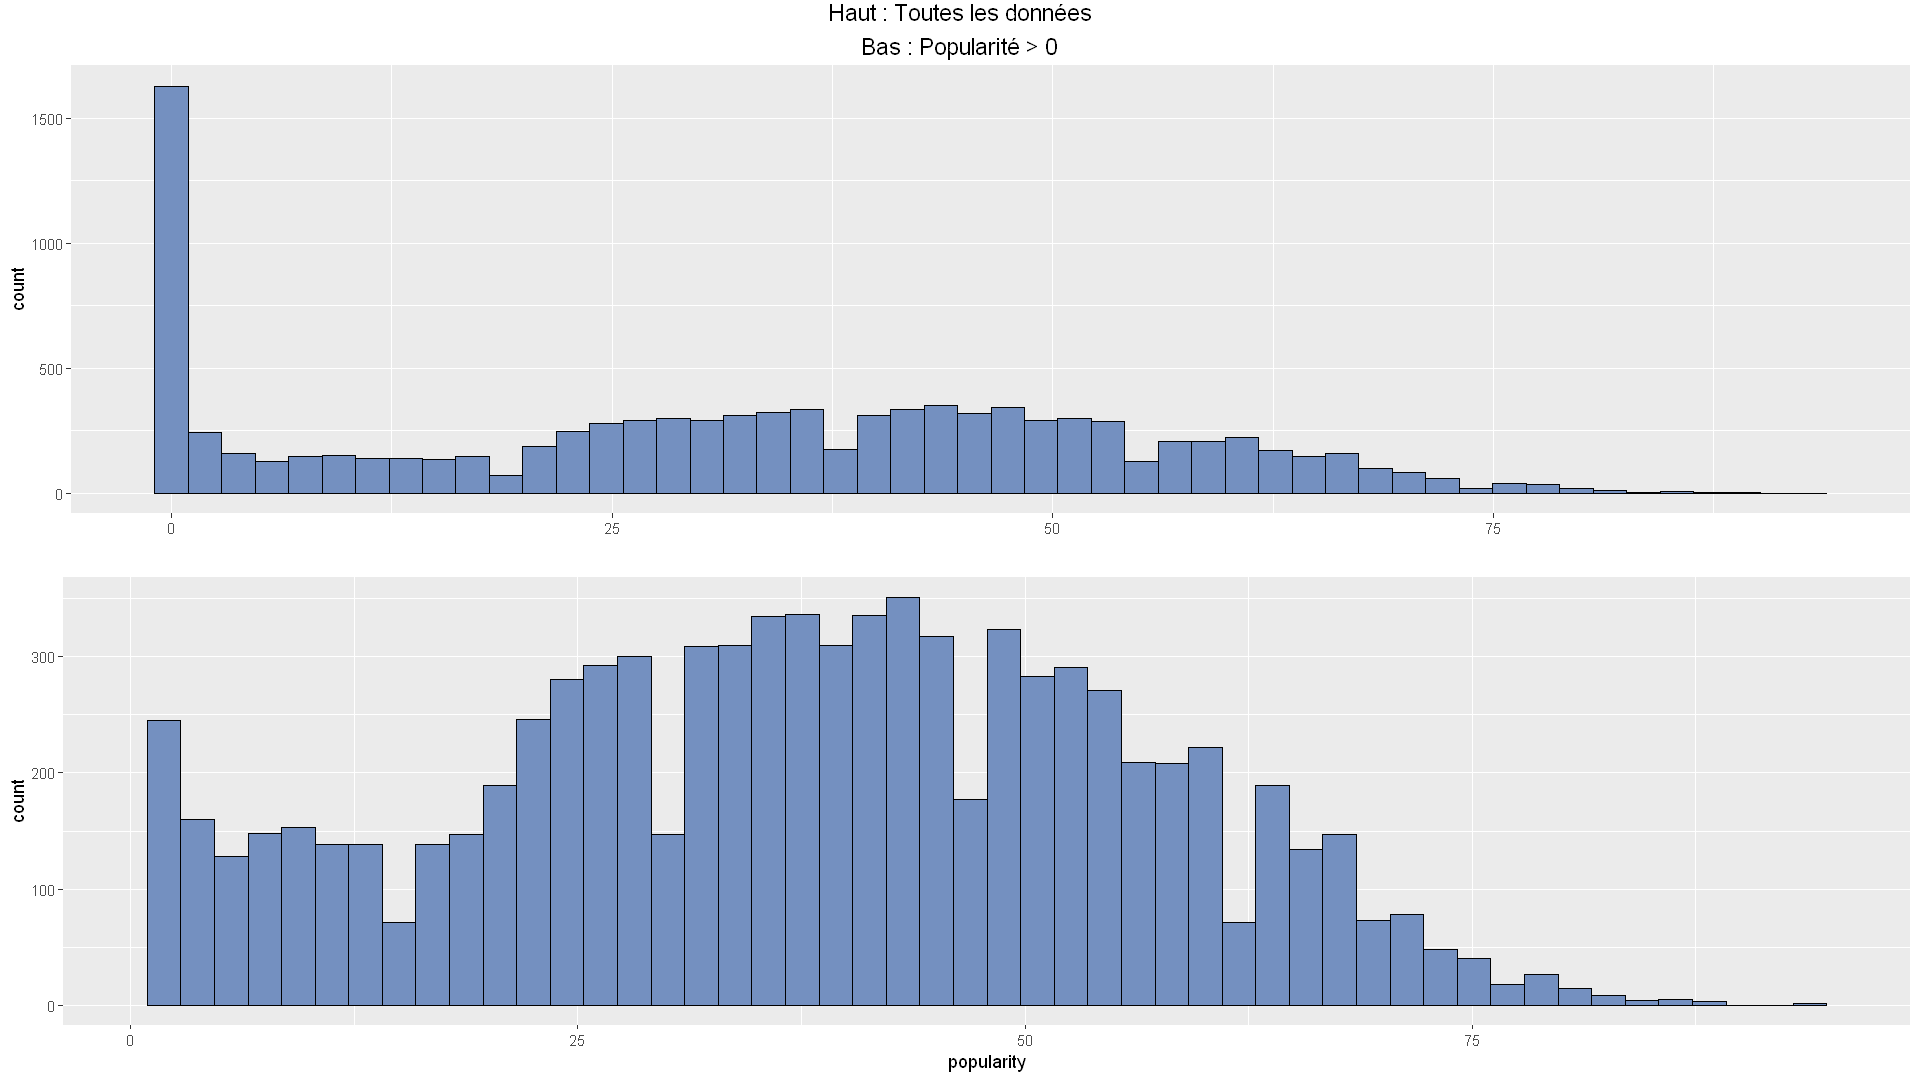

In [38]:
p1 <- ggplot(spotify_data, aes(x = popularity)) +
        geom_histogram(color = "black", fill = "#7490C0", bins = 50) +
        labs(x = "")

p2 <- ggplot(spotify_data[spotify_data$popularity > 0, ], aes(x = popularity)) +
        geom_histogram(color = "black", fill = "#7490C0", bins = 50)

grid.arrange(p1, p2, nrow = 2, heights=c(20, 20),
             top = textGrob(
                 "Haut : Toutes les données\nBas : Popularité > 0",
                 gp = gpar(fontsize = 14))
            )

On voit qu'il y a un nombre important de chansons ayant 0 comme popularité. En effet ces chansons sont proches de l'extraction de la base des données et donc leur popularité n'avait pas encore été déterminée.

<b>Year</b>

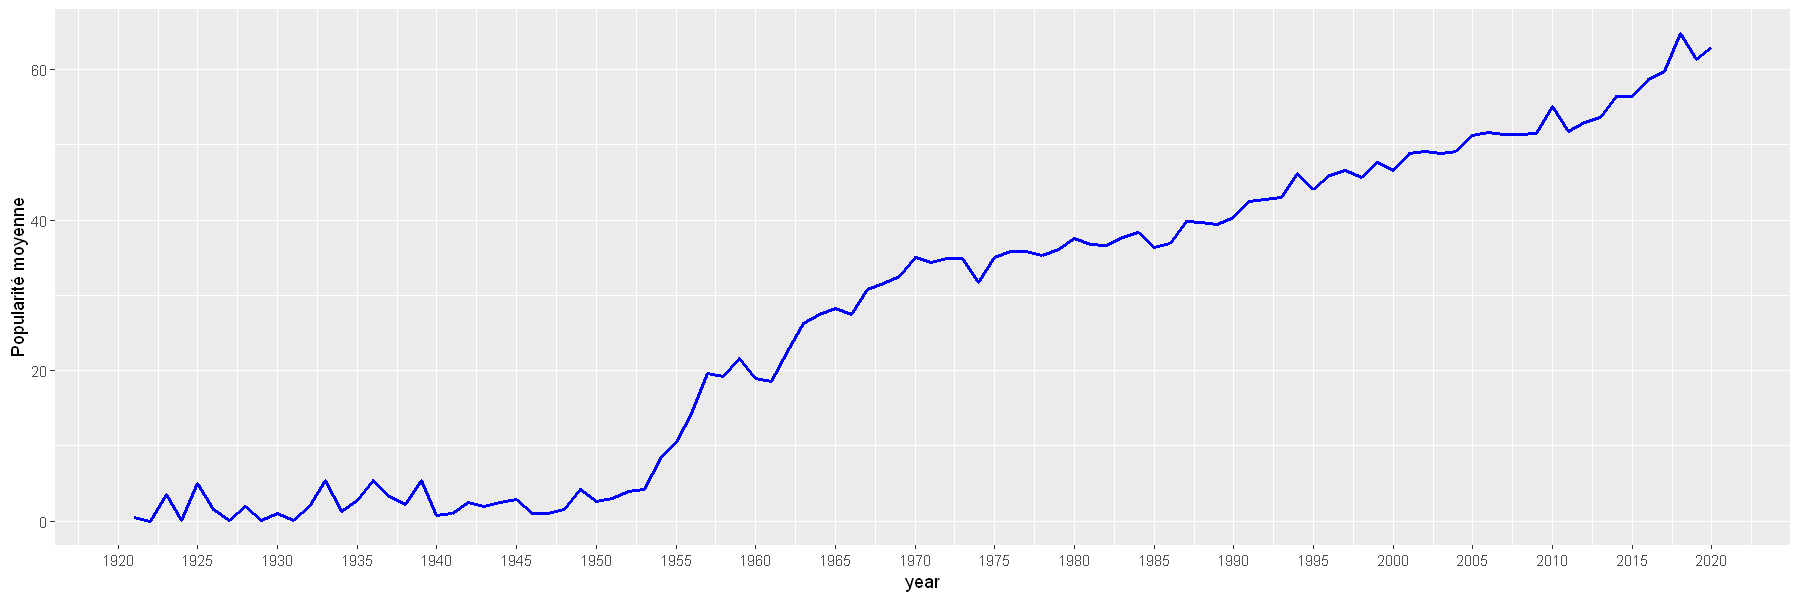

In [39]:
ax.data <- as.data.frame(spotify_data %>%
    group_by(year) %>%
    mutate(popularity = mean(popularity)))

options(repr.plot.width = 15, repr.plot.height = 5)

ggplot(data = ax.data, aes(x = year, y = popularity)) +
    geom_line(colour = "blue", size = 1) +
    scale_x_continuous(breaks = seq(1920, 2020, 5)) +
    labs(y = "Popularité moyenne")

<b>Tempo</b>

Loading required package: wrapr


Attaching package: 'wrapr'


The following objects are masked from 'package:Matrix':

    pack, unpack


The following object is masked from 'package:dplyr':

    coalesce




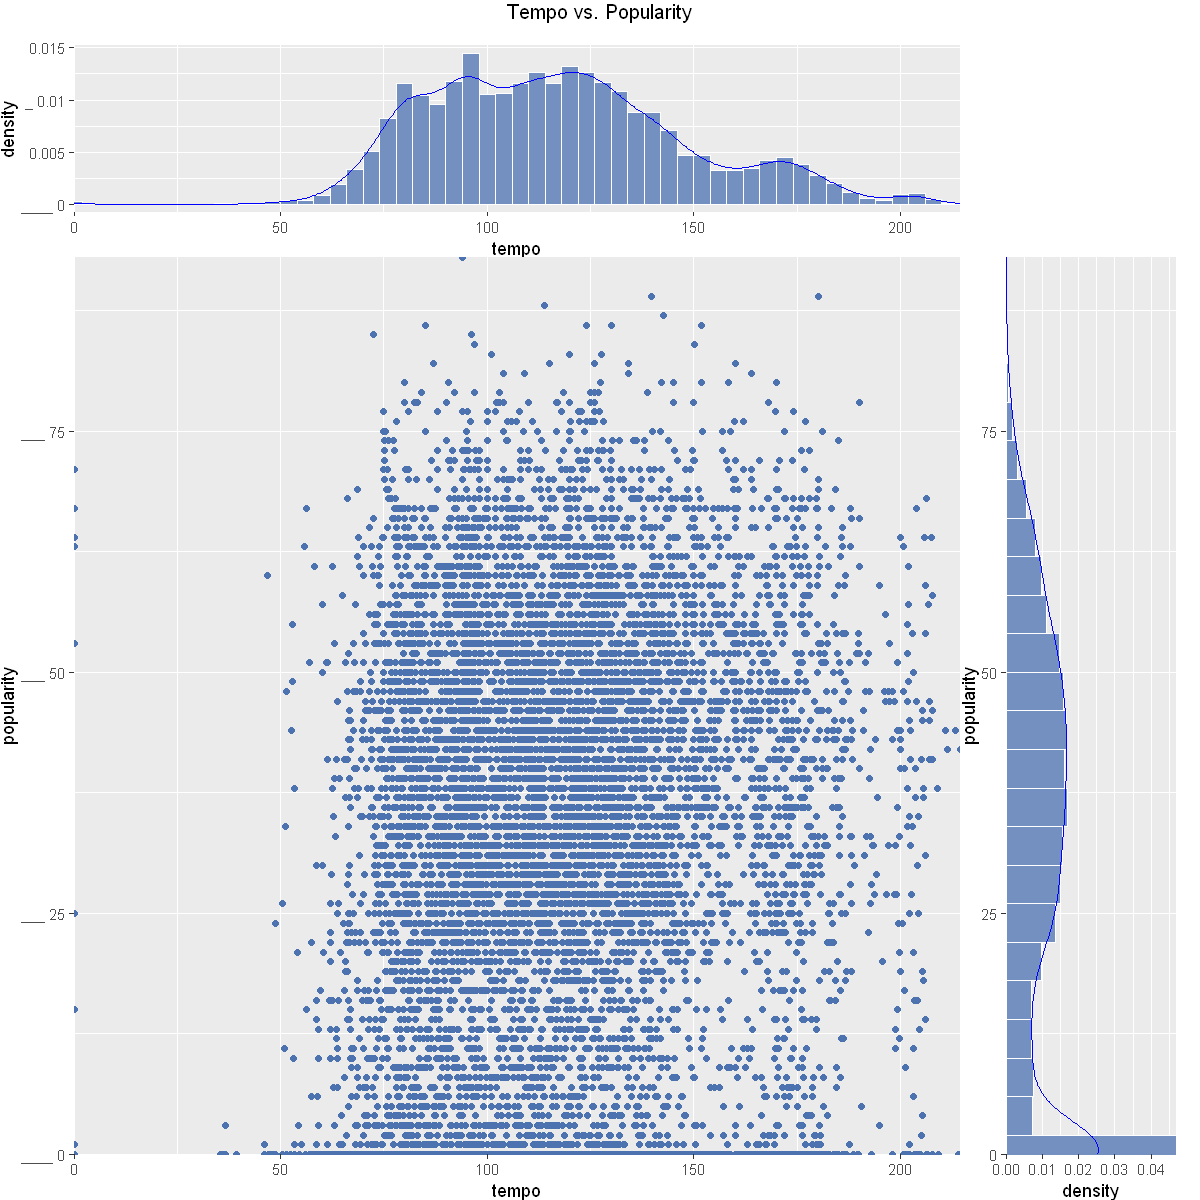

In [40]:
library(WVPlots)

options(repr.plot.width = 10, repr.plot.height = 10)
ScatterHist(spotify_data, "tempo", "popularity", title = "Tempo vs. Popularity",
            minimal_labels = FALSE, smoothmethod = "none", binwidth_x = 4,
            binwidth_y = 4, point_alpha = 1, point_color = "#4C72B0",
            hist_color = "#7490C0")

In [41]:
dim(spotify_data[spotify_data$tempo == 0, ])

[1] 13 15

On voit qu'il y a 13 chansons pour lesquelles `tempo` vaut 0 ce qui n'est pas possible.

In [42]:
corrected.tempo <- spotify_data[spotify_data$tempo > 0, ]$tempo
summary(corrected.tempo)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35.37   93.69  114.56  117.02  135.48  214.42 

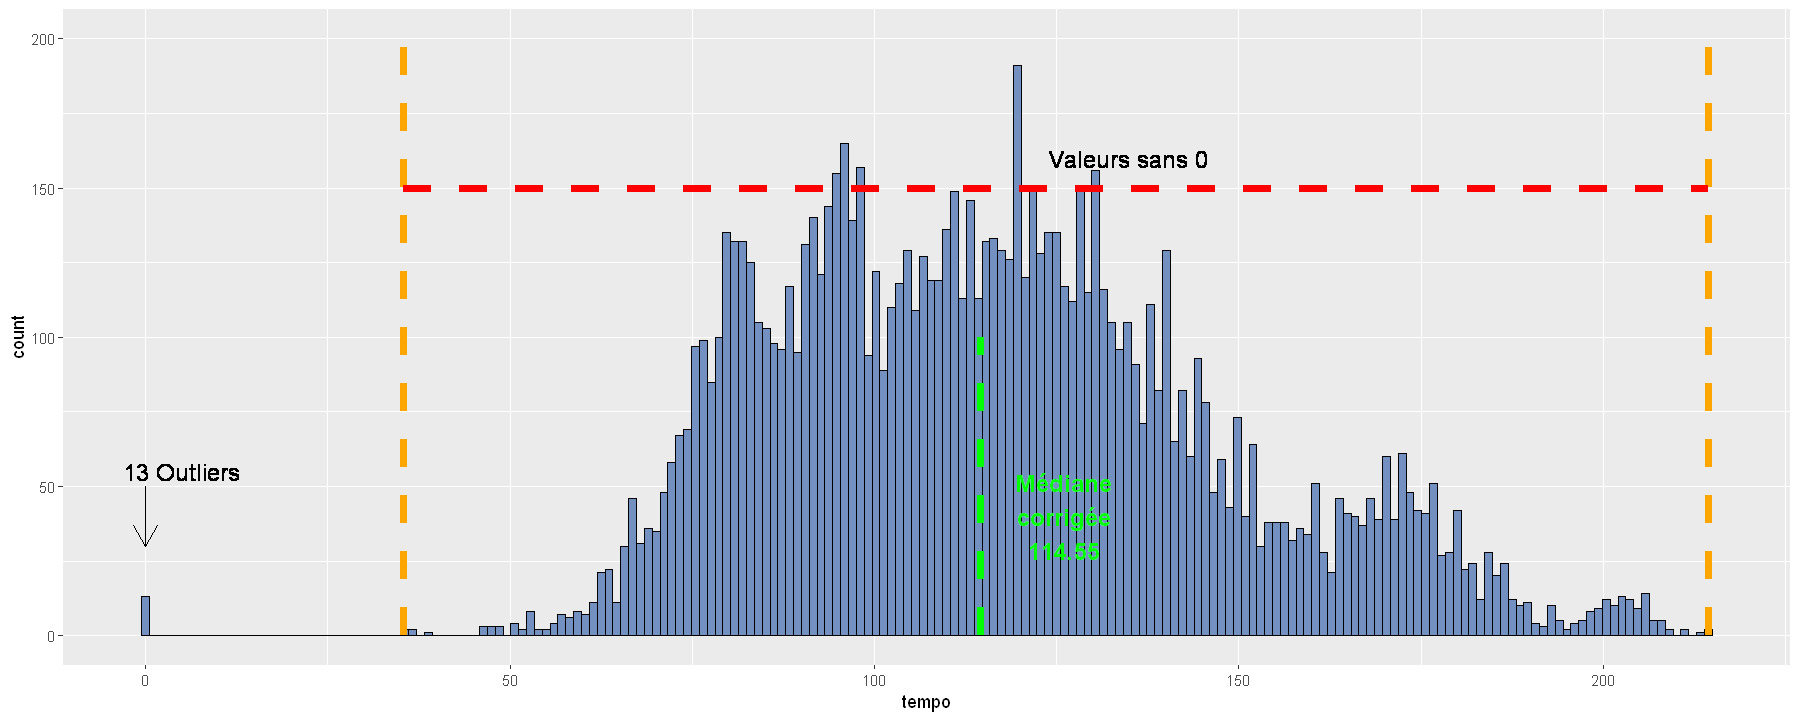

In [43]:
options(repr.plot.width = 15, repr.plot.height = 6)

ggplot(data = spotify_data, aes(x = tempo)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 200) +
    geom_text(x = 5, y = 55, label = "13 Outliers", size = 5) +
    geom_text(x = 135, y = 160, label = "Valeurs sans 0", size = 5) +
    annotate("text", x = 126, y = 40, label = "Médiane\ncorrigée\n114.55",
             size = 5, color = "green", fontface = 2) +
    geom_segment(aes(x = 114.55, y = 0, xend = 114.55, yend = 100),
                 linetype = "dashed", color = "green", size = 2) +
    geom_segment(aes(x = 35.37, y = 0, xend = 35.37, yend = 200),
                 linetype = "dashed", color = "orange", size = 2) +
    geom_segment(aes(x = 214.42, y = 0, xend = 214.42, yend = 200),
                 linetype = "dashed", color = "orange", size = 2) +
    geom_segment(aes(x = 0, y = 50, xend = 0, yend = 30),
                 arrow = arrow(length = unit(0.5, "cm"))) +
    geom_segment(aes(x = 35.37, y = 150, xend = 214.42, yend = 150),
                 linetype = "dashed", color = "red", size = 2)

On replace les valeurs où `tempo` = 0 par la médiane dans la colonne.

In [44]:
median <- median(spotify_data[spotify_data$tempo > 0, ]$tempo)
median

dat <- replace(spotify_data$tempo, spotify_data$tempo == 0, median)
spotify_data$tempo <- dat
summary(spotify_data$tempo)

[1] 114.555

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  35.37   93.71  114.56  117.01  135.47  214.42 

<b>Prétraitement de variables :</b>

On normalise la variable `danceability` vu sa ressemblance à une loi gaussienne puis on la supprime :

In [45]:
spotify_data <- spotify_data %>%
    mutate(dance_norm = (danceability - mean(danceability)) / sd(danceability),
           danceability = NULL)

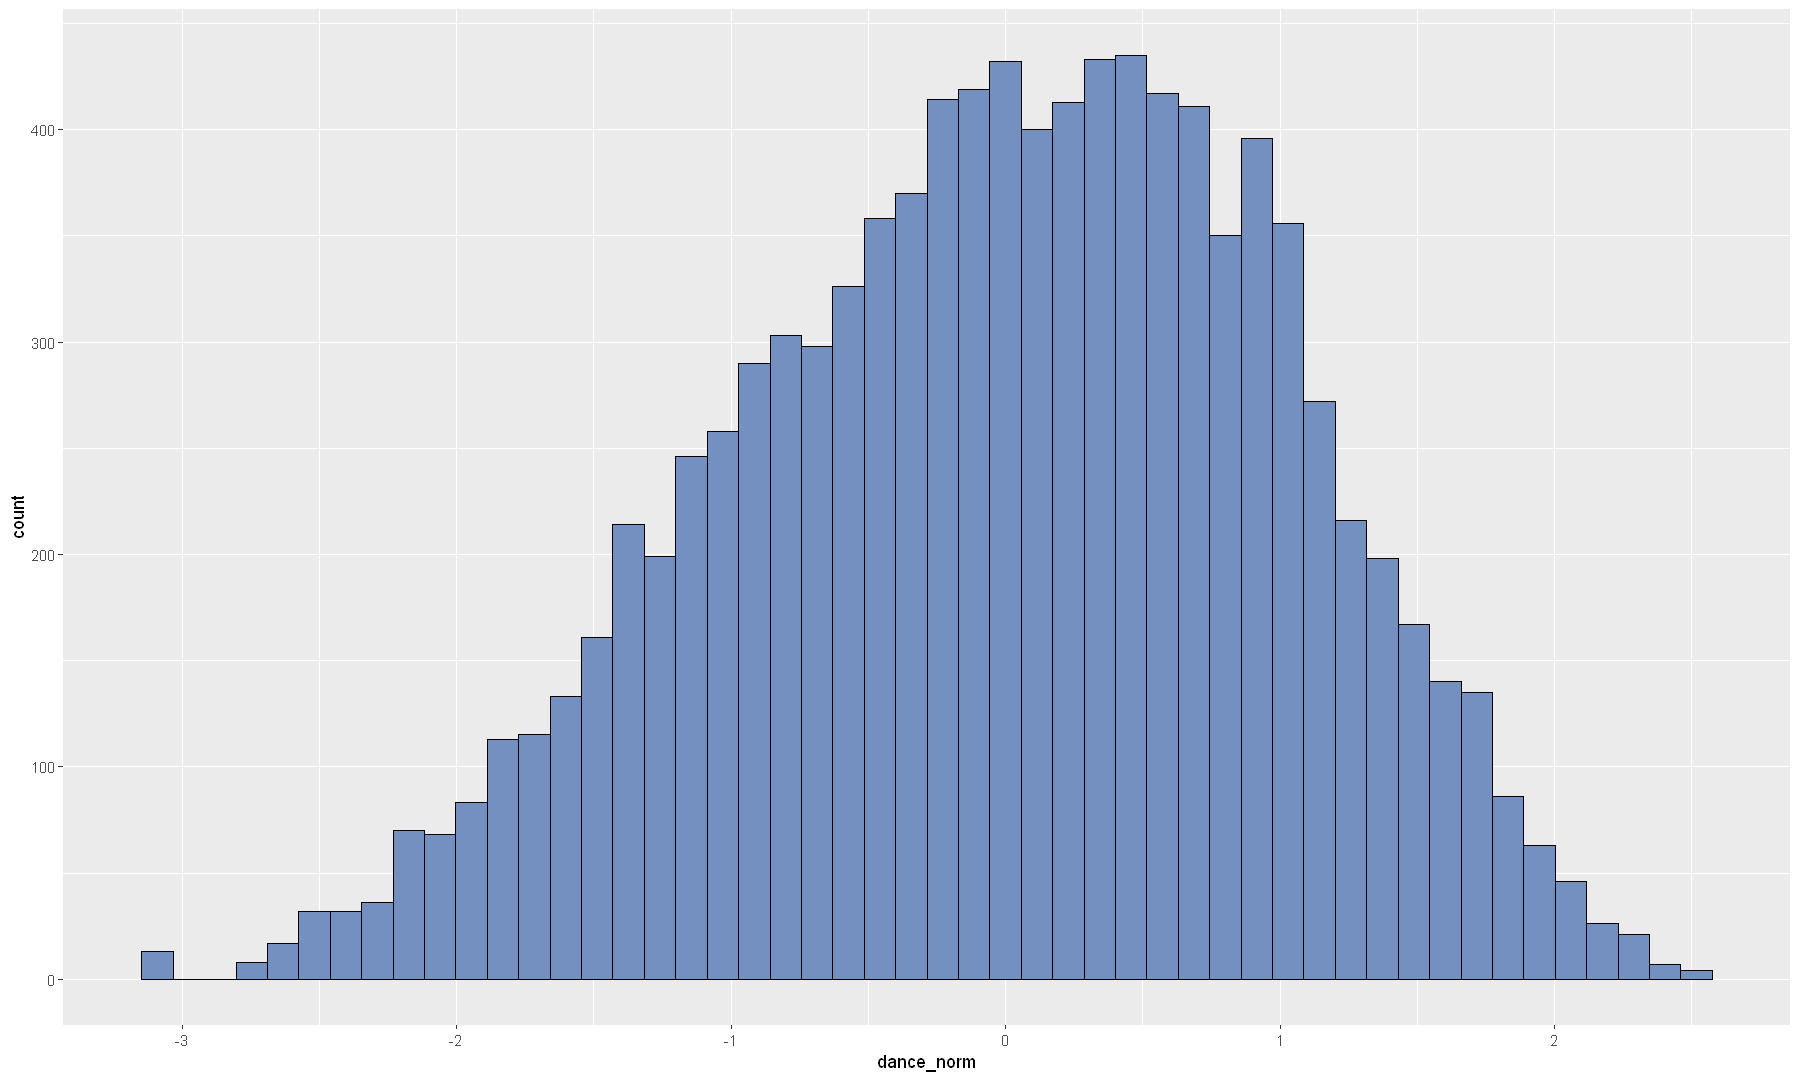

In [46]:
options(repr.plot.width = 15, repr.plot.height = 9)

ggplot(data = spotify_data, aes(x = dance_norm)) +
    geom_histogram(color = "black", fill = "#7490C0", bins = 50)

In [47]:
colnames(spotify_data)

[1] "valence"          "year"             "acousticness"     "duration"        
 [5] "energy"           "instrumentalness" "key"              "liveness"        
 [9] "loudness"         "mode"             "popularity"       "speechiness"     
[13] "tempo"            "pop.class"        "dance_norm"

In [48]:
# options(repr.plot.width = 20, repr.plot.height = 20)
# pairs(~., data = data.quant, col = mode)

In [49]:
# options(repr.plot.width = 20, repr.plot.height = 20)
# pairs(~., data = data.quant, col = key)

# ACP

In [50]:
data.quant <- spotify_data[, -c(7, 10, 11, 14)]
colnames(data.quant)

[1] "valence"          "year"             "acousticness"     "duration"        
 [5] "energy"           "instrumentalness" "liveness"         "loudness"        
 [9] "speechiness"      "tempo"            "dance_norm"

In [51]:
data.pca <- PCA(data.quant, scale.unit = T, graph = F, ncp = 11)

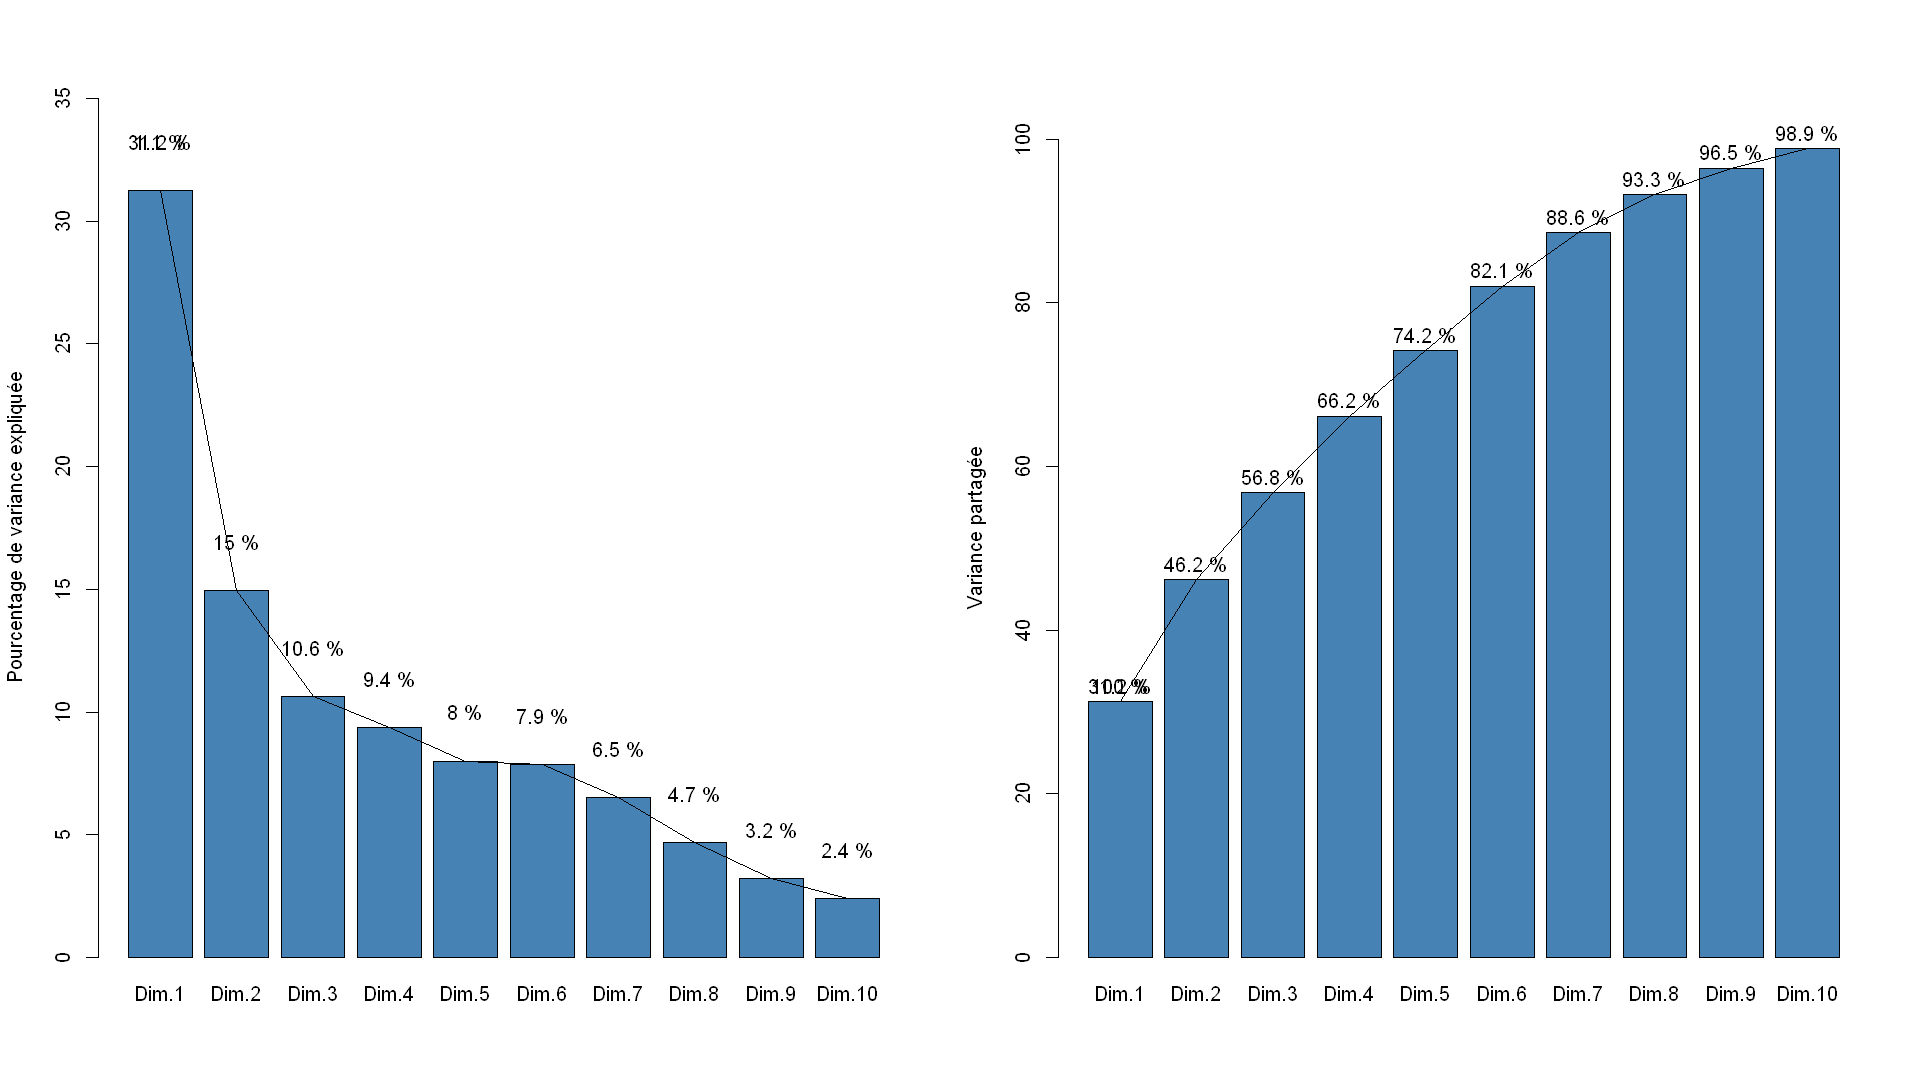

In [52]:
eig.val <- get_eig(data.pca)

options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(1, 2))

bp1 <- barplot(eig.val[1:10, 2], ylab = "Pourcentage de variance expliquée",
               ylim = c(0, 35), col = "#4682B4")
text(bp1, eig.val[1:10, 2] + 2, labels = paste(round(eig.val[, 2], 1), "%"))
lines(bp1, eig.val[1:10, 2])

bp2 <- barplot(eig.val[1:10, 3], ylab = "Variance partagée",
               ylim = c(0, 105), col = "#4682B4")
text(bp2, eig.val[1:10, 3] + 2, labels = paste(round(eig.val[, 3], 1), "%"))
lines(bp2, eig.val[1:10, 3])

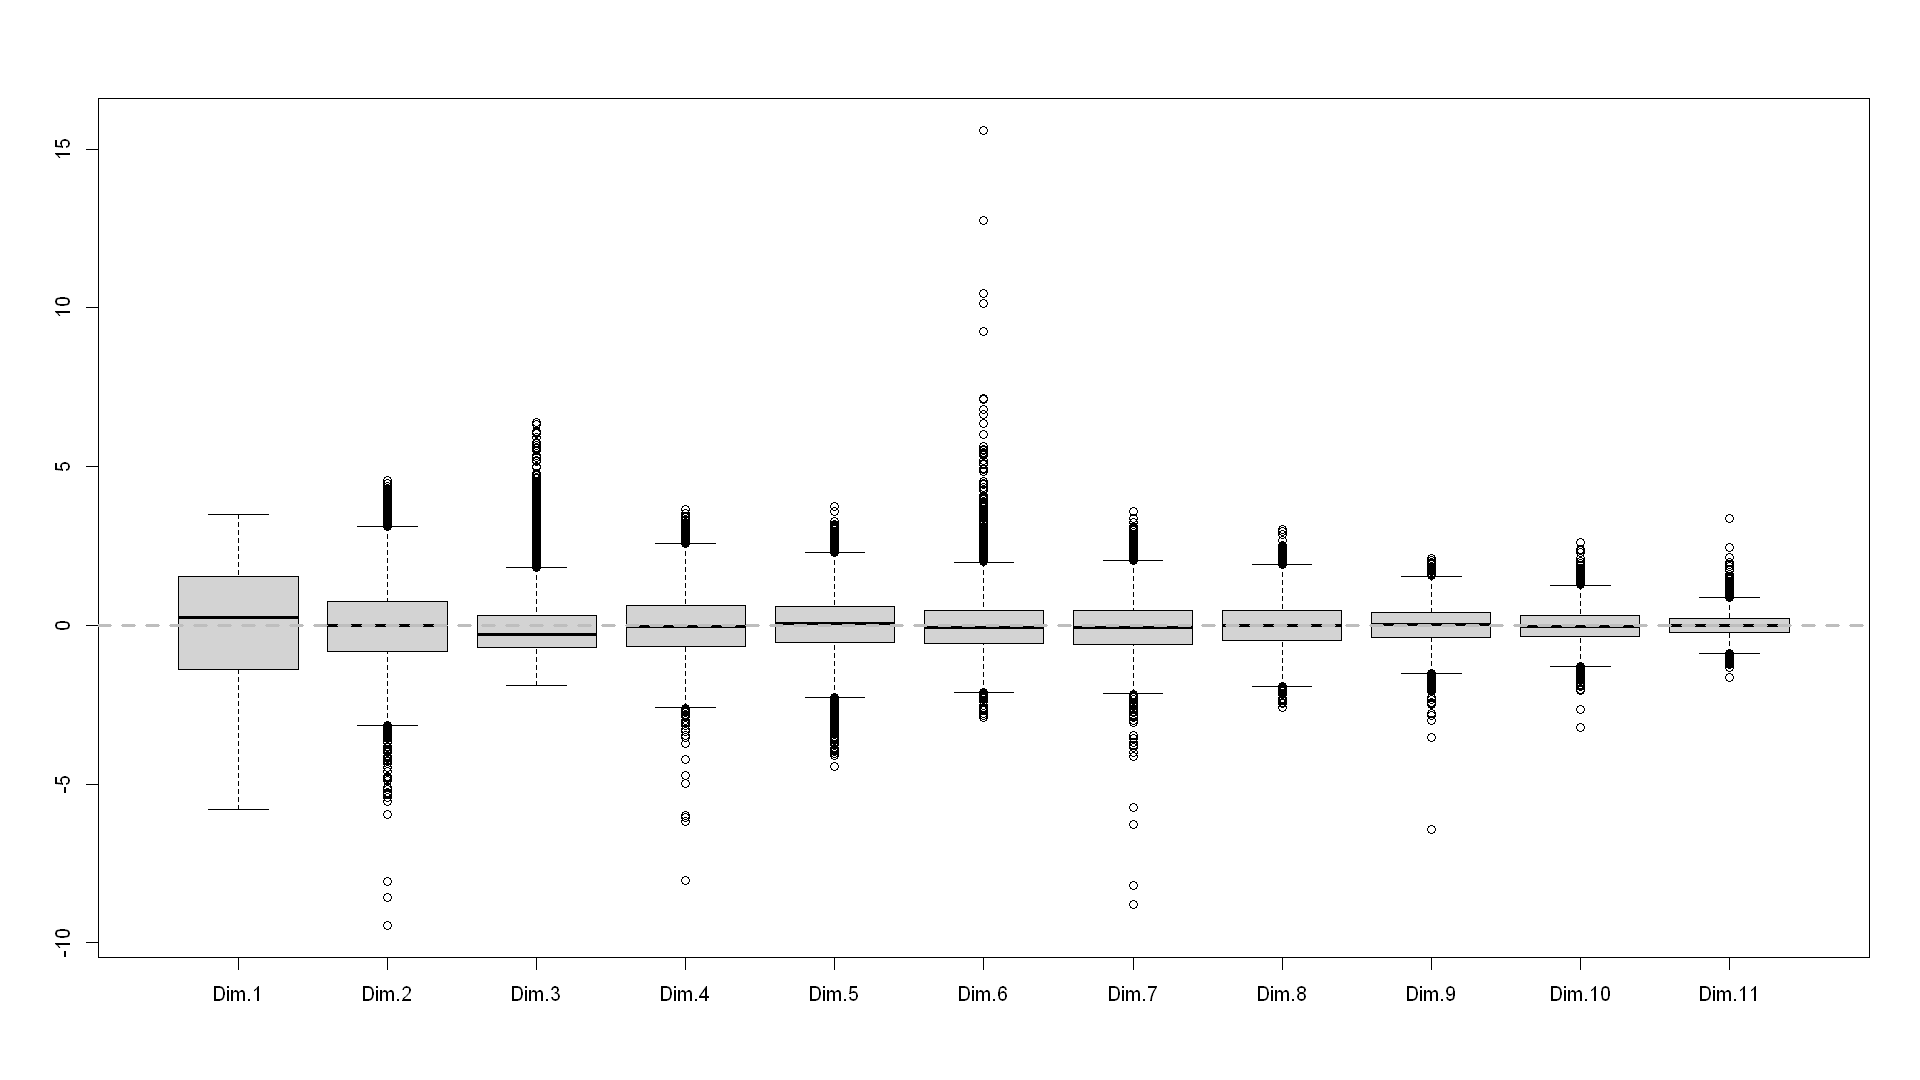

In [53]:
boxplot(data.pca$ind$coord)
abline(h = 0, col = "grey", lty = "dashed", lwd = 3)

Warning message:
"Using shapes for an ordinal variable is not advised"


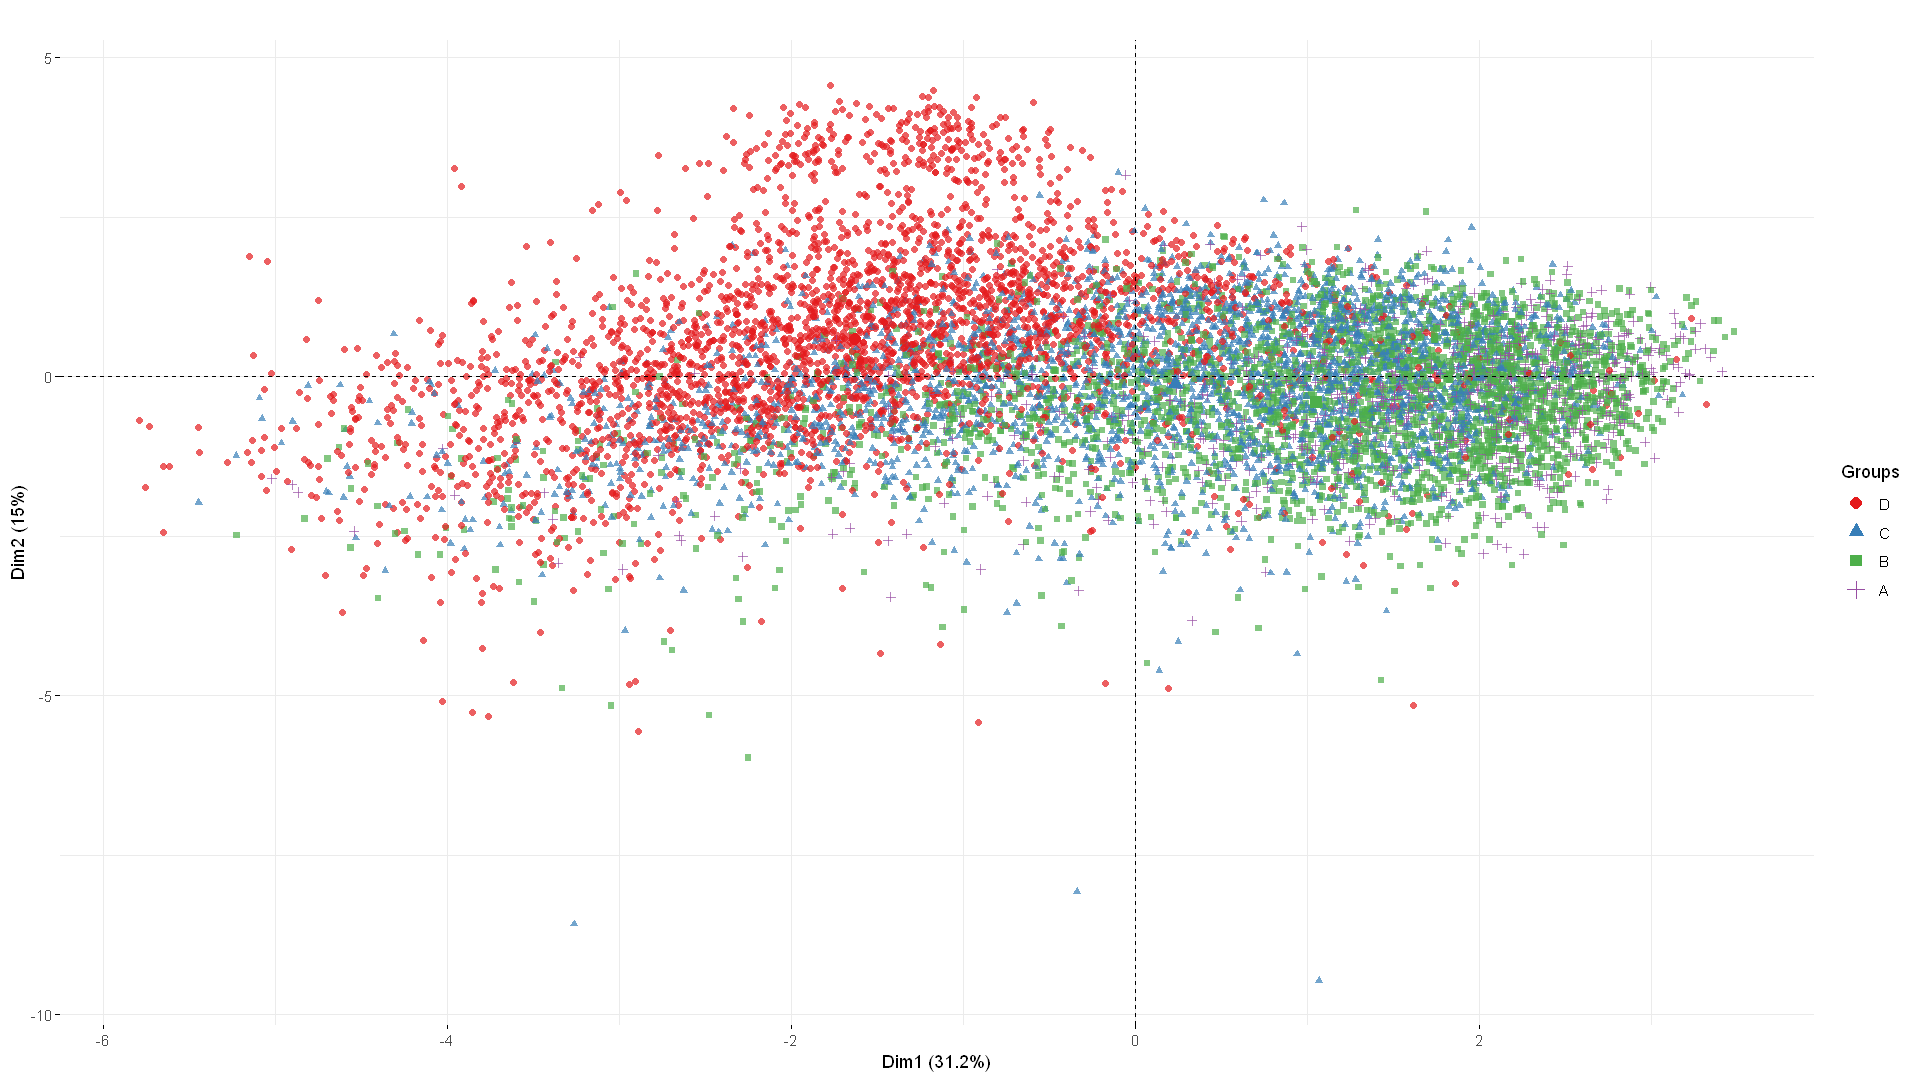

In [54]:
fviz_pca_ind(data.pca, geom = "point", title = "", alpha = .7,
             habillage = pop.class, palette = "Set1")

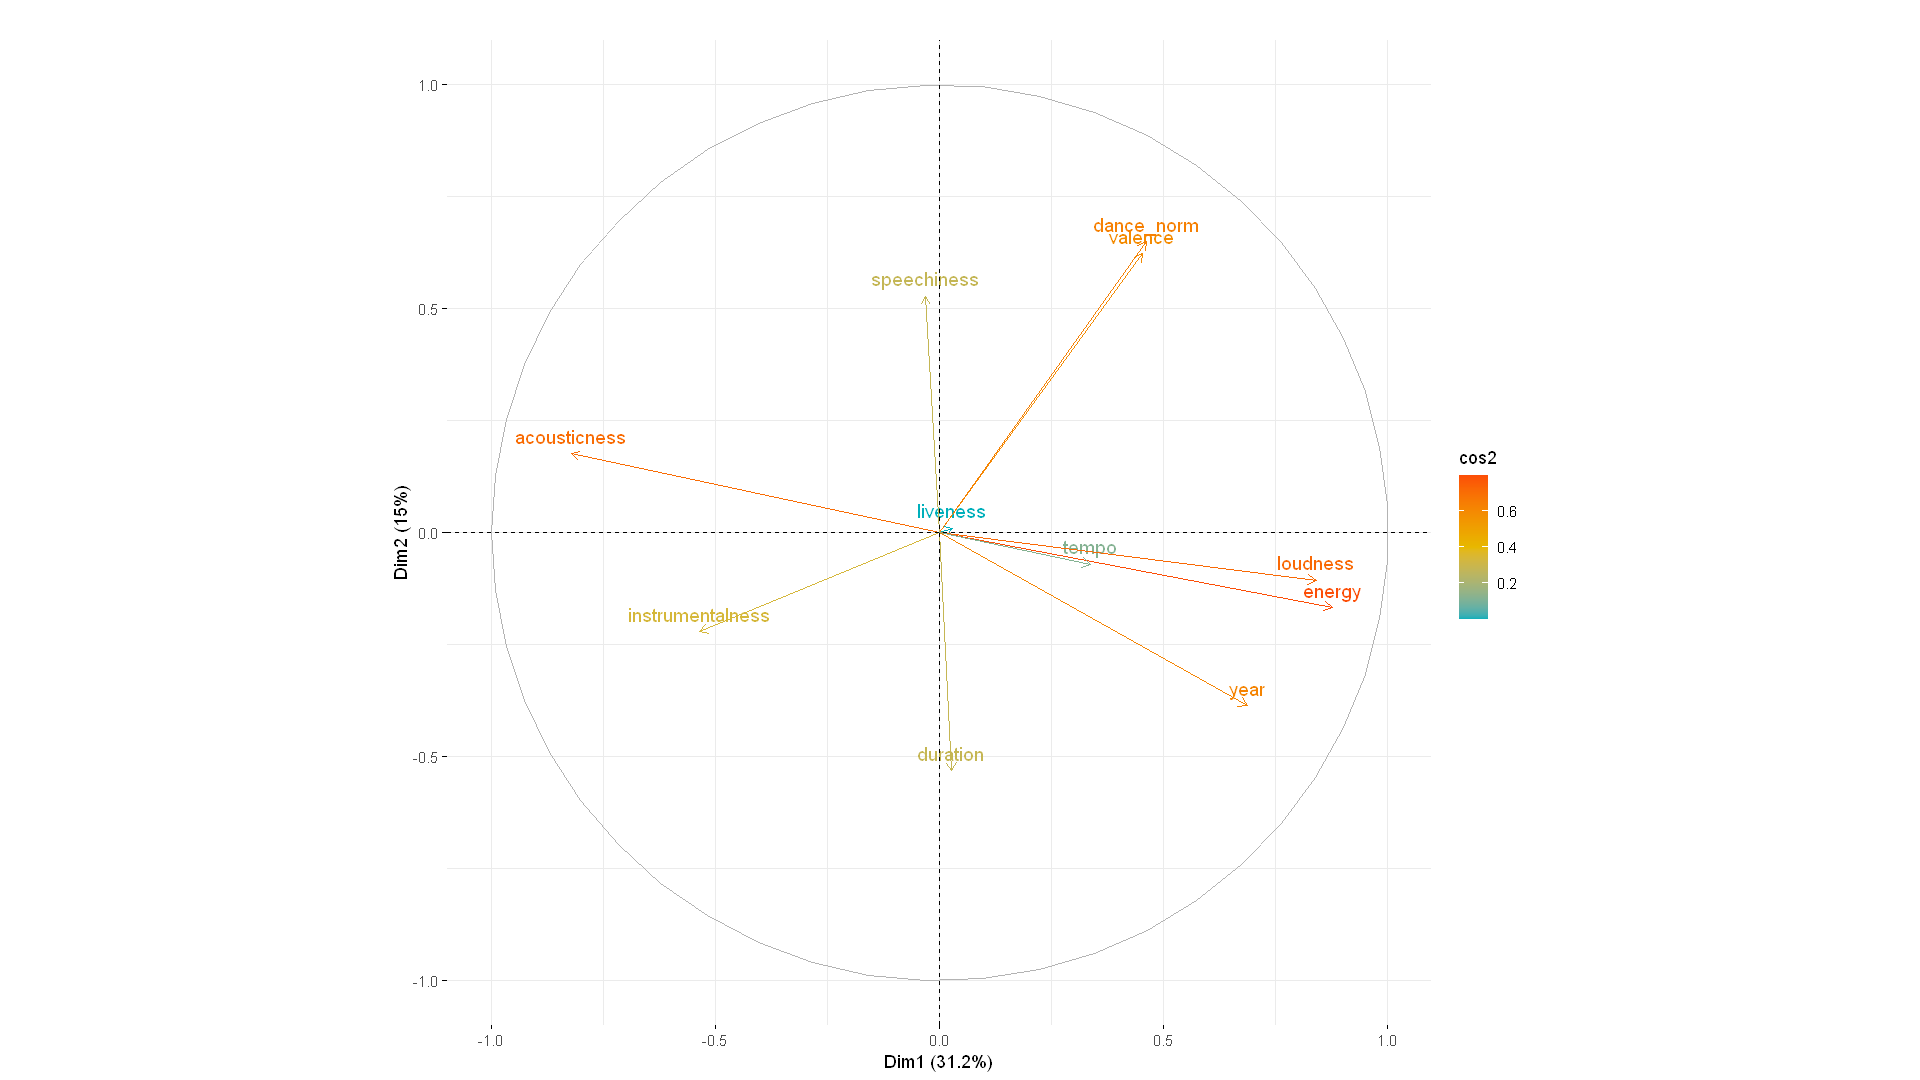

In [55]:
fviz_pca_var(data.pca, col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             title = "")

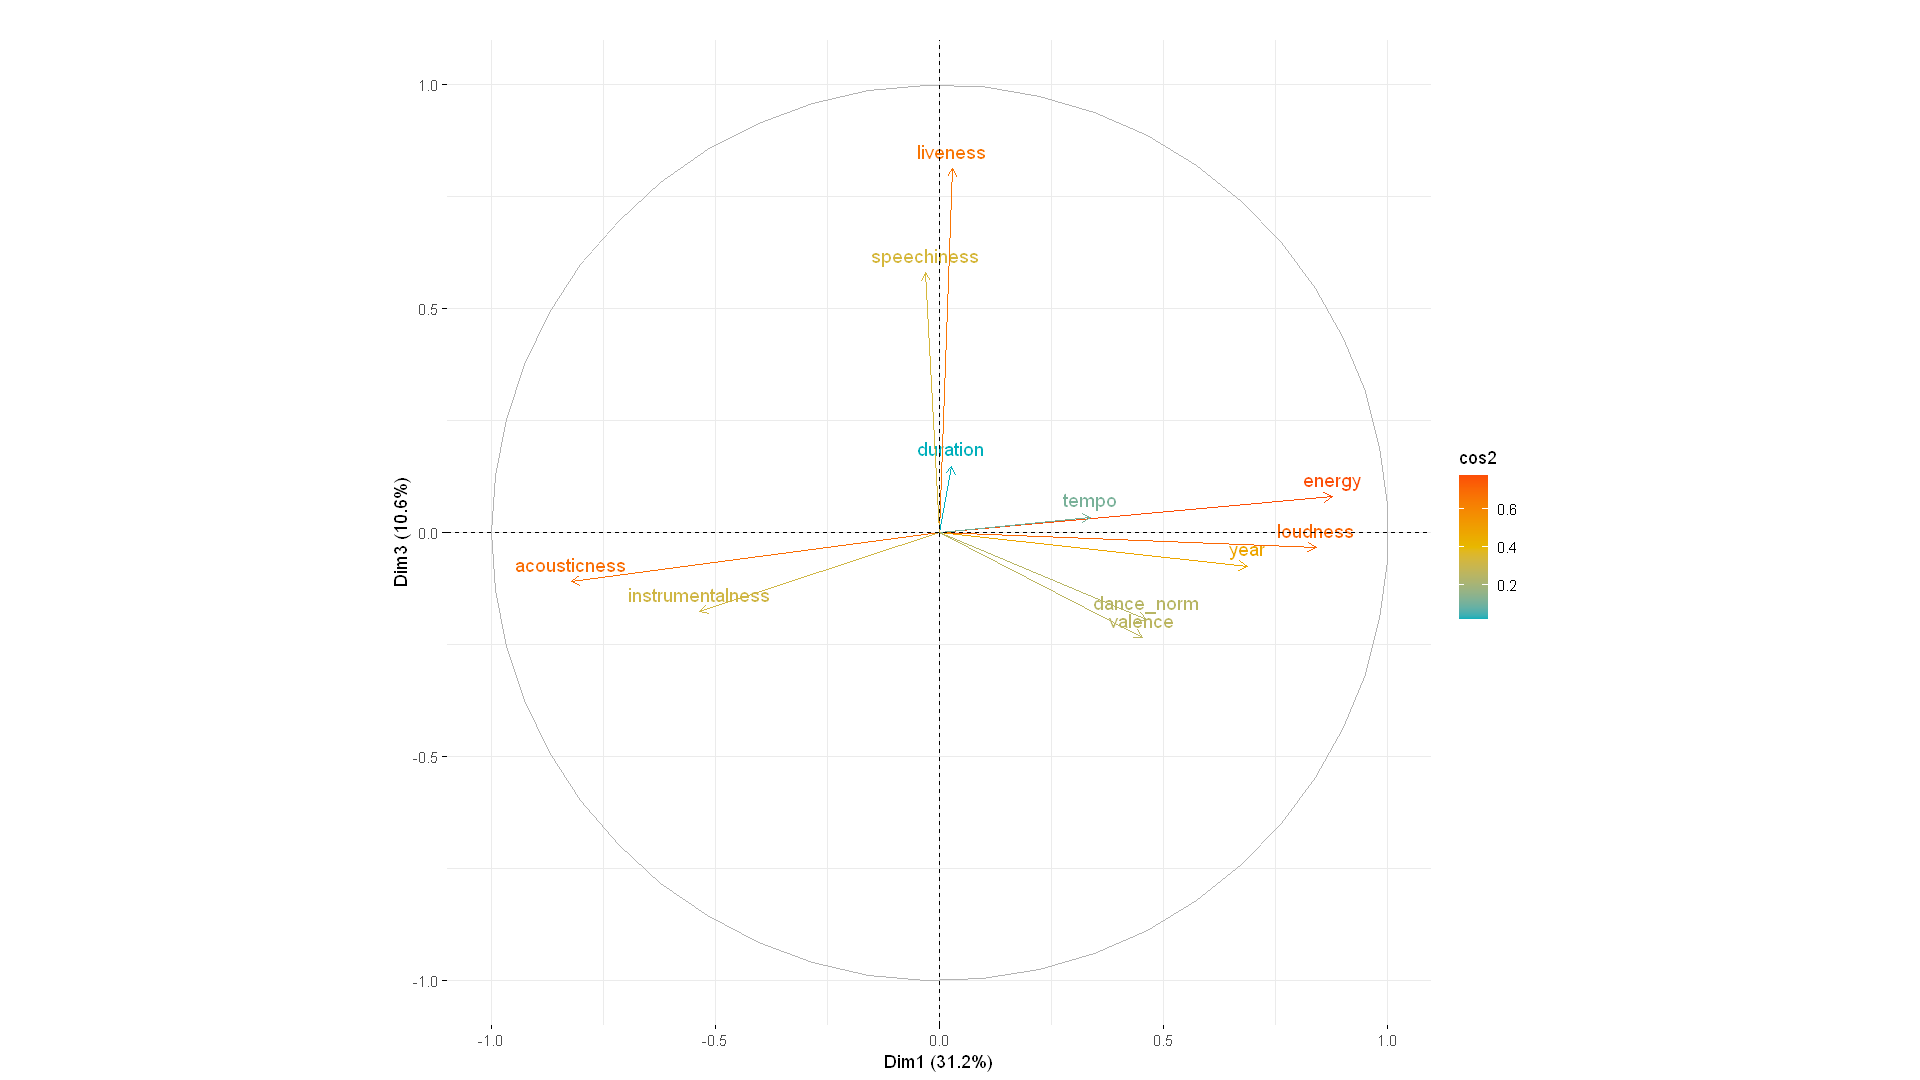

In [56]:
fviz_pca_var(data.pca, axes = c(1, 3), col.var = "cos2",
             gradient.cols = c("#00AFBB", "#E7B800", "#FC4E07"),
             title = "")

# Préparation des données

In [57]:
spotify.pop.class <- spotify_data$pop.class
spotify.key <- spotify_data$key

In [58]:
spotify.pop.class.encoded <- as.numeric(spotify.pop.class) - 1
spotify.pop.class.encoded[1:15]

[1] 1 2 3 1 1 3 2 2 3 2 0 2 1 0 0

In [59]:
spotify.key.encoded <- as.numeric(spotify.key) - 1
spotify.key.encoded[1:15]

[1]  2  1  2  2 10  5 10  7  5  9  3  2  9  1  8

In [60]:
spotify_data$key <- spotify.key.encoded
spotify_data$pop.class <- spotify.pop.class.encoded

In [61]:
head(spotify_data)

,valence,year,acousticness,duration,energy,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,pop.class,dance_norm
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>
161704,0.647,1975,0.4490,4.980667,0.827,7.88e-03,2,0.466,-7.604,1,25,0.3990,170.475,1,-0.9309645
168077,0.150,2008,0.8990,3.946667,0.169,1.12e-05,1,0.136,-11.332,1,42,0.0553,107.477,2,-0.1817845
35922,0.423,2007,0.0185,5.018217,0.878,8.39e-02,2,0.276,-5.576,0,65,0.0377,150.093,3,-0.3974575
135823,0.302,1995,0.0384,2.370000,0.980,5.52e-01,2,0.237,-3.154,1,36,0.0721,172.566,1,-2.0660858
165395,0.828,1994,0.5310,3.130000,0.625,7.73e-06,10,0.348,-11.963,0,38,0.0639,97.831,1,0.9363100
38184,0.489,2018,0.3710,5.403150,0.694,0.00e+00,5,0.109,-4.393,1,68,0.1690,122.080,3,1.7933266


In [62]:
X <- spotify_data[, -c(11, 14)]
y_class <- spotify_data$pop.class
y_reg <- spotify_data$popularity

In [63]:
head(X)

,valence,year,acousticness,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,dance_norm
,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>
161704,0.647,1975,0.4490,4.980667,0.827,7.88e-03,2,0.466,-7.604,1,0.3990,170.475,-0.9309645
168077,0.150,2008,0.8990,3.946667,0.169,1.12e-05,1,0.136,-11.332,1,0.0553,107.477,-0.1817845
35922,0.423,2007,0.0185,5.018217,0.878,8.39e-02,2,0.276,-5.576,0,0.0377,150.093,-0.3974575
135823,0.302,1995,0.0384,2.370000,0.980,5.52e-01,2,0.237,-3.154,1,0.0721,172.566,-2.0660858
165395,0.828,1994,0.5310,3.130000,0.625,7.73e-06,10,0.348,-11.963,0,0.0639,97.831,0.9363100
38184,0.489,2018,0.3710,5.403150,0.694,0.00e+00,5,0.109,-4.393,1,0.1690,122.080,1.7933266


In [64]:
print(y_reg[1:15])
print(y_class[1:15])

 [1] 25 42 65 36 38 68 47 59 61 49 16 58 26  0  0
 [1] 1 2 3 1 1 3 2 2 3 2 0 2 1 0 0


# Apprentissage

In [65]:
set.seed(42)
test.ratio <- 0.2
npop <- nrow(spotify_data)
nvar <- ncol(spotify_data)
ntest <- ceiling(npop * test.ratio)
testi <- sample(1:npop, ntest)
appri <- setdiff(1:npop, testi)

In [66]:
# construction de l'échantillon d'apprentissage
datappr <- X[appri, ]
# construction de l'échantillon test
datestr <- X[testi, ]
# vérification
str(datappr)
str(datestr)
# summary(datappr)

'data.frame':	8000 obs. of  13 variables:
 $ valence         : num  0.647 0.423 0.302 0.828 0.489 0.963 0.411 0.463 0.151 0.42 ...
 $ year            : int  1975 2007 1995 1994 2018 2003 1980 2001 1959 2013 ...
 $ acousticness    : num  0.449 0.0185 0.0384 0.531 0.371 0.523 0.36 0.137 0.987 0.167 ...
 $ duration        : num  4.98 5.02 2.37 3.13 5.4 ...
 $ energy          : num  0.827 0.878 0.98 0.625 0.694 0.615 0.732 0.562 0.0359 0.736 ...
 $ instrumentalness: num  7.88e-03 8.39e-02 5.52e-01 7.73e-06 0.00 1.48e-06 3.14e-04 2.90e-03 7.27e-05 8.78e-03 ...
 $ key             : num  2 2 2 10 5 10 5 9 3 2 ...
 $ liveness        : num  0.466 0.276 0.237 0.348 0.109 0.0794 0.0755 0.0463 0.121 0.124 ...
 $ loudness        : num  -7.6 -5.58 -3.15 -11.96 -4.39 ...
 $ mode            : Factor w/ 2 levels "0","1": 2 1 2 1 2 2 2 1 2 1 ...
 $ speechiness     : num  0.399 0.0377 0.0721 0.0639 0.169 0.092 0.0282 0.045 0.0446 0.0384 ...
 $ tempo           : num  170.5 150.1 172.6 97.8 122.1 ...
 $ da

## Classification

In [67]:
y.appr.class <- as.factor(y_class[appri])
y.test.class <- as.factor(y_class[testi])

### Regression Logistique

### Random Forests

In [82]:
library(randomForest)

rf.class <- randomForest(y.appr.class ~ ., data = datappr,
                         xtest = datestr, ytest = y.test.class,
                         ntree = 500, do.trace = 50, importance = TRUE)

randomForest 4.6-14

Type rfNews() to see new features/changes/bug fixes.


Attaching package: 'randomForest'


The following object is masked from 'package:gridExtra':

    combine


The following object is masked from 'package:ggplot2':

    margin


The following object is masked from 'package:dplyr':

    combine




ntree      OOB      1      2      3      4|    Test      1      2      3      4
   50:  28.64% 10.12% 29.62% 34.86% 68.52%|  26.85%  9.32% 30.42% 32.49% 56.04%
  100:  27.25%  9.57% 26.59% 34.99% 64.81%|  26.50%  9.16% 29.41% 32.85% 55.07%
  150:  26.76%  9.33% 26.34% 33.92% 64.55%|  26.50%  8.85% 29.24% 33.03% 56.04%
  200:  26.61%  9.45% 25.66% 34.09% 64.15%|  26.35%  9.01% 28.91% 32.85% 55.56%
  250:  26.60%  9.33% 25.45% 34.26% 64.55%|  26.20%  9.01% 28.57% 32.67% 55.56%
  300:  26.65%  9.33% 25.71% 34.05% 64.95%|  26.45%  9.16% 28.57% 33.39% 55.56%
  350:  26.39%  9.10% 25.41% 33.83% 64.55%|  26.50%  9.01% 28.57% 33.57% 56.04%
  400:  26.44%  9.10% 25.41% 34.13% 64.15%|  26.60%  9.16% 29.08% 33.21% 56.04%
  450:  26.24%  9.06% 25.33% 33.75% 63.62%|  26.80%  9.16% 30.08% 33.03% 55.56%
  500:  26.26%  9.02% 25.41% 33.75% 63.76%|  26.65%  9.16% 29.58% 33.03% 55.56%


In [ ]:
set.seed(1)
eps <- 5e-02
bestMtry <- tuneRF(datappr, y.appr.class, mtryStart = 2,
                   stepFactor = 2, improve = eps,
                   ntree = 500, trace = TRUE, plot = FALSE)

In [ ]:
library(caret)
# cvControl=trainControl(method='cv',number=10) rfFit =
# train(datappr[,-11], datappr[,'pop.class'],method = 'rf', tuneLength = 8,
# trControl = cvControl, trace=FALSE)

In [ ]:
library(mlbench)

rfFit <- train(datappr, y.appr.class, "rf")

In [ ]:
pred.rf <- predict(rfFit, newdata = datestr)
table(pred.rf, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.rf, y.test.class)))/ntest), 1), " %", sep = "")

### Decision Trees

### SVC Linear Kernel

In [84]:
library(e1071)

svm.class0 <- svm(y.appr.class ~ ., data = datappr, type = "C")
summary(svm.class0)


Call:
svm(formula = y.appr.class ~ ., data = datappr, type = "C")


Parameters:
   SVM-Type:  C-classification 
 SVM-Kernel:  radial 
       cost:  1 

Number of Support Vectors:  5487

 ( 1947 754 1952 834 )


Number of Classes:  4 

Levels: 
 0 1 2 3




In [88]:
svc.lin.tune <- tune.svm(y.appr.class ~ ., data = datappr, type = "C",
                         kernel = "lin", cross = 5, cost = c(1, 1.5, 2, 2.5, 3, 3.5))
plot(svc.lin.tune)

ERROR: Error in model.frame.default(formula, data): variable lengths differ (found for 'valence')


In [ ]:
svc.lin <- svm(pop.class ~ ., data = datappr, type = "C",
               cost = svc.lin.tune$best.parameters$cost)

In [ ]:
# Linear kernel
pred.lin <- predict(svc.lin, datestr)
table(pred.lin, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.lin, y.test.class)))/ntest), 1), " %", sep = "")

### SVC Polynomial Kernel

In [ ]:
svc.poly.tune <- tune.svm(pop.class ~ ., data = datappr, type = "C",
                          kernel = "poly", coef0 = -5:5,
                          cost = c(1, 1.5, 2, 2.5, 3, 3.5))
plot(svc.poly.tune)

In [ ]:
svc.poly <- svm(pop.class ~ ., data = datappr, type = "C",
                coef0 = svc.poly.tune$best.parameters$coef0,
                cost = svc.poly.tune$best.parameters$cost)

In [ ]:
pred.poly <- predict(svc.poly, datestr)
table(pred.poly, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.poly, y.test.class)))/ntest), 1), " %", sep = "")

### SVC Radial Kernel

In [ ]:
svc.rad.tune <- tune.svm(pop.class ~ ., data = datappr, type = "C",
                         kernel = "radial", cost = c(1, 1.5, 2, 2.5, 3, 3.5),
                         gamma = seq(0.02, 0.1, by = 0.02))
plot(svc.rad.tune)

In [ ]:
svc.rad <- svm(pop.class ~ ., data = datappr, type = "C",
               cost = svc.rad.tune$best.parameters$cost,
               gamma = svc.rad.tune$best.parameters$gamma)

In [ ]:
pred.rad <- predict(svc.rad, datestr)
table(pred.rad, y.test.class)
paste("Prediction error: ",
      round(100 * (1 - sum(diag(table(pred.rad, y.test.class)))/ntest), 1), " %", sep = "")

### Réseaux de neurones

In [68]:
library(nnet)

nnet.dis <- nnet(y.appr.class ~ ., data = datappr, size = 5, decay = 0)
summary(nnet.dis)

# weights:  94
initial  value 12215.979701 
final  value 10456.025826 
converged


a 13-5-4 network with 94 weights
options were - softmax modelling 
  b->h1  i1->h1  i2->h1  i3->h1  i4->h1  i5->h1  i6->h1  i7->h1  i8->h1  i9->h1 
   0.61    0.39    0.47    0.17   -0.52   -0.49    0.17   -0.38    0.49   -0.26 
i10->h1 i11->h1 i12->h1 i13->h1 
   0.40    0.08    0.43    0.69 
  b->h2  i1->h2  i2->h2  i3->h2  i4->h2  i5->h2  i6->h2  i7->h2  i8->h2  i9->h2 
  -0.31   -0.45    0.31   -0.68    0.66   -0.07   -0.63   -0.42   -0.55   -0.68 
i10->h2 i11->h2 i12->h2 i13->h2 
   0.61   -0.43    0.66   -0.20 
  b->h3  i1->h3  i2->h3  i3->h3  i4->h3  i5->h3  i6->h3  i7->h3  i8->h3  i9->h3 
   0.61   -0.51    0.50    0.37    0.20    0.45    0.00   -0.18    0.55   -0.60 
i10->h3 i11->h3 i12->h3 i13->h3 
  -0.60    0.31    0.63   -0.43 
  b->h4  i1->h4  i2->h4  i3->h4  i4->h4  i5->h4  i6->h4  i7->h4  i8->h4  i9->h4 
  -0.09   -0.42    0.60    0.08   -0.17   -0.47    0.66   -0.16   -0.02   -0.39 
i10->h4 i11->h4 i12->h4 i13->h4 
  -0.23    0.21    0.35   -0.42 
  b->h5  i1->h5  i2->

In [81]:
pred <- stats::predict(nnet.dis, newdata = datestr)
cm <- table(pred, y.test.class)
taux <- sum(diag(cm))/sum(cm)

ERROR: Error in table(pred, y.test.class): all arguments must have the same length


In [80]:
pred

,0,1,2,3
126891,0.3173734,0.296625,0.291502,0.09449963
147565,0.3173734,0.296625,0.291502,0.09449963
82623,0.3173734,0.296625,0.291502,0.09449963
69688,0.3173734,0.296625,0.291502,0.09449963
31742,0.3173734,0.296625,0.291502,0.09449963
117085,0.3173734,0.296625,0.291502,0.09449963
143794,0.3173734,0.296625,0.291502,0.09449963
100823,0.3173734,0.296625,0.291502,0.09449963
107437,0.3173734,0.296625,0.291502,0.09449963
24277,0.3173734,0.296625,0.291502,0.09449963


In [76]:
cm
taux

    y.test.class
pred   0   1   2   3
   0 644 595 554 207

[1] 0.322

In [ ]:
library(e1071)

mod <- tune.nnet(y.appr.class ~ ., data = datappr, size = 1:5, decay = 1:10)

## Régression

In [ ]:
y.appr.reg <- y_reg[appri]
y.test.reg <- y_reg[testi]

In [ ]:
plot.res <- function(x, y, titre = "titre") {
    plot(x, y, col = "blue", xlim = c(0, 250), ylim = c(-100, 100), ylab = "Résidus", 
        xlab = "Valeurs prédites", main = titre, pch = 20)
    # points(x2, y, col='red')
    abline(h = 0, col = "green")
}

### Lineáire

In [ ]:
reg.lm <- aov(y.appr.reg ~ ., data = datappr)

res.lm <- reg.lm$residuals
fit.lm <- reg.lm$fitted.values

plot.res(fit.lm, res.lm, "Régression linéaire sans sélection de variables")

In [ ]:
summary(reg.lm)

In [ ]:
# avec des variables quantitatives seulement
reg.lasso.quanti <- glmnet(y = datappr[, 10], x = as.matrix(datappr[, -c(6, 9)]))
# avec toutes les variables, créer d'abord la matrice d'expériences avec
# 'model.matrix' (penser à retirer l'intercept du modèle)
x.mat <- model.matrix(popularity ~ . - 1, data = datappr)
reg.lasso <- glmnet(y = datappr$popularity, x = x.mat)
options(repr.plot.width = 12, repr.plot.height = 10)
plot(reg.lasso, xvar = "lambda", label = TRUE)
legend("topright", legend = paste(1:ncol(x.mat), " - ", colnames(x.mat)))

In [ ]:
reg.lasso.cv <- cv.glmnet(y = datappr[, 10], x = x.mat)
plot(reg.lasso.cv)

In [ ]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")

In [ ]:
# valeur estimée
paste("CV estimate of lambda :", round(reg.lasso.cv$lambda.1se, 3))
# modèle correspondant
coef(reg.lasso.cv, s = "lambda.1se")  # Extraction des valeurs ajustées et des résidus
fit.lasso <- predict(reg.lasso.cv, s = "lambda.min", newx = x.mat)
res.lasso <- datappr$popularity - fit.lasso
# Graphe des résidus
options(repr.plot.width = 16, repr.plot.height = 9)
par(mfrow = c(1, 2))
plot.res(fit.lm, res.lm, "linéaire")
plot.res(fit.lasso, res.lasso, "linéaire, pénalité L1")

### Random Forest

In [ ]:
library(randomForest)

rf.reg <- randomForest(popularity ~ ., data = datappr,
                       xtest = datestr[, -10], ytest = datestr[, "popularity"],
                       ntree = 500, do.trace = 50, importance = TRUE)

In [ ]:
fit.rfr <- rf.reg$test$predicted
res.rfr <- fit.rfr - datestr[, "popularity"]
plot.res(fit.rfr, res.rfr)

In [ ]:
set.seed(1)
bestMtry <- tuneRF(datappr[, -10], datappr[, "popularity"],
                   mtryStart = 2, stepFactor = 1, improve = 1e-05,
                   ntree = 500, plot = FALSE)

### Decision Trees

In [ ]:
library(rpart)

tree.reg <- rpart(popularity ~ ., data = datappr, control = rpart.control(cp = 0.001))

In [ ]:
plot(tree.reg)
text(tree.reg)

In [ ]:
xmat <- xpred.rpart(tree.reg)
xerr <- (xmat - datappr[, "popularity"])^2
CVerr <- apply(xerr, 2, sum)
CVerr  #    CP           erreur

# xmat_i = Y^chapeau_i est la valeur predite par le modèle qui n'a pas utilisé le
# fold conentant l'observation i xerr = (Y_i - Y_i^chapeau)^2 pour i=1,...,n

# L'erreur décroit avec la compléxité (ici ce n'est pas tout à fait le cas car
# xpred.rpart fait de la validation croisée sur l'echantillon d'apprentissage)

# En gras c'est les valeurs de gamma et à coté l'erreur estimée par validation
# croissée. On choisit le gamma avec l'erreur la plus petite.

On cherche la valeur de *cp* correspondant à la plus petite erreur.

In [ ]:
as.numeric(attributes(which.min(CVerr))$names)

In [ ]:
tree.reg <- rpart(popularity ~ ., data = datappr,
                  control = rpart.control(cp = as.numeric(attributes(which.min(CVerr))$names)))

In [ ]:
library(partykit)

plot(as.party(tree.reg), type = "simple")

Graphe des résidus

In [ ]:
fit.tree <- predict(tree.reg, newdata = datestr)
res.tree <- fit.tree - datestr[, "popularity"]
plot.res(fit.tree, res.tree)

### SVR

In [ ]:
svm.reg0 <- svm(popularity ~ ., data = datappr)
summary(svm.reg0)

In [ ]:
# set.seed(2021)
svm.reg.tune <- tune.svm(popularity ~ ., data = datappr,
                        cost = c(1, 1.5, 2, 2.5, 3, 3.5),
                        gamma = seq(0.02, 0.1, by = 0.02))
plot(svm.reg.tune)

In [ ]:
svm.reg <- svm(popularity ~ ., data = datappr,
               cost = svm.reg.tune$best.parameters$cost,
               gamma = svm.reg.tune$best.parameters$gamma)

In [ ]:
# calcul et graphe des résidus
fit.svmr <- svm.reg$fitted
res.svmr <- fit.svmr - datappr[, "popularity"]
plot.res(fit.svmr, res.svmr)

### Réseaux de neuronnes